In [2]:
import warnings
warnings.filterwarnings("ignore")

# Basinc Python Packages
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)
%matplotlib inline

# Speech Recognition Package
!pip install SpeechRecognition
import speech_recognition as sr
sr.__version__
r = sr.Recognizer()

# NLP Packages
from collections import Counter
import nltk
import spacy
import re

nlp = spacy.load('en')
# Download the English models of SpaCy
!python -m spacy download en

     |████████████████████████████████| 32.8MB 126kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


# Table of Content

1. Introduction
2. Exploring Audio Data
3. Noise Statistics on the Audio Samples
4. Speech Recognition Text from Audio Clips
5. Textual Processing
6. Data Exploration
7. Data Transformation: Clean vs Noisy Speech Comparison
8. Statistics in terms of Noise Type and Noise Levels
9. Subsampling Data: Input Text
10. Hot Encoding Input Matrix
11. Deep Learning Neural Network Modeling using NLP
12. LSTM Modeling: Hyperparameter Tuning
13. K-Fold CrossValidation Testing
14. Demonstration of Model Prediction Output
15. Testing on Untrained Text and Sentences
16. Summary
17. Appendix: Data Augmentation using Rhyming Words
18. Pipeline for Modeling

# Introduction



Voice command and speech recognition tools are playing a big role in machine learning and A.I. related application. Highly functional tools such Alexa, Google Voice, Siri to youtube subtitle conversion, song lyrics writers etc. have found immense usage in our daily lives and are currently front runners of innovation and technology.

Various speech to text conversion tools are available as opens source that can be implemented for professional and personal usages. Their main function is to take input audio clips and convert to text in desired languages. The quality of audio content, background noise level, language accent, speaker voice etc all plays a big role in the accuracy of the text content perceived. This means that some errors and uncertainities in the textual output are generated as a result of poor audio quality.    

### Objective:  

The purpose of this project is to construct a deep learning flow to predict the speech recognition errors generated as a result of bad audio quality . In particular the presence of noise in audio clips is shown to generated errorneous word in conversion that the modelling will predict using natural language processing and deep learning neural network tools.

### Data source:

I use the audio clips from clean and noisy parallel speech database used in the study "Speech Enhancement for a Noise-Robust Text-to-Speech Synthesis System using Deep Recurrent Neural Networks" by C. Valentini-Botinhao, X. Wang, S. Takaki & J. Yamagishi, In Proc. Interspeech 2016. The database was designed to train and test speech enhancement methods that operate at 48kHz using deeplearning approach. Note that this study was done using the acoustic properties and waveform information from the audio speech. For our purpose we will use NLP to decode speech errors and predict them.

References: https://datashare.is.ed.ac.uk/handle/10283/2791

These audio clip were downloaded from the website and stored on google drive for direct access.






## Exploring Audio Data

For the speech database, I use the collection from 28 speakers which has in total of 11572 x 2 audio clips in pairs of 

(a) clear speech with no noise interference and 
(b) noisy speech with simulated noise interference. 

Different types of noise has been superimposed on the audio clips including

1. 'babble'
2. 'cafeteria'
3. 'car'
4. 'kitchen'
5. 'meeting'
6. 'metro'
7. 'restaurant'
8. 'ssn'
9. 'station'
10. 'traffic'

Also, different levels of noise (in db) has been added to the clips that may yield variance in errors. 

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [122]:
# Loading the Speech Logs for all audio clips available
url = "/content/gdrive/My Drive/clean_trainset/log_trainset_28spk.csv"
trainset_df = pd.read_csv(url,names=['file_name','noise_type','noise_level_db'])
trainset_df.head(10)

file_name noise_type  noise_level_db
0  p236_002     babble              15
1  p236_003     babble              10
2  p236_005     babble               5
3  p236_006     babble               0
4  p236_007  cafeteria              15
5  p236_009  cafeteria              10
6  p236_010  cafeteria               5
7  p236_011  cafeteria               0
8  p236_012        car              15
9  p236_013        car              10

In [15]:
# Value count
print("Different types of noise types ----> {}".format(trainset_df['noise_type'].unique()))
print("Different levels of noise ----> {}".format(trainset_df['noise_level_db'].unique()))

Different types of noise types ----> ['babble' 'cafeteria' 'car' 'kitchen' 'meeting' 'metro' 'restaurant' 'ssn'
 'station' 'traffic']
Different levels of noise ----> [15 10  5  0]


To visualize the clean and noise speeches, I use the librosa library package.

In [39]:
# Choosing an Audio clip for demonstration
trainset_df[trainset_df['file_name'] == 'p244_074']

file_name noise_type  noise_level_db
558  p244_074    station              15

In [11]:
!pip install librosa
import librosa
import IPython.display as ipd

In [54]:
# Clean audio clip example
cln_audio_data = '/content/gdrive/My Drive/clean_trainset/clean_trainset_28spk_wav/p244_074.wav'
print("Example of clean version of audio clip")
ipd.Audio(cln_audio_data)

Example of clean version of audio clip


In [29]:
# Noisy audio clip example
noi_audio_data = '/content/gdrive/My Drive/noisy_trainset/noisy_trainset_28spk_wav/p244_074.wav'
print("Example of noisy version of audio clip")
ipd.Audio(noi_audio_data)

Example of noisy version of audio clip


If I plot the waveplot for the two audio's, you may observe the subtle background noise signal in the noisy clip waveform as compared with the clean audio version. 

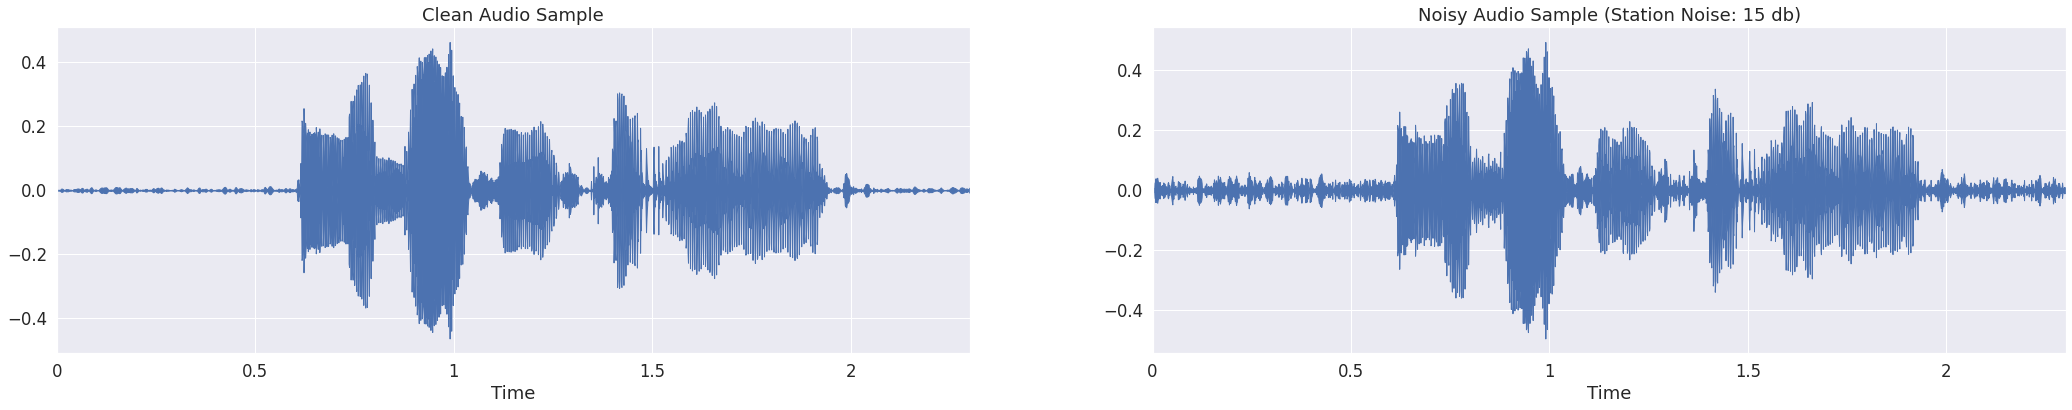

In [40]:
import librosa.display

x_c , sr_c = librosa.load(cln_audio_data)
x_n , sr_n = librosa.load(noi_audio_data)

plt.figure(figsize=(36, 6))
plt.subplot(1,2,1)
librosa.display.waveplot(x_c, sr=sr_c)
plt.title("Clean Audio Sample")
plt.subplot(1,2,2)
librosa.display.waveplot(x_n, sr=sr_n)
plt.title("Noisy Audio Sample (Station Noise: 15 db)")
plt.show()

In [152]:
trainset_df

file_name noise_type  noise_level_db
0      p236_002     babble              15
1      p236_003     babble              10
2      p236_005     babble               5
3      p236_006     babble               0
4      p236_007  cafeteria              15
...         ...        ...             ...
11567  p270_458      metro              10
11568  p270_459      metro               5
11569  p270_460    meeting              10
11570  p270_461        ssn              10
11571  p270_462        car               5

[11572 rows x 3 columns]

## Noise Statistics on the Audio Samples

Exploring the noisy audio samples give us two important insights on noise type in the audio and the noise level (in db). From the distribution plots below, its is obvious that the sample point are well balanced in both those terms. In total 10 different types of noise have been included to the audio clips ranging from 0 db to 5, 10, 15 db levels. 

We will later explore the effects of different noise levels on the accuracy of speech recognition in general 



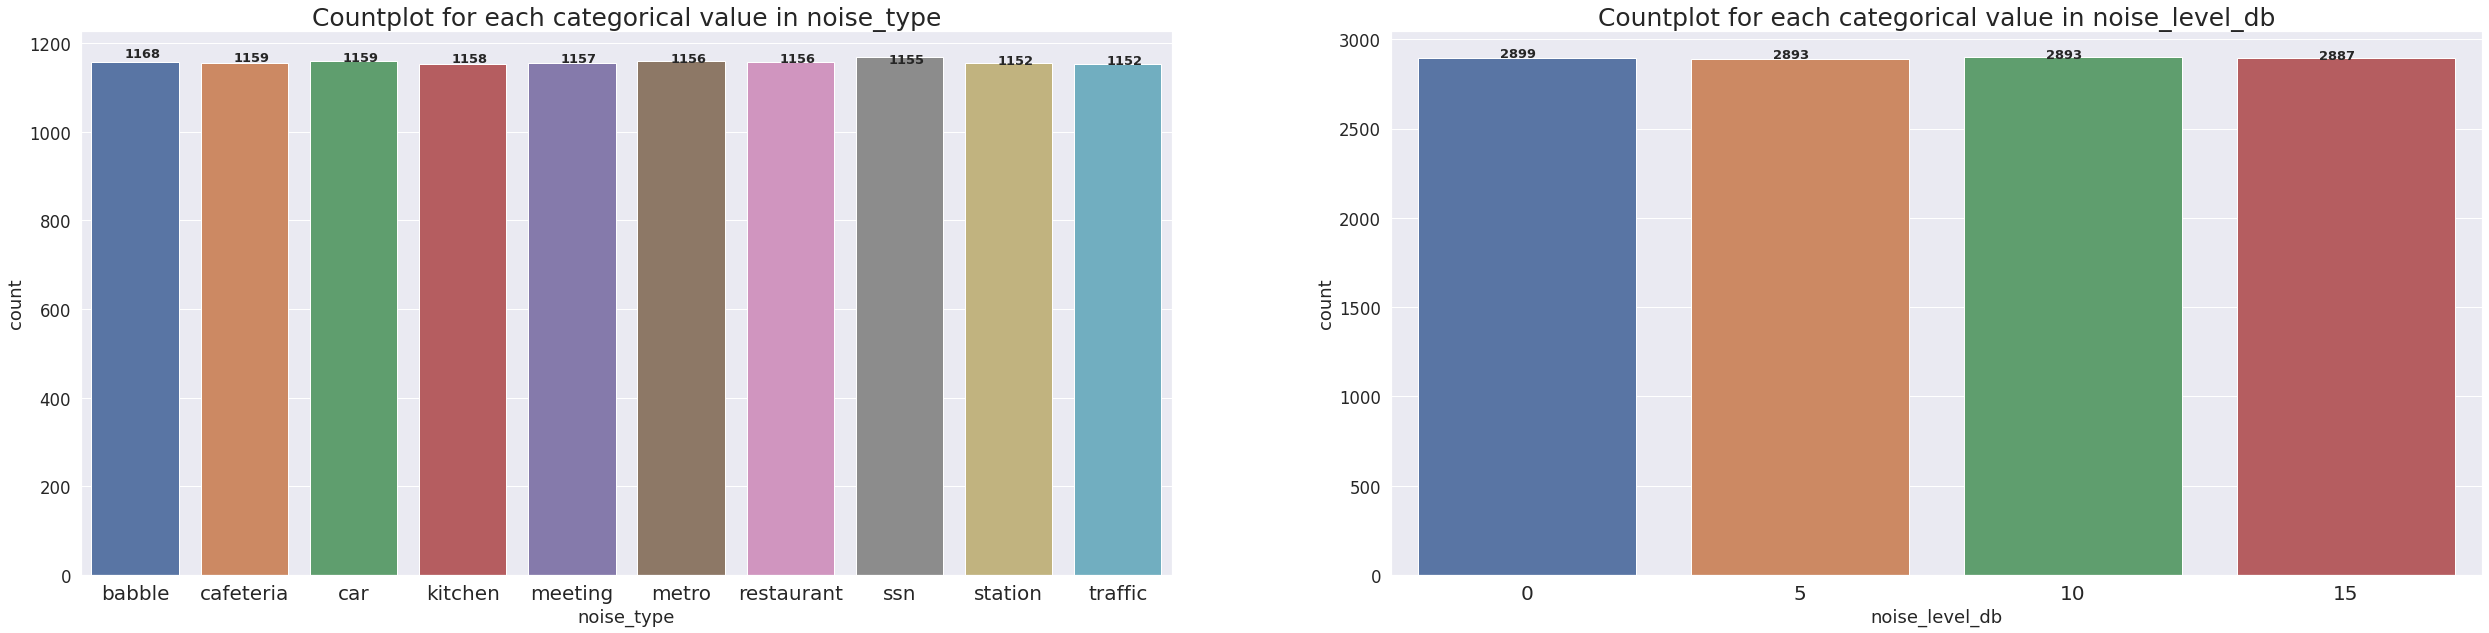

In [161]:
# Categorical Variable
cat_col = ['noise_type','noise_level_db']

  # Plotting categorical plot after filling missing nan values
plt.figure(figsize=(90,10))
cnt = 0
for col in cat_col:
  cnt += 1
  plt.subplot(1, 4, cnt)
  sns.countplot(x = col, data = trainset_df)
  cnt2 = 0
  for val in trainset_df[col].value_counts(): 
    plt.text(-0.1+cnt2*1, val, str(val),fontdict={'weight': 'bold', 'size': 13})
    cnt2 += 1
  plt.xticks(fontsize=20) 
  plt.title("Countplot for each categorical value in "+col, fontsize = 25)
plt.show()

##  Speech Recognition Text from Audio Clips


For the purpose of generating text from audio clip speeches, I use the SpeechRecognition library package. This is a python based tool for converting audio files to text that support various APIs and engines.

Reference:
https://pypi.org/project/SpeechRecognition/

For this project, I use the google web speech API.
https://realpython.com/python-speech-recognition/

By using this API, I make the following assumption:
1. Clean Audio: speech to text is accurate and composes of true translation
2. Noisy Audio: speech to text may have some wrong words translated which we ought to predict. The error in speech translation could mostly be atributed to the background noise superposed on the audio clips at different dB levels


In [0]:
# Function for transcripting clear speeches
def audio_transcript(loc):
  harvard = sr.AudioFile(loc)
  with harvard as source:
    audio = r.record(source)
    return r.recognize_google(audio)


# Function for transcripting noisy speeches
def audio_transcript_all(loc):
  harvard = sr.AudioFile(loc)
  with harvard as source:
    audio = r.record(source)
    a = r.recognize_google(audio, show_all=True)
    if not a:
      return []
    else:
      c = [inx['transcript'] for inx in a['alternative']]
      return c

The example below shows the text conversion from clean and noise audio clips. For clean audio we output the text conversion with highest confidence score, where as for noise audio we output atmost 5 speech text conversion. 

Please note in the example below, the fourth possible text conversion is the accurate one where as all the others have the first word "That" translated incorrectly. This shows that not all the speech text translation are incorrect. I will later sample the output where an error was made. 

Also can be seen is the number of words in the first and third example has changed; from 'that just' to 'adjust' or 'address'. Hence the error created in process is more complex that single word translation.



In [10]:
# Good Example of Speech to Text Conversion: Error in translation limted to one or two words
cln_audio_data = '/content/gdrive/My Drive/clean_trainset/clean_trainset_28spk_wav/p270_460.wav'
noi_audio_data = '/content/gdrive/My Drive/noisy_trainset/noisy_trainset_28spk_wav/p270_460.wav'
print("Speech to Text Conversion: Error in translation limted to one or two words")
print("Clean Audio Speech to Text conversion ------>",audio_transcript(cln_audio_data))
print("Noisy Audio Speech to Text conversion ------>",audio_transcript_all(noi_audio_data))

Speech to Text Conversion: Error in translation limted to one or two words
Clean Audio Speech to Text conversion ------> adjust a good retailer
Noisy Audio Speech to Text conversion ------> ['adjust a good retailer', 'address to good retailer', 'I just a good retailer', 'that just a good retailer', 'it just a good retailer']


In [12]:
print("Example of noisy version of audio clip Good Example")
ipd.Audio(noi_audio_data)

Example of noisy version of audio clip Good Example


In [14]:
# bad Example of Speech to Text Conversion: Error in translation limted to one or two words
cln_audio_data = '/content/gdrive/My Drive/clean_trainset/clean_trainset_28spk_wav/p236_006.wav'
noi_audio_data = '/content/gdrive/My Drive/noisy_trainset/noisy_trainset_28spk_wav/p236_006.wav'
print("Speech to Text Conversion: Error in translation in more than two words")
print("Clean Audio Speech to Text conversion ------>",audio_transcript(cln_audio_data))
print("Noisy Audio Speech to Text conversion ------>",audio_transcript_all(noi_audio_data))

Speech to Text Conversion: Error in translation in more than two words
Clean Audio Speech to Text conversion ------> when the sunlight strikes raindrops in the absence of presidential in the rainbow
Noisy Audio Speech to Text conversion ------> ['when is the next train coming', 'when is the Light Strike train coming', 'when is the light strike train timing', 'when is the light strikes rain coming', 'when is the light strike train cannon', 'when is the light strike ragecomic']


In [15]:
print("Example of noisy version of audio clip Good Example")
ipd.Audio(noi_audio_data)

Example of noisy version of audio clip Good Example


I now convert all audio clip (clean and noisy) to text using Speechrecognition library and save it to a dataframe. A few things to observe are
1. Some NAN values were created for Noisy Audio Outputs, which implies the total available text conversion were less than five.
2. Some NAN values were created for both clean and noisy Audio Output. These will be omitted from our modelling data (4 in total)
3. Textual preprocessing is needed to account for punctuations like apostrophy, forward slashes, full stops, upper cases in text etc. 
4. Some digits were also generated (eg. 2nd record). This will require additional processing to convert digit into words (6 --> six).
5. Proper nouns were also converted incorrectly (record 15 for example, 'Aristotle' to 'are Cecil'). Even though sparse, I will incorporate these in the modelling datasets


In [0]:
# Clean and Noise audio clip speech to text conversion
cnt= 0 
for wavfil in trainset_df['file_name']:
  cnt  = cnt + 1
  cond = trainset_df['file_name'] == wavfil
  cln_soundfile = '/content/gdrive/My Drive/clean_trainset/clean_trainset_28spk_wav/'+str(wavfil)+'.wav'
  noi_soundfile = '/content/gdrive/My Drive/noisy_trainset/noisy_trainset_28spk_wav/'+str(wavfil)+'.wav'
  if not audio_transcript(cln_soundfile):
    print ("Empty Clean Speech Found")
  else:
    clean_mat = audio_transcript(cln_soundfile)
    trainset_df.loc[cond,'clean_speech'] = clean_mat

  noise_mat = audio_transcript_all(noi_soundfile)
  cnt1 = 0
  for elem in noise_mat:
    if (cnt1 < 5):
      col = 'noisy_speech_Out'+str(cnt1+1)
      trainset_df.loc[cond,col] = elem
      cnt1 = cnt1 + 1
  print("Number of Speech trancripted to text {}".format(cnt))

In [16]:
# Loading dataframe with atmost five possible speech conversion of noise audio clip and clear clip
url = "/content/gdrive/My Drive/clean_trainset/speech_trainset_dataframe.csv"
trainset_df = pd.read_csv(url)

dropcol = trainset_df.columns[0:3]
print("Dropping columns in dataframe --> ",dropcol.values)
trainset_df = trainset_df.drop(dropcol,axis=1)
trainset_df.head(50)

Dropping columns in dataframe -->  ['Unnamed: 0' 'Unnamed: 0.1' 'Unnamed: 0.1.1']


file_name  ...                                  noisy_speech_Out5
0   p236_002  ...  could you bring these things with a from the s...
1   p236_003  ...  text into fresh snow peas by 6 lots of cream c...
2   p236_005  ...                          Britney singing 3 bedtime
3   p236_006  ...             what is the Light Strike Crane Company
4   p236_007  ...  the rainbow is a division of white light in so...
5   p236_009  ...  that is according to Legend the boiling pot of...
6   p236_010  ...                                             people
7   p236_011  ...  when am I out of his reach his friends and he'...
8   p236_012  ...  throughout the centuries people have explain t...
9   p236_013  ...  some of that accepted this is America without ...
10  p236_014  ...  to the Hebrews it was a token that will be no ...
11  p236_015  ...  the Greeks used to imagine that it was a sign ...
12  p236_016  ...  the Northman concert at the rain by was a brid...
13  p236_017  ...  other than try to explain the phenomena physic...
14  p236_018  ...  Irish death toll for the rain by was caused by...
15  p236_019  ...  since then physicists have found that is not r...
16  p236_020  ...                                                NaN
17  p236_021  ...  the difference in the rainbow depends consider...
18  p236_023  ...  if the right of the second evolved on the gree...
19  p236_024  ...  pictures of very common type of boat rides in ...
20  p236_025  ...         shirtless has to be throwing up next month
21  p236_026  ...                  in both cases I suffered a fiasco
22  p236_027  ...                    meetings Los and remain private
23  p236_028  ...                                                NaN
24  p236_029  ...                     Ekans have a hell of an effect
25  p236_030  ...                          and we have a thing going
26  p236_031  ...                                  Michelle football
27  p236_032  ...                                                NaN
28  p236_033  ...                           this is essential is she
29  p236_034  ...                                             Alexis
30  p236_035  ...                   it does not pay any of the facts
31  p236_036  ...            if we cannot succeed in this endeavours
32  p236_037  ...                         a card that double message
33  p236_038  ...                         that means an extra to yes
34  p236_039  ...                                                NaN
35  p236_040  ...                      is good as any starting today
36  p236_041  ...                                                NaN
37  p236_042  ...                   Iain Duncan Smith is a decent MO
38  p236_043  ...                        Beckham pain is in disarray
39  p236_044  ...                 after they cancel Grace's quarters
40  p236_045  ...                                  wheel wagon Gomez
41  p236_046  ...                           he looks like a nice car
42  p236_047  ...                     everything else from the bonus
43  p236_048  ...                                                NaN
44  p236_049  ...                          this is an interesting up
45  p236_050  ...                                                NaN
46  p236_051  ...   they just thought it was extremely godot nothing
47  p236_052  ...                                                NaN
48  p236_053  ...                                                NaN
49  p236_054  ...             kisatchie welcome the bride to Outlook

[50 rows x 9 columns]

In [18]:
# Example of empty clean and noise speech translations
trainset_df[trainset_df['clean_speech'].isnull()]

file_name  noise_type  ...  noisy_speech_Out4 noisy_speech_Out5
565   p244_081     traffic  ...                NaN               NaN
2576  p250_100     meeting  ...                NaN               NaN
6307  p278_143       metro  ...                NaN               NaN
7766  p279_354  restaurant  ...                NaN               NaN

[4 rows x 9 columns]

## Textual Processing

### Step 1:
I now process the raw texts from speech recognition to fit our modelling. I first remove the empty values from clean_speech text (4 in total). For better handling of data, I merge all the textual outputs in the form of clean text, noise text pairs. Only the non empty noisy text were selected.

In [19]:
# Drop empty field in clean speech category
cond_clean = ~trainset_df['clean_speech'].isnull()
trainset_edit_df = trainset_df[cond_clean]
trainset_edit_df = trainset_edit_df.reset_index()
trainset_edit_df = trainset_edit_df.drop(['index'],axis=1)
trainset_edit_df

file_name  ...                                  noisy_speech_Out5
0      p236_002  ...  could you bring these things with a from the s...
1      p236_003  ...  text into fresh snow peas by 6 lots of cream c...
2      p236_005  ...                          Britney singing 3 bedtime
3      p236_006  ...             what is the Light Strike Crane Company
4      p236_007  ...  the rainbow is a division of white light in so...
...         ...  ...                                                ...
11563  p270_458  ...                                                NaN
11564  p270_459  ...                                                NaN
11565  p270_460  ...                            it just a good retailer
11566  p270_461  ...                           we all know who can stay
11567  p270_462  ...                                                NaN

[11568 rows x 9 columns]

In [0]:
# Speech Error Output 1
cond_noise1   =~trainset_edit_df['noisy_speech_Out1'].isnull()
noise_exp1_df = trainset_edit_df[cond_noise1][['file_name','clean_speech','noisy_speech_Out1']]
noise_exp1_df = noise_exp1_df.rename(columns = {'noisy_speech_Out1':'noisy_speech'})

# Speech Error Output 2
cond_noise2   =~trainset_edit_df['noisy_speech_Out2'].isnull()
noise_exp2_df = trainset_edit_df[cond_noise2][['file_name','clean_speech','noisy_speech_Out2']]
noise_exp2_df = noise_exp2_df.rename(columns = {'noisy_speech_Out2':'noisy_speech'})

# Speech Error Output 3
cond_noise3   =~trainset_edit_df['noisy_speech_Out3'].isnull()
noise_exp3_df = trainset_edit_df[cond_noise3][['file_name','clean_speech','noisy_speech_Out3']]
noise_exp3_df = noise_exp3_df.rename(columns = {'noisy_speech_Out3':'noisy_speech'})

# Speech Error Output 4
cond_noise4   =~trainset_edit_df['noisy_speech_Out4'].isnull()
noise_exp4_df = trainset_edit_df[cond_noise4][['file_name','clean_speech','noisy_speech_Out4']]
noise_exp4_df = noise_exp4_df.rename(columns = {'noisy_speech_Out4':'noisy_speech'})

# Speech Error Output 5
cond_noise5   =~trainset_edit_df['noisy_speech_Out5'].isnull()
noise_exp5_df = trainset_edit_df[cond_noise5][['file_name','clean_speech','noisy_speech_Out5']]
noise_exp5_df = noise_exp5_df.rename(columns = {'noisy_speech_Out5':'noisy_speech'})

print('Shape of noise error output 1 --> ',noise_exp1_df.shape)
print('Shape of noise error output 2 --> ',noise_exp2_df.shape)
print('Shape of noise error output 3 --> ',noise_exp3_df.shape)
print('Shape of noise error output 4 --> ',noise_exp4_df.shape)
print('Shape of noise error output 5 --> ',noise_exp5_df.shape)

Shape of noise error output 1 -->  (11181, 3)
Shape of noise error output 2 -->  (9900, 3)
Shape of noise error output 3 -->  (8763, 3)
Shape of noise error output 4 -->  (8036, 3)
Shape of noise error output 5 -->  (7217, 3)


In [0]:
noise_output_df = pd.concat([noise_exp1_df,noise_exp2_df,noise_exp3_df,noise_exp4_df,noise_exp5_df],axis = 0)
noise_output_df = noise_output_df.sort_values(by=['file_name'])
noise_output_df = noise_output_df.reset_index()
noise_output_df = noise_output_df.drop(['index'],axis=1)
print('Shape of noise output --> ',noise_output_df.shape)
noise_output_df.head(10)

Shape of noise output -->  (45097, 3)


file_name  ...                                       noisy_speech
0  p226_001  ...                                 please call Stella
1  p226_002  ...  I got to ask her to bring these things with he...
2  p226_002  ...  ask her to bring these things with her from th...
3  p226_002  ...  I asked her to bring these things with her fro...
4  p226_002  ...  asked her to bring these things with her from ...
5  p226_002  ...  I gotta ask her to bring these things with her...
6  p226_003  ...  6 spoons of fresh Nokia's 5 thick slabs Lucci'...
7  p226_003  ...  6 spoons of fresh note is 5 thick slabs Lucche...
8  p226_003  ...  6 spoons of fresh notaries 5 thick slabs Lucch...
9  p226_003  ...  6 spoons of fresh Nokia's 5 thick slabs Lucche...

[10 rows x 3 columns]

### Step 2:
As mentioned earlier some text conversion contains digits. To convert them to words, I use the inflect library package. The example below shows that the numeric digits can be converted to textual words. However, in the process the mathematical signs like division --> / or point --> . is ignored leading to misrepresentation of figure. Hence these signs must be replaced before conversion. Also note that some words contains apostrophes (eg Nokia's) that must be removed from the text.

The following basic textual processing was applied to all the sentences
1. omit punctuations in the words (comma, quote etc)
2. Remove leading and trailing spaces between words
3. Remove alpha numeric texts
4. Convert numeric "digits" to word representations
5. lower case all words

Most of the operations were done using the Spacy object functions.

The processed text are saved in a separate columns of edited texts.

In [24]:
# to convert numbers in words
!pip install inflect
import inflect
p = inflect.engine()
# Example
print("56 becomes",p.number_to_words('56'))
# Example
print("5/6 becomes",p.number_to_words('5/6'))
# Example
print("5.6 becomes",p.number_to_words('5/6'))

56 becomes fifty-six
5/6 becomes fifty-six
5.6 becomes fifty-six


In [0]:
# Spacy Creating Document
nlp = spacy.load('en')

# all the processing work is done below, so it may take a while
for rev in noise_output_df['clean_speech']:
  text =  rev.replace("\'","").replace("/"," by ")
  review_doc = nlp(text)
  c = []
  for token in review_doc:
    if not token.is_punct:
      if not token.is_space:
        if token.is_alpha:
          c.append(token.lower_)
        elif token.is_digit:
          c.append(p.number_to_words(token))
  noise_output_df.loc[noise_output_df['clean_speech'] == rev,'clean_speech_edit']= " ".join(c)

# all the processing work is done below, so it may take a while
for rev in noise_output_df['noisy_speech']:
  text =  rev.replace("\'","").replace("/"," by ")
  review_doc = nlp(text)
  c = []
  for token in review_doc:
    if not token.is_punct:
      if not token.is_space:
        if token.is_alpha:
          c.append(token.lower_)
        elif token.is_digit:
          c.append(p.number_to_words(token))
  noise_output_df.loc[noise_output_df['noisy_speech'] == rev,'noisy_speech_edit']= " ".join(c)

In [28]:
url = "/content/gdrive/My Drive/clean_trainset/0425_speech_noise_output_dataframe.csv"
noise_output_df = pd.read_csv(url)
noise_output_df.head(20)

Unnamed: 0  ...                                  noisy_speech_edit
0            0  ...                                 please call stella
1            1  ...  i got to ask her to bring these things with he...
2            2  ...  ask her to bring these things with her from th...
3            3  ...  i asked her to bring these things with her fro...
4            4  ...  asked her to bring these things with her from ...
5            5  ...  i got ta ask her to bring these things with he...
6            6  ...  six spoons of fresh nokias five thick slabs lu...
7            7  ...  six spoons of fresh note is five thick slabs l...
8            8  ...  six spoons of fresh notaries five thick slabs ...
9            9  ...  six spoons of fresh nokias five thick slabs lu...
10          10  ...  six spoons of fresh gnocchis five thick slabs ...
11          11  ...                              you also need to stop
12          12  ...                                             wilson
13          13  ...                                             wilson
14          14  ...                                         wilsonator
15          15  ...                                         wilson age
16          16  ...  she can scoop these things into three red bags...
17          17  ...  she can scoop these things into three red bags...
18          18  ...  she can scoop these things into three red bags...
19          19  ...  she can skip these things into three red bags ...

[20 rows x 6 columns]

It is observed that some noisy speech text are empty after text cleaning preprocessing. We will omit these record (10 in total)

In [39]:
cond = noise_output_df['noisy_speech_edit'].isnull()
noise_output_df[cond]

Unnamed: 0  ... noisy_speech_edit
4053         4053  ...               NaN
4054         4054  ...               NaN
4353         4353  ...               NaN
16787       16787  ...               NaN
19539       19539  ...               NaN
22238       22238  ...               NaN
34554       34554  ...               NaN
36398       36398  ...               NaN
42472       42472  ...               NaN
44947       44947  ...               NaN

[10 rows x 6 columns]

In [40]:
noise_output_df = noise_output_df[~cond]
noise_output_df = noise_output_df.reset_index()
noise_output_df = noise_output_df.drop(['index','Unnamed: 0'],axis=1)
noise_output_df

file_name  ...                                  noisy_speech_edit
0      p226_001  ...                                 please call stella
1      p226_002  ...  i got to ask her to bring these things with he...
2      p226_002  ...  ask her to bring these things with her from th...
3      p226_002  ...  i asked her to bring these things with her fro...
4      p226_002  ...  asked her to bring these things with her from ...
...         ...  ...                                                ...
45082  p287_423  ...  intime may prove a worthy successor to billy d...
45083  p287_423  ...  in time may prove a worthy successor jubilee d...
45084  p287_424  ...                   both motions come as no surprise
45085  p287_424  ...                  those motions come as no surprise
45086  p287_424  ...                  most emotions come as no surprise

[45087 rows x 5 columns]

## Data Exploration

After textual preprocessing, some data exploration on the word frequency and word cloud suggest the distribution to be slighly different .

1. In general, the most frequent word  is 'the'
2. Top 50 frequent words are mostly coming from preposition or article
3. Word cloud in general looks different hinting to the different word frequency as a result of errors in speech recognitions

In [0]:
# Matrix
cln_speech_mat = []
noi_speech_mat = []

for i,_ in enumerate(noise_output_df['clean_speech_edit']):
  cln_speech_txt = noise_output_df.iloc[i]['clean_speech_edit'].split()
  noi_speech_txt = noise_output_df.iloc[i]['noisy_speech_edit'].split()
  for ele1 in cln_speech_txt:
    cln_speech_mat.append(ele1)
  for ele2 in noi_speech_txt:
    noi_speech_mat.append(ele2)

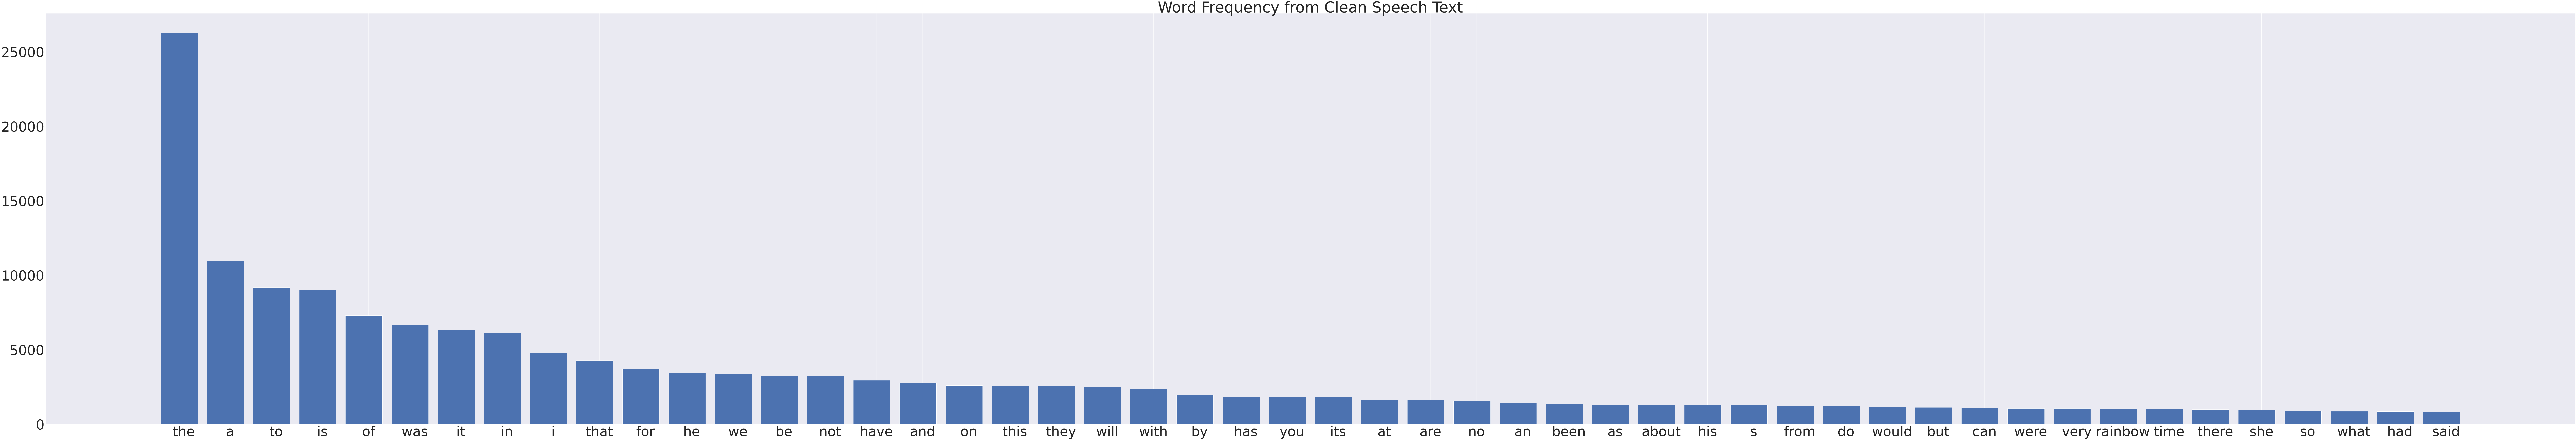

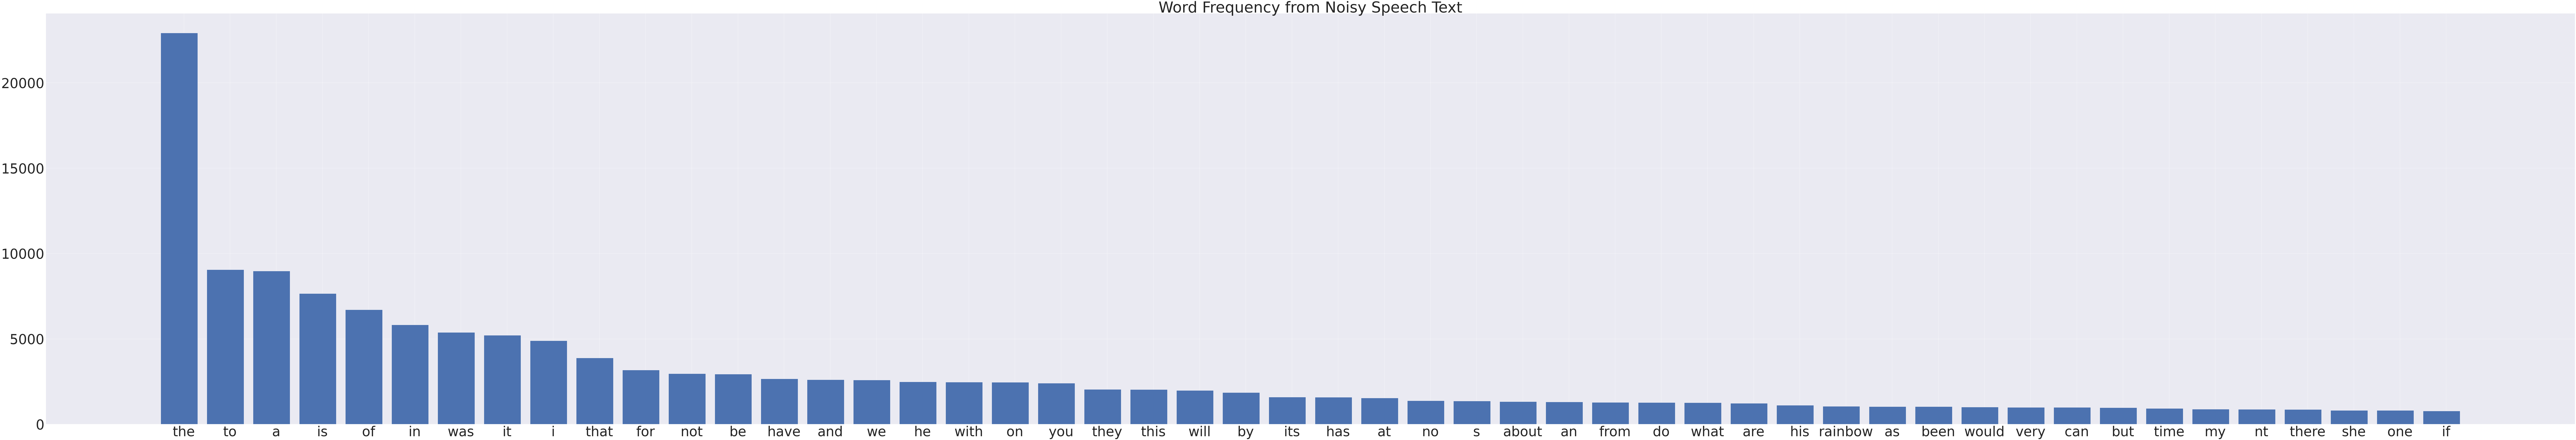

In [88]:
# Word Frequency for Clean Speeches
plt.figure(figsize=(300,50))

#plt.hist(cln_speech_mat)
word_list = cln_speech_mat
counts = Counter(word_list)
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort][0:50]
values = np.array(values)[indSort][0:50]

indexes = np.arange(len(labels))
bar_width = 0.1
plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)
plt.xticks(fontsize=90) 
plt.yticks(fontsize=90) 
plt.title("Word Frequency from Clean Speech Text",fontsize=100)
plt.show()

# Word Frequency for Noisy Speeches
plt.figure(figsize=(300,50))

#plt.hist(cln_speech_mat)
word_list = noi_speech_mat
counts = Counter(word_list)
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort][0:50]
values = np.array(values)[indSort][0:50]

indexes = np.arange(len(labels))
bar_width = 0.1
plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)
plt.xticks(fontsize=90) 
plt.yticks(fontsize=90) 
plt.title("Word Frequency from Noisy Speech Text",fontsize=100)
plt.show()

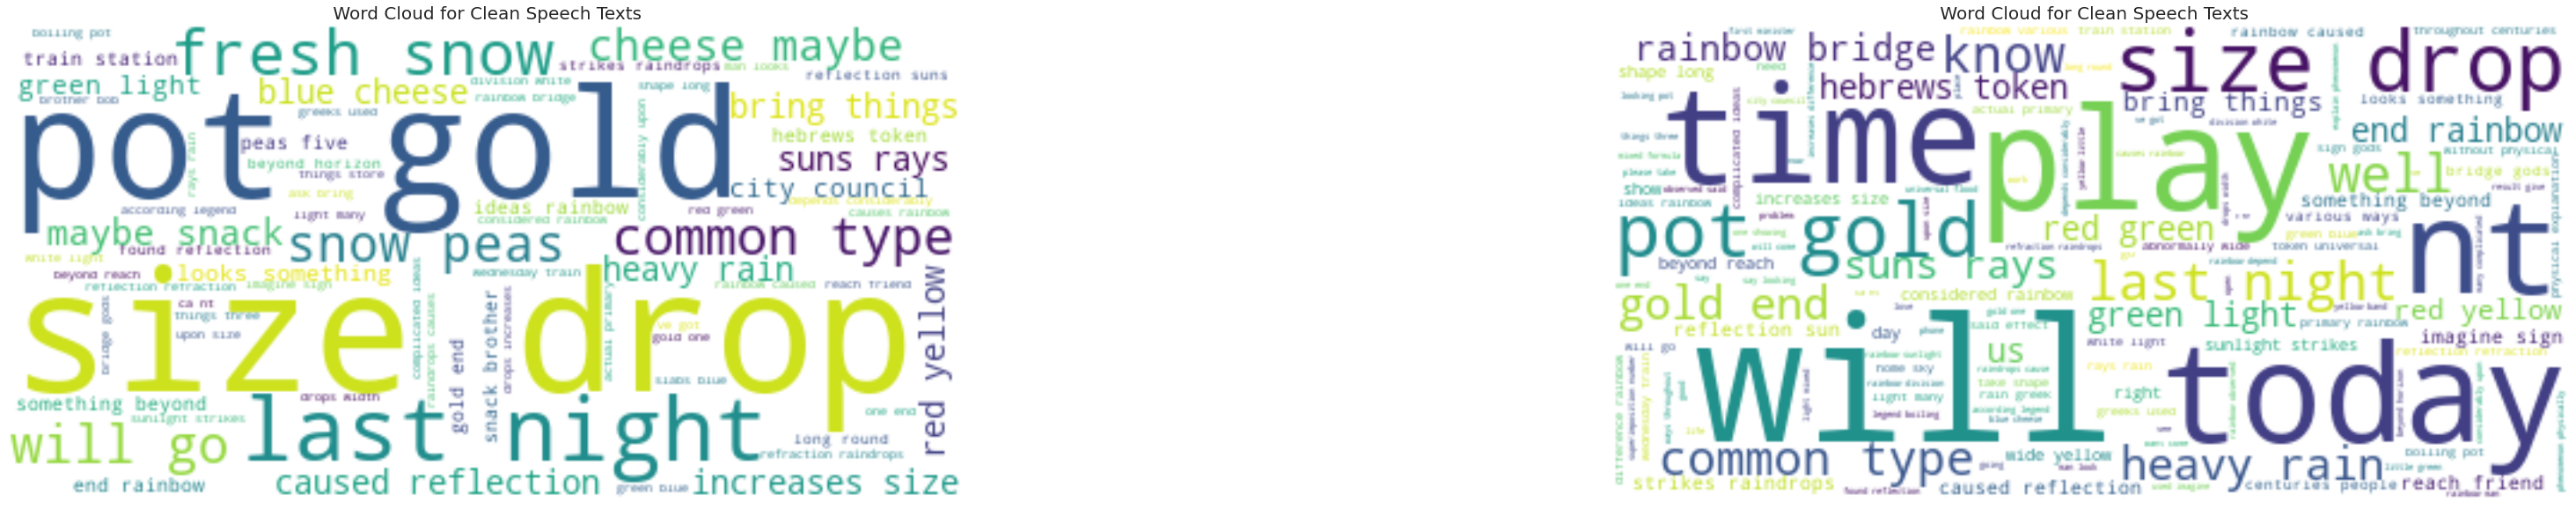

In [92]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud_cln = WordCloud(background_color="white").generate(" ".join(noise_output_df['clean_speech_edit']))
wordcloud_noi = WordCloud(background_color="white").generate(" ".join(noise_output_df['noisy_speech_edit']))
plt.figure(figsize=(60,10))

plt.subplot(1, 2, 1)
# Display the generated image:
plt.imshow(wordcloud_cln, interpolation='bilinear')
plt.axis("off")
plt.title(" Word Cloud for Clean Speech Texts", fontsize = 20)

plt.subplot(1, 2, 2)
# Display the generated image:
plt.imshow(wordcloud_noi, interpolation='bilinear')
plt.axis("off")
plt.title(" Word Cloud for Clean Speech Texts", fontsize = 20)

plt.show()

## Data Transformation: Clean vs Noisy Speech Comparison 

Since now I have both the clean and noisy versions of speech, I will identifying word mismatches in the two version. This way I can specifically identify the word and word location in sentences that is in error. For this purpose I mask out the word that matches (or are common) between the two as xxxxxx. 

Also I get a count of number of words that do not match and store them in a separate column 
1. clean_speech_edit_detect_num	
2. noisy_speech_edit_detect_num	

We will use these numbers later to control our model training and test sets

I define a function that read the two sentences to compare and scan word by word in certain window (offset of words) to determine if a word match can be made or not. 
1. If a match is made, the words is masked as xxxxxx
2. If no match is made, the word is unchanged and counted as detected mismatched word

Function word_mismatch2 includes :
> mat 1 : Sentence or sequence of words to be scanned for erroneous

> mat 2 : Sentence or sequence of words used for comparison

> nb : word offset eg nb = 2 means 2 words before and 2 words after are checked for wordmatch

In [0]:
def word_mismatch2(mat1,mat2, nb):
  totn_mat1 = []
  disn_mat1 = [] 
  # Find similar words
  cnt = 0
  for ap in mat1:
    lim1 = max(0,cnt-nb)
    lim2 = min(cnt+nb,len(mat2))
    totn_mat1.append([ind for ind in mat2[lim1:lim2] if (ind == ap)])
    cnt = cnt + 1
  #print(totn_mat1)

  # Filter mismatched Words
  cnt = 0
  misnum = 0
  for at in totn_mat1:
    if (at == []):
      disn_mat1.append(mat1[cnt])
      misnum = misnum + 1
    else:
      disn_mat1.append('xxxxxx')
    cnt = cnt + 1

  outp = " ".join(disn_mat1)
  if len(outp) == 0 :
    outp = 'xxxxxx'
  return {'sent': outp, 'num_word' : misnum}

In [0]:
# clean / noisy edit
for ind in range(0,noise_output_df.shape[0]):
  a_mat = [token.lower_ for token in nlp(noise_output_df.iloc[ind]['clean_speech_edit'])]
  b_mat = [token.lower_ for token in nlp(noise_output_df.iloc[ind]['noisy_speech_edit'])]
  noise_output_df.loc[ind,'clean_speech_edit_detect'] = word_mismatch2(a_mat,b_mat,2)['sent']
  noise_output_df.loc[ind,'noisy_speech_edit_detect'] = word_mismatch2(b_mat,a_mat,2)['sent']
  noise_output_df.loc[ind,'clean_speech_edit_detect_num'] = word_mismatch2(a_mat,b_mat,2)['num_word']
  noise_output_df.loc[ind,'noisy_speech_edit_detect_num'] = word_mismatch2(b_mat,a_mat,2)['num_word']

In [5]:
#noise_output_df.to_csv('0425_speech_noise_output_dataframe_step2.csv')
#!cp 0425_speech_noise_output_dataframe_step2.csv "/content/gdrive/My Drive/clean_trainset/"
url = "/content/gdrive/My Drive/clean_trainset/0425_speech_noise_output_dataframe_step2.csv"
noise_output_df = pd.read_csv(url)
noise_output_df = noise_output_df.dropna()
noise_output_df = noise_output_df.reset_index()
noise_output_df = noise_output_df.drop(['index','Unnamed: 0'],axis=1)
noise_output_df

file_name  ... noisy_speech_edit_detect_num
0      p226_001  ...                          0.0
1      p226_002  ...                         13.0
2      p226_002  ...                          0.0
3      p226_002  ...                          2.0
4      p226_002  ...                          1.0
...         ...  ...                          ...
45082  p287_423  ...                          2.0
45083  p287_423  ...                          2.0
45084  p287_424  ...                          2.0
45085  p287_424  ...                          2.0
45086  p287_424  ...                          1.0

[45087 rows x 9 columns]

In [6]:
# Example of the detect string generated for clean and noise speech text conversion
print ("Clean Speech Version -->",noise_output_df.iloc[4]['clean_speech_edit'])
print ("Noisy Speech Version -->",noise_output_df.iloc[4]['noisy_speech_edit'])
print ("Clean Speech Version with Detect -->",noise_output_df.iloc[4]['clean_speech_edit_detect'])
print ("Noisy Speech Version with Detect -->",noise_output_df.iloc[4]['noisy_speech_edit_detect'])
print ("Clean Speech Version: No of word that dont match with noisy version -->",noise_output_df.iloc[4]['clean_speech_edit_detect_num'])
print ("Noisy Speech Version: No of word that dont match with clean version -->",noise_output_df.iloc[4]['noisy_speech_edit_detect_num'])

def examp_ill(pos):
  print ("Clean Speech Version -->",noise_output_df.iloc[pos]['clean_speech_edit'])
  print ("Noisy Speech Version -->",noise_output_df.iloc[pos]['noisy_speech_edit'])
  print ("Clean Speech Version with Detect -->",noise_output_df.iloc[pos]['clean_speech_edit_detect'])
  print ("Noisy Speech Version with Detect -->",noise_output_df.iloc[pos]['noisy_speech_edit_detect'])
  print ("Clean Speech Version: No of word that dont match with noisy version -->",noise_output_df.iloc[pos]['clean_speech_edit_detect_num'])
  print ("Noisy Speech Version: No of word that dont match with clean version -->",noise_output_df.iloc[pos]['noisy_speech_edit_detect_num'])

Clean Speech Version --> ask her to bring these things with her from the store
Noisy Speech Version --> asked her to bring these things with her from the store
Clean Speech Version with Detect --> ask xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx
Noisy Speech Version with Detect --> asked xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx
Clean Speech Version: No of word that dont match with noisy version --> 1.0
Noisy Speech Version: No of word that dont match with clean version --> 1.0


Note that we have detected multiple case of mismatch in both clean and noisy speech text. Based on these a number of cases can be classified: 
1. Cases where both clean and noisy speech **translation matches** 
2. Cases where one word in clean is mis-translated to **one word** in noisy
3. Cases where one word in clean is mis-translated to **two words** in noisy
4. Cases where one word in clean is mis-translated to **three words** in noisy
5. Cases where one word in clean is mis-translated to **more than three words** in noisy
6. Cases where one word in clean is mis-translated to **zero words** in noisy
7. Cases where **two words** in clean is mis-translated to one word in noisy
8. Cases where **three words** in clean is mis-translated to one word in noisy
9. Cases where **more than three words** in clean is mis-translated to one word in noisy
10. Cases where **zero word** in clean is mis-translated to one words in noisy

One point to note is almost 16% of the text conversion are good meaning that there is 16/100th probability that the speech recognition was accurate under low-moderate and strong background noises


In [7]:
cond0 = (noise_output_df['clean_speech_edit_detect_num'] ==  1) & (noise_output_df['noisy_speech_edit_detect_num'] ==  0)
cond1 = (noise_output_df['clean_speech_edit_detect_num'] ==  1) & (noise_output_df['noisy_speech_edit_detect_num'] ==  1)
cond2 = (noise_output_df['clean_speech_edit_detect_num'] ==  1) & (noise_output_df['noisy_speech_edit_detect_num'] ==  2)
cond3 = (noise_output_df['clean_speech_edit_detect_num'] ==  1) & (noise_output_df['noisy_speech_edit_detect_num'] ==  3)
condm = (noise_output_df['clean_speech_edit_detect_num'] ==  1) & (noise_output_df['noisy_speech_edit_detect_num'] >  3)

print("Number of cases where one word in clean was mis-translated to one word in noisy case -->",cond1.sum())
print("Number of cases where one word in clean was mis-translated to two words in noisy case -->",cond2.sum())
print("Number of cases where one word in clean was mis-translated to three words in noisy case -->",cond3.sum())
print("Number of cases where one word in clean was mis-translated to zero word in noisy case -->",cond0.sum())
print("Number of cases where one word in clean was mis-translated to more than three word in noisy case -->",condm.sum())

print("\n")
ncond0 = (noise_output_df['clean_speech_edit_detect_num'] ==  0) & (noise_output_df['noisy_speech_edit_detect_num'] ==  1)
ncond1 = (noise_output_df['clean_speech_edit_detect_num'] ==  1) & (noise_output_df['noisy_speech_edit_detect_num'] ==  1)
ncond2 = (noise_output_df['clean_speech_edit_detect_num'] ==  2) & (noise_output_df['noisy_speech_edit_detect_num'] ==  1)
ncond3 = (noise_output_df['clean_speech_edit_detect_num'] ==  3) & (noise_output_df['noisy_speech_edit_detect_num'] ==  1)
ncondm = (noise_output_df['clean_speech_edit_detect_num'] >  3) & (noise_output_df['noisy_speech_edit_detect_num'] ==  1)

print("Number of cases where one word in clean was mis-translated to one word in noisy case -->",ncond1.sum())
print("Number of cases where two words in clean was mis-translated to one words in noisy case -->",ncond2.sum())
print("Number of cases where three words in clean was mis-translated to one word in noisy case -->",ncond3.sum())
print("Number of cases where zero word in clean was mis-translated to one word in noisy case -->",ncond0.sum())
print("Number of cases where more than three words in clean was mis-translated to one word in noisy case -->",ncondm.sum())

print("\n")
nmcond0 = (noise_output_df['clean_speech_edit_detect_num'] ==  0) & (noise_output_df['noisy_speech_edit_detect_num'] ==  0)
print("Number of cases where clean and noisy translations matches -->",nmcond0.sum())

Number of cases where one word in clean was mis-translated to one word in noisy case --> 9939
Number of cases where one word in clean was mis-translated to two words in noisy case --> 1824
Number of cases where one word in clean was mis-translated to three words in noisy case --> 96
Number of cases where one word in clean was mis-translated to zero word in noisy case --> 1213
Number of cases where one word in clean was mis-translated to more than three word in noisy case --> 27


Number of cases where one word in clean was mis-translated to one word in noisy case --> 9939
Number of cases where two words in clean was mis-translated to one words in noisy case --> 3011
Number of cases where three words in clean was mis-translated to one word in noisy case --> 277
Number of cases where zero word in clean was mis-translated to one word in noisy case --> 680
Number of cases where more than three words in clean was mis-translated to one word in noisy case --> 601


Number of cases where clean

In [8]:
noise_output_df[nmcond0]

file_name  ... noisy_speech_edit_detect_num
0      p226_001  ...                          0.0
2      p226_002  ...                          0.0
18     p226_005  ...                          0.0
20     p226_005  ...                          0.0
23     p226_006  ...                          0.0
...         ...  ...                          ...
45050  p287_415  ...                          0.0
45056  p287_416  ...                          0.0
45060  p287_417  ...                          0.0
45062  p287_419  ...                          0.0
45068  p287_420  ...                          0.0

[7315 rows x 9 columns]

In [9]:
print("\nCases where one word in clean was mis-translated to zero word in noisy case\n")
examp_ill(57)
print("\nCases where one word in clean was mis-translated to one word in noisy case\n")
examp_ill(4)
print("\nCases where one word in clean was mis-translated to two words in noisy case\n")
examp_ill(135)
print("\nCases where one word in clean was mis-translated to three words in noisy case\n")
examp_ill(4423)
print("\nCases where one word in clean was mis-translated to multiple words in noisy case\n")
examp_ill(2901)


Cases where one word in clean was mis-translated to zero word in noisy case

Clean Speech Version --> to the hebrews it was a token that i would be no more universal floods
Noisy Speech Version --> to the hebrews it was a token that that would be no more universal floods
Clean Speech Version with Detect --> xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx i xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx
Noisy Speech Version with Detect --> xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx
Clean Speech Version: No of word that dont match with noisy version --> 1.0
Noisy Speech Version: No of word that dont match with clean version --> 0.0

Cases where one word in clean was mis-translated to one word in noisy case

Clean Speech Version --> ask her to bring these things with her from the store
Noisy Speech Version --> asked her to bring these things with her from the store
Clean Speech Version with Detect --> ask xxxxxx xxxxxx xxxx

If we explore the histrograms, We find that most of the cases belongs to one word being mis-translated into another one word.


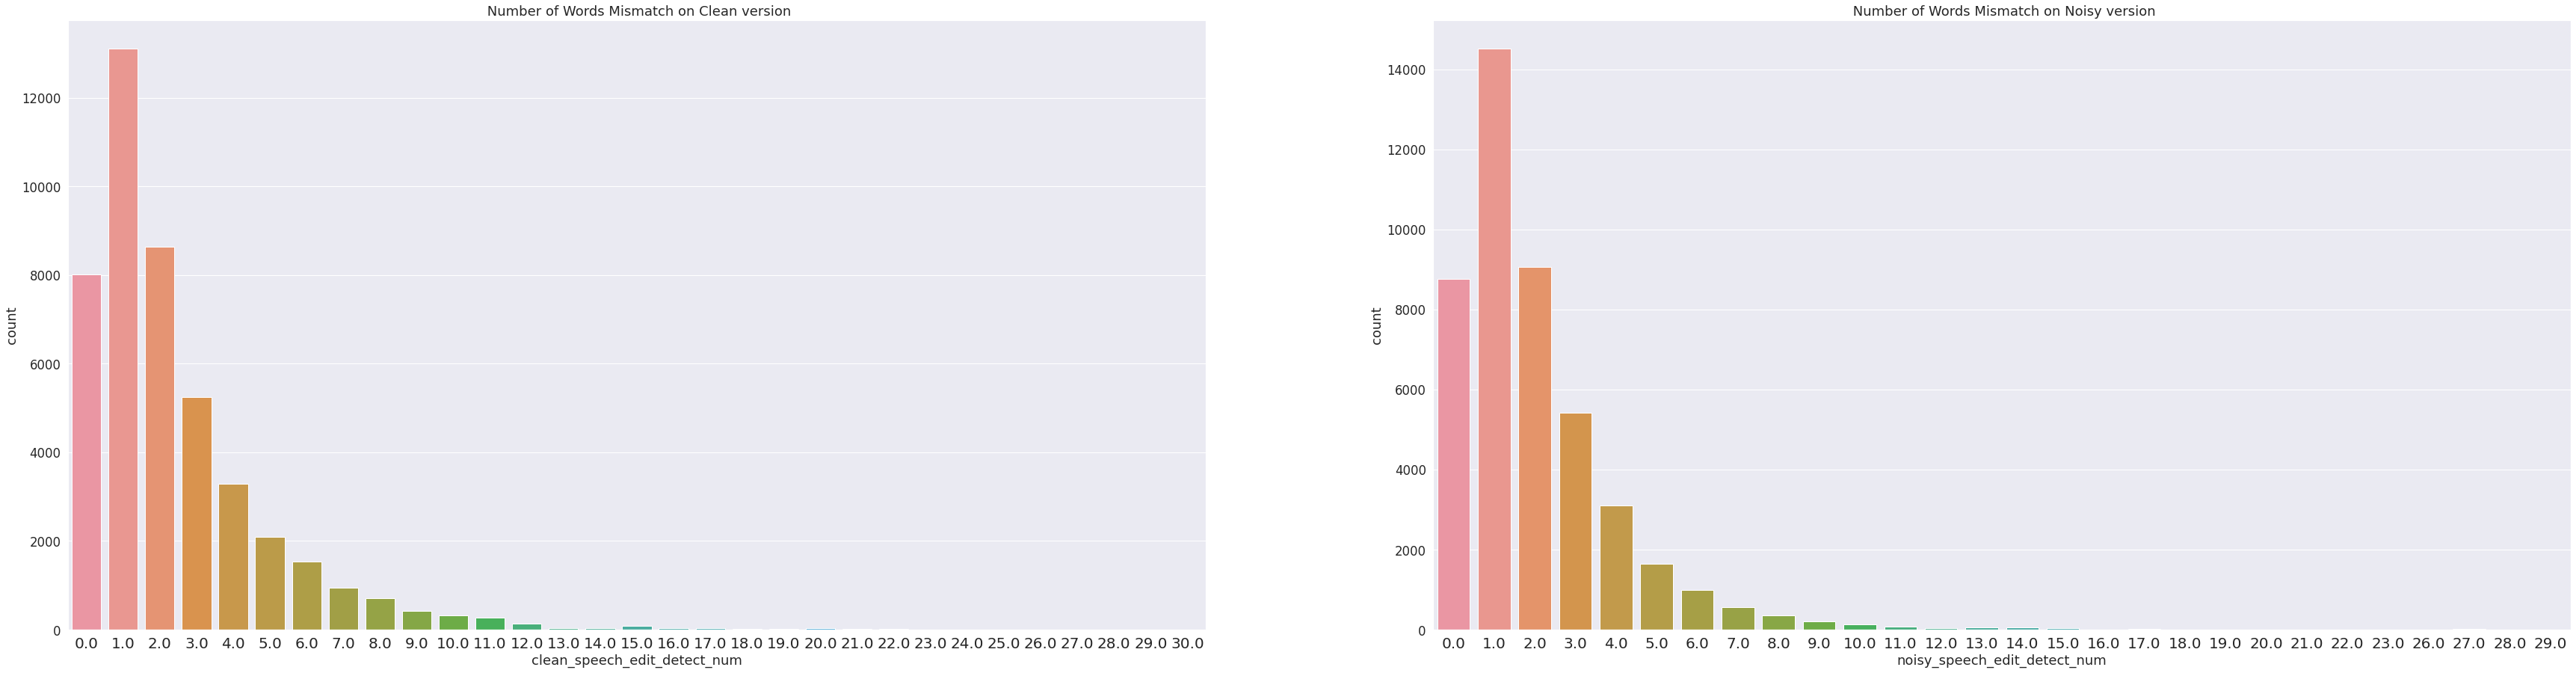

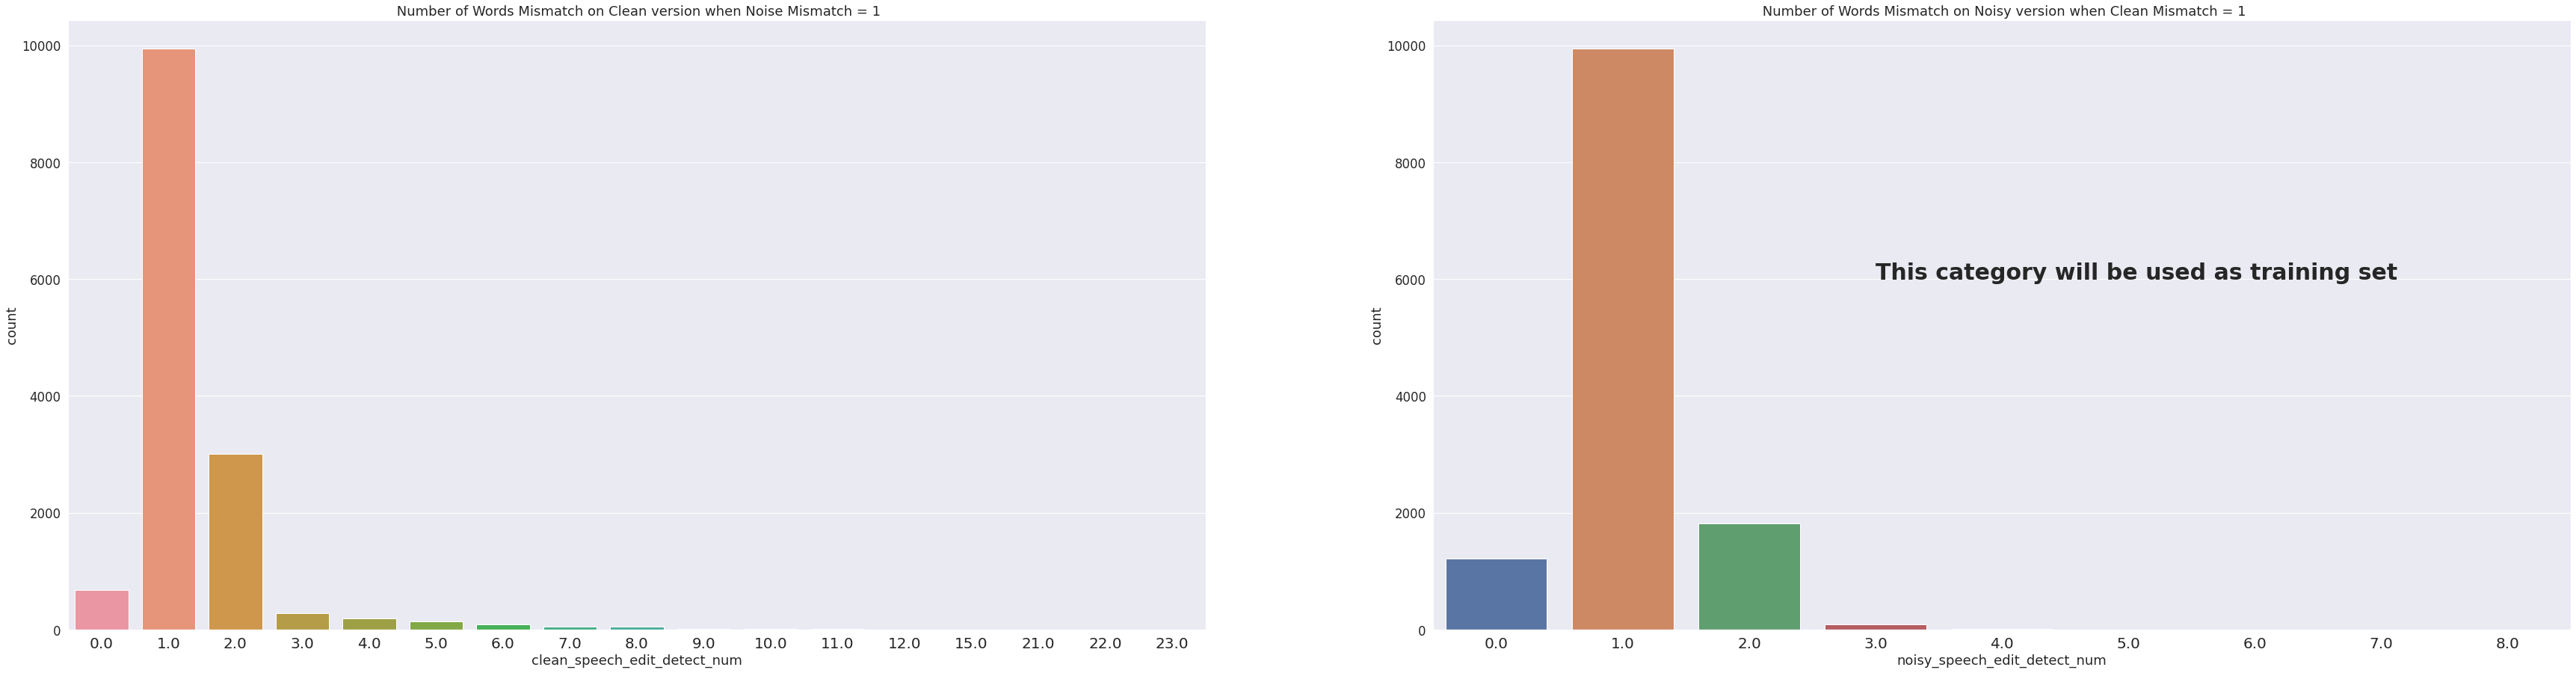

In [10]:
# General Statistics Plot
plt.figure(figsize=(60,15))
plt.subplot(1, 2, 1)
sns.countplot(x = 'clean_speech_edit_detect_num',data = noise_output_df)
plt.xticks(fontsize=20)
plt.title(" Number of Words Mismatch on Clean version")

plt.subplot(1, 2, 2)
sns.countplot(x = 'noisy_speech_edit_detect_num',data = noise_output_df)
plt.xticks(fontsize=20)
plt.title(" Number of Words Mismatch on Noisy version")
plt.show()

# General Statistics Plot (for situation where clean_mismatch = 1 and noise_mismatch = 1)
plt.figure(figsize=(60,15))
plt.subplot(1, 2, 1)
sns.countplot(x = 'clean_speech_edit_detect_num',data = noise_output_df[noise_output_df['noisy_speech_edit_detect_num'] == 1])
plt.xticks(fontsize=20)
plt.title(" Number of Words Mismatch on Clean version when Noise Mismatch = 1")

plt.subplot(1, 2, 2)
sns.countplot(x = 'noisy_speech_edit_detect_num',data = noise_output_df[noise_output_df['clean_speech_edit_detect_num'] == 1])
plt.xticks(fontsize=20)
plt.text(3, 6000, "This category will be used as training set" ,fontdict={'weight': 'bold', 'size': 30})
plt.title(" Number of Words Mismatch on Noisy version when Clean Mismatch = 1")
plt.show()

## Statistics in terms of Noise type and Noise Levels

As we earlier demonstrated, the noise type and noise levels on the audio clips are fairly balanced. However, when we categories based on the quality of speech translated text, we find some interesting insights.

1.   Distribution between non-errored and errored speech translantion noise types and noise level are fairly similar.
2.   Top three noise type sources are car, kitchen and metro noises
3.   Higher speech-to-text count for higher noise db level



In [0]:
for xi,fname in enumerate(trainset_df['file_name']):
  cond = (trainset_df['file_name'] == fname)
  cond_o = (noise_output_df['file_name'] == fname)
  noise_output_df.loc[cond_o,'noise_type'] = trainset_df[cond]['noise_type'].values[0]
  noise_output_df.loc[cond_o,'noise_level_db'] = trainset_df[cond]['noise_level_db'].values[0]

In [14]:
noise_output_df

file_name  ... noise_level_db
0      p226_001  ...           15.0
1      p226_002  ...           10.0
2      p226_002  ...           10.0
3      p226_002  ...           10.0
4      p226_002  ...           10.0
...         ...  ...            ...
45082  p287_423  ...           15.0
45083  p287_423  ...           15.0
45084  p287_424  ...            0.0
45085  p287_424  ...            0.0
45086  p287_424  ...            0.0

[45087 rows x 11 columns]

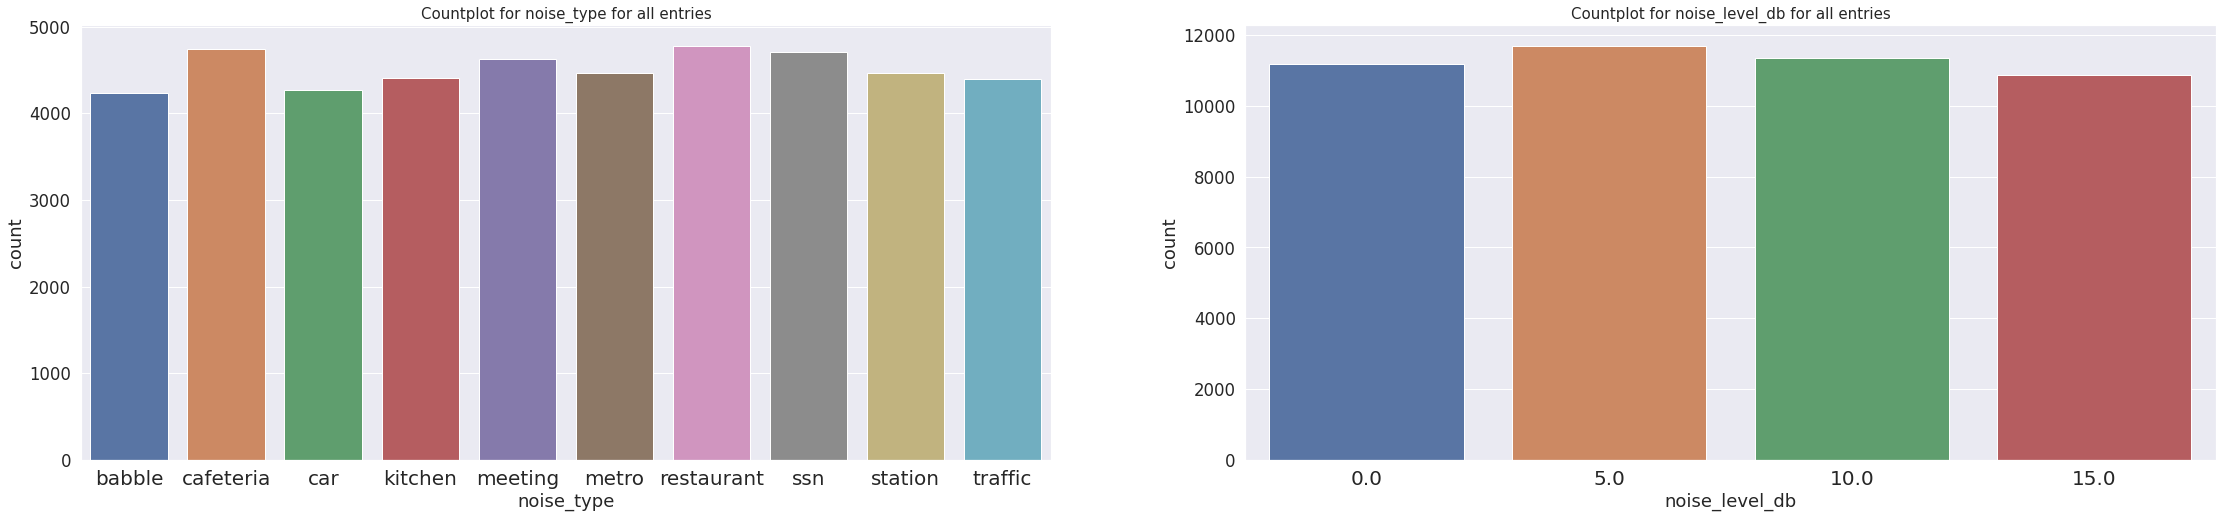

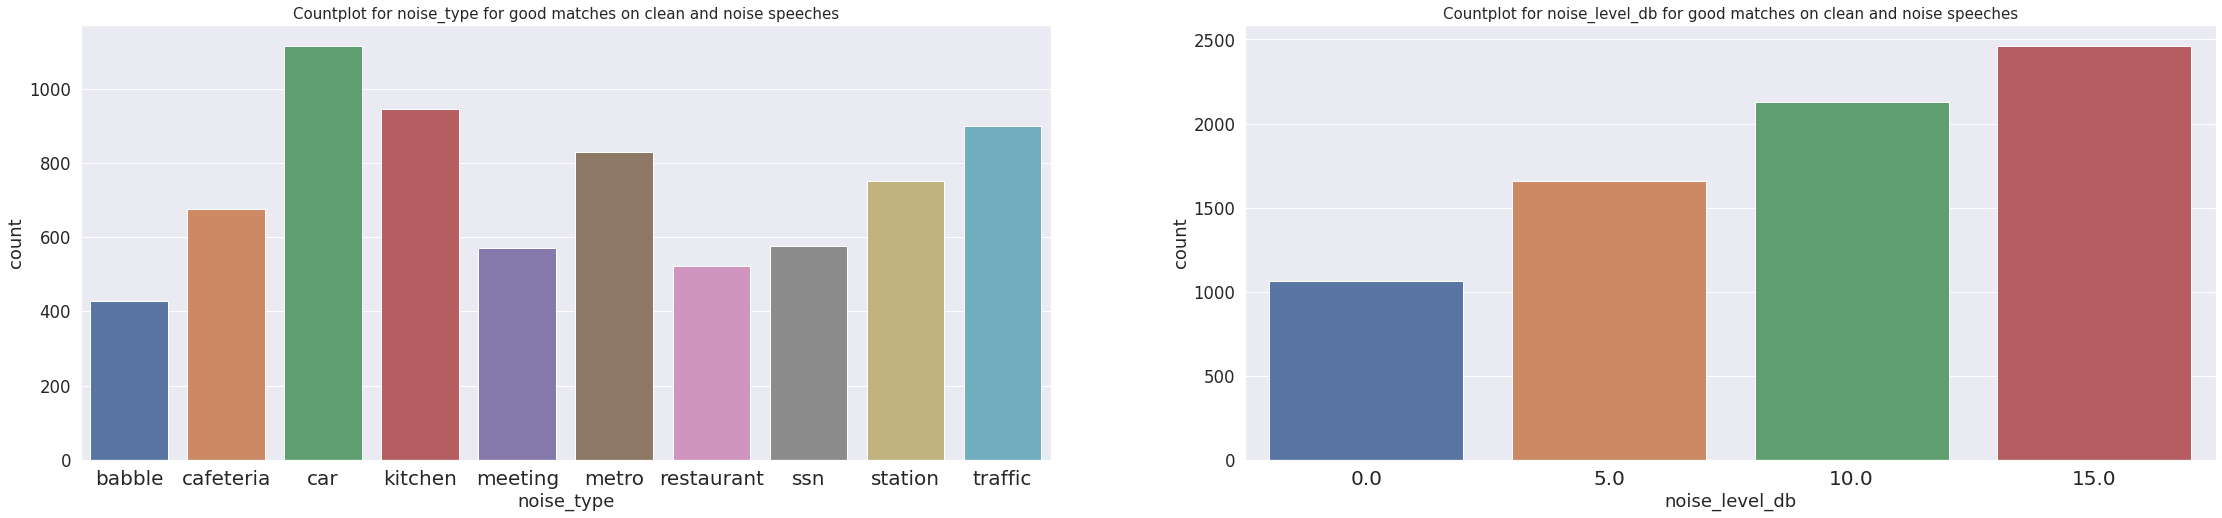

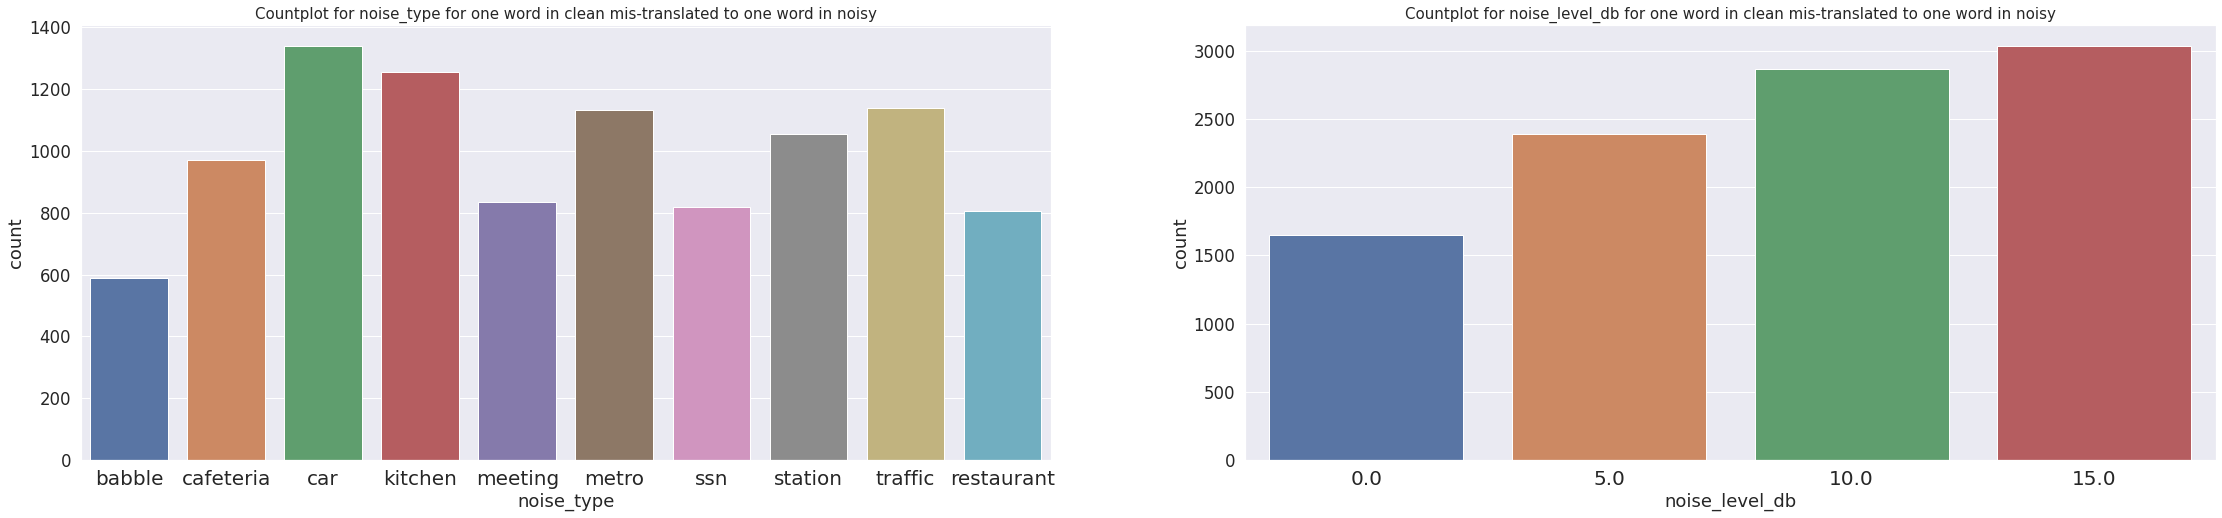

In [199]:
# Categorical Variable
cat_col = ['noise_type','noise_level_db']

# Plotting categorical plot for all entries
plt.figure(figsize=(80,8))
cnt = 0
for col in cat_col:
  cnt += 1
  plt.subplot(1, 4, cnt)
  sns.countplot(x = col, data = noise_output_df)
  cnt2 = 0
  for val in trainset_df[col].value_counts(): 
    #plt.text(-0.1+cnt2*1, val, str(val),fontdict={'weight': 'bold', 'size': 13})
    cnt2 += 1
  plt.xticks(fontsize=20) 
  plt.title("Countplot for "+col+" for all entries", fontsize = 15)
plt.show()

# Plotting categorical plot for entries with no speech recognition errors
cond = nmcond0
plt.figure(figsize=(80,8))
cnt = 0
for col in cat_col:
  cnt += 1
  plt.subplot(1, 4, cnt)
  sns.countplot(x = col, data = noise_output_df[cond])
  cnt2 = 0
  for val in trainset_df[col].value_counts(): 
    #plt.text(-0.1+cnt2*1, val, str(val),fontdict={'weight': 'bold', 'size': 13})
    cnt2 += 1
  plt.xticks(fontsize=20) 
  plt.title("Countplot for "+col+" for good matches on clean and noise speeches", fontsize = 15)
plt.show()

# Plotting categorical plot with
cond = cond1
plt.figure(figsize=(80,8))
cnt = 0
for col in cat_col:
  cnt += 1
  plt.subplot(1, 4, cnt)
  sns.countplot(x = col, data = noise_output_df[cond])
  cnt2 = 0
  for val in trainset_df[col].value_counts(): 
    #plt.text(-0.1+cnt2*1, val, str(val),fontdict={'weight': 'bold', 'size': 13})
    cnt2 += 1
  plt.xticks(fontsize=20) 
  plt.title("Countplot for "+col+" for one word in clean mis-translated to one word in noisy", fontsize = 15)
plt.show()

## Subsampling Data: Input text


---


We are now ready to running our deep learning modelling using the noisy speech conversion text and the detect text. For the input to the deep learning model I have to modify our input texts slightly. 

### Modelling Input
I split each sentence into three word sequences in the form of 

**AAAAAAA --- BBBBBB --- CCCCCC**

The advantage of this split method is that I increase the number of input going into training the model. Only case where one of the word has been mistranslated is used. The other advantage is the context of the word is also honored in the process by including words that is placed before and after the current word. 

Since we are dealing with statistical/deep learning model that uses number or digits to operate, these words need to be tokenized or hot encoded to be represented as numbers. The three word input are therefore tokenized with each unique word assigned a number. we will deal with the hot encoding at later stages.

Note : I insert a hash tag before and after the word sequence to maintain a continuous word input stream accros the three word sequence

### Modelling Output

For the output, I design a 4 element binary dummy array with element indicating the position of erroneous word(s) in the three word input

**ZZZZZZZZ, 1111111 , 2222222 , 3333333**

> 1111111 --> 1 indicate erroneous word as first word 

> 2222222 --> 1 indicate erroneous word as middle word

> 3333333 --> 1 indicate erroneous word as last word 

> ZZZZZZZ --> 1 indicate no erroneous word present

### Selection of Data for Modelling

From the histrograms on the number of word detected, I select the case for modelling under the circumstance that only one clear speech word was mis-translated
1. Cases where one word in clean is mis-translated to **one word** in noisy version

I make this selection to simplify and stabilizing the prediction modelling in consideration that majority of errors were made on one word from clean speech. I also avoid using speeches with two or more than two erroneous words as these are sparse (lesser probability of occuring) and may introduce strong variance in the input.

Please also note that the cases where some words were eliminated in translation is also avoid in processing. Modelling in such a case is more complex as identifying the errorenous word maybe tricky.

In [0]:
def input_split(text, veclen):
  inpmat = []
  nlp_text = [token.lower_ for token in nlp(text)]
  nlp_text = ["#"]+nlp_text+["#"]
  for ind in range(0,veclen):
    if ind < (len(nlp_text)-1):
      if (nlp_text[ind] != '#'):
        inpmat.append(" ".join([nlp_text[ind-1],nlp_text[ind],nlp_text[ind+1]]))
  return inpmat

In [0]:
def output_mat_split(text, origtext, veclen):
  outmat = []
  nlp_text     = [token.lower_ for token in nlp(text)]
  nlp_origtext = [token.lower_ for token in nlp(origtext)]
  nlp_text = ["#"]+nlp_text+["#"]
  nlp_origtext = ["#"]+nlp_origtext+["#"]
  for ind in range(0,veclen):
    if ind < (len(nlp_text)-1):
      if (nlp_text[ind] != '#'):
        if ((((nlp_text[ind-1] == 'xxxxxx') | (nlp_text[ind-1] == '#')) & (nlp_text[ind] != 'xxxxxx') & ((nlp_text[ind+1] == 'xxxxxx') | (nlp_text[ind+1] == '#')))):
          outmat.append([0,0,1,0])
        elif ((((nlp_text[ind-1] != 'xxxxxx') & (nlp_text[ind-1] != '#')) & (nlp_text[ind] == 'xxxxxx') & ((nlp_text[ind+1] == 'xxxxxx') | (nlp_text[ind+1] == '#')))):
          outmat.append([0,1,0,0])
        elif ((((nlp_text[ind-1] == 'xxxxxx') | (nlp_text[ind-1] == '#')) & (nlp_text[ind] == 'xxxxxx') & ((nlp_text[ind+1] != 'xxxxxx') & (nlp_text[ind+1] != '#')))):
          outmat.append([0,0,0,1])
        elif ((((nlp_text[ind-1] == 'xxxxxx') | (nlp_text[ind-1] == '#')) & (nlp_text[ind] != 'xxxxxx') & ((nlp_text[ind+1] != 'xxxxxx') & (nlp_text[ind+1] != '#')))):
          outmat.append([num/2.0 for num in [0,0,1,1]])
        elif ((((nlp_text[ind-1] != 'xxxxxx') & (nlp_text[ind-1] != '#')) & (nlp_text[ind] == 'xxxxxx') & ((nlp_text[ind+1] != 'xxxxxx') & (nlp_text[ind+1] != '#')))):
          outmat.append([num/2.0 for num in [0,1,0,1]])
        elif ((((nlp_text[ind-1] != 'xxxxxx') & (nlp_text[ind-1] != '#')) & (nlp_text[ind] != 'xxxxxx') & ((nlp_text[ind+1] == 'xxxxxx') | (nlp_text[ind+1] == '#')))):
          outmat.append([num/2.0 for num in [0,1,1,0]])
        elif ((((nlp_text[ind-1] != 'xxxxxx') & (nlp_text[ind-1] != '#')) & (nlp_text[ind] != 'xxxxxx') & ((nlp_text[ind+1] != 'xxxxxx') & (nlp_text[ind+1] != '#')))):
          outmat.append([num/3.0 for num in [0,1,1,1]])
        else:
          outmat.append([1,0,0,0])
  return outmat

In [137]:
# Example when one word is mismatched
print("Example when one word are mismatched")
x = noise_output_df.iloc[4]['noisy_speech_edit']
y = noise_output_df.iloc[4]['noisy_speech_edit_detect']
print("The actual sentence ---> ", x)
print("The Detect sentence ---> ", y)
print("Input Example :",input_split(x,100))
print("Output Example :",output_mat_split(y,x,100))
print("\n")
a = input_split(x,100)
b = output_mat_split(y,x,100)
for i,_ in enumerate(input_split(x,100)):
  print("Input :",a[i],"-------------------->",b[i], ": Output" )

Example when one word are mismatched
The actual sentence --->  asked her to bring these things with her from the store
The Detect sentence --->  asked xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx xxxxxx
Input Example : ['# asked her', 'asked her to', 'her to bring', 'to bring these', 'bring these things', 'these things with', 'things with her', 'with her from', 'her from the', 'from the store', 'the store #']
Output Example : [[0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]]


Input : # asked her --------------------> [0, 0, 1, 0] : Output
Input : asked her to --------------------> [0, 1, 0, 0] : Output
Input : her to bring --------------------> [1, 0, 0, 0] : Output
Input : to bring these --------------------> [1, 0, 0, 0] : Output
Input : bring these things --------------------> [1, 0, 0, 0] : Output
Input : these things with --------------------> [1, 0, 0, 0] : 

In [132]:
# Only selecting the case where one word was mis-translated into another word
cond_df = (noise_output_df['clean_speech_edit_detect_num'] == 1) & ( (noise_output_df['noisy_speech_edit_detect_num'] == 1))
trainset_noise_df = noise_output_df[cond_df]
trainset_noise_df = trainset_noise_df.reset_index()
trainset_noise_df = trainset_noise_df.drop(['index'],axis=1)
trainset_noise_df

file_name  ... noise_level_db
0     p226_002  ...           10.0
1     p226_005  ...           15.0
2     p226_006  ...           10.0
3     p226_006  ...           10.0
4     p226_006  ...           10.0
...        ...  ...            ...
9934  p287_414  ...           15.0
9935  p287_414  ...           15.0
9936  p287_416  ...           10.0
9937  p287_416  ...           10.0
9938  p287_419  ...            0.0

[9939 rows x 11 columns]

In [117]:
#trainset_noise_df.to_csv('0427_speech_trainset_noise.csv')
#!cp 0427_speech_trainset_noise.csv "/content/gdrive/My Drive/clean_trainset/"
url = "/content/gdrive/My Drive/clean_trainset/0427_speech_trainset_noise.csv"
trainset_noise_df = pd.read_csv(url)
trainset_noise_df

Unnamed: 0 file_name  ... noise_type noise_level_db
0               3  p226_002  ...     babble           10.0
1               4  p226_002  ...     babble           10.0
2              19  p226_005  ...  cafeteria           15.0
3              21  p226_006  ...  cafeteria           10.0
4              22  p226_006  ...  cafeteria           10.0
...           ...       ...  ...        ...            ...
11854       45055  p287_416  ...    kitchen           10.0
11855       45063  p287_419  ...    kitchen            0.0
11856       45066  p287_419  ...    kitchen            0.0
11857       45084  p287_424  ...        car            0.0
11858       45085  p287_424  ...        car            0.0

[11859 rows x 12 columns]

In [118]:
trainset_noise_df = trainset_noise_df[trainset_noise_df['noisy_speech_edit_detect_num'] == 1]
trainset_noise_df = trainset_noise_df.reset_index()
trainset_noise_df = trainset_noise_df.drop(['index'],axis=1)
trainset_noise_df

Unnamed: 0 file_name  ... noise_type noise_level_db
0              4  p226_002  ...     babble           10.0
1             19  p226_005  ...  cafeteria           15.0
2             21  p226_006  ...  cafeteria           10.0
3             22  p226_006  ...  cafeteria           10.0
4             24  p226_006  ...  cafeteria           10.0
...          ...       ...  ...        ...            ...
9934       45046  p287_414  ...  cafeteria           15.0
9935       45048  p287_414  ...  cafeteria           15.0
9936       45054  p287_416  ...    kitchen           10.0
9937       45055  p287_416  ...    kitchen           10.0
9938       45063  p287_419  ...    kitchen            0.0

[9939 rows x 12 columns]

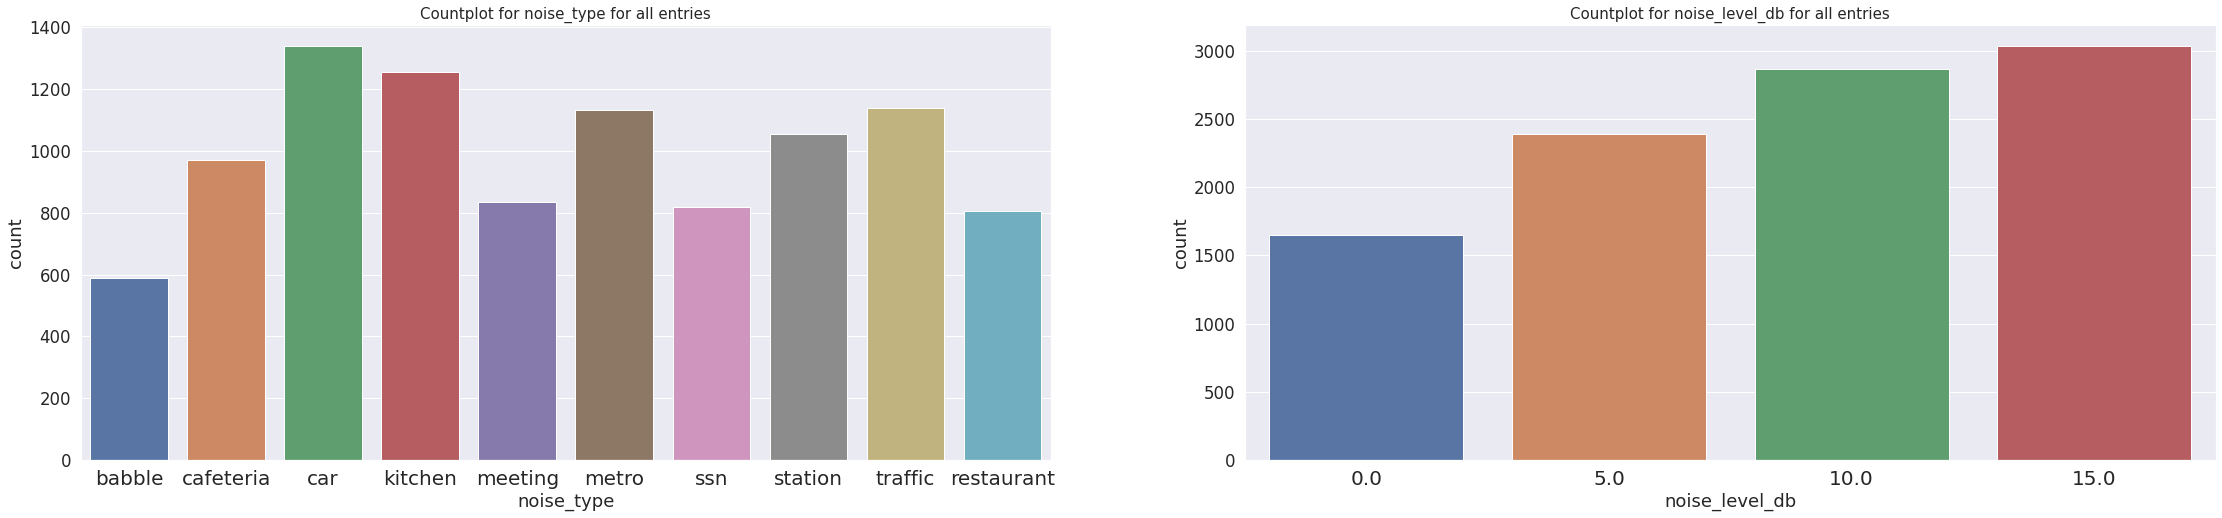

In [6]:
# Categorical Variable
cat_col = ['noise_type','noise_level_db']

# Plotting categorical plot for all entries
plt.figure(figsize=(80,8))
cnt = 0
for col in cat_col:
  cnt += 1
  plt.subplot(1, 4, cnt)
  sns.countplot(x = col, data = trainset_noise_df)
  cnt2 = 0
  for val in trainset_noise_df[col].value_counts(): 
    #plt.text(-0.1+cnt2*1, val, str(val),fontdict={'weight': 'bold', 'size': 13})
    cnt2 += 1
  plt.xticks(fontsize=20) 
  plt.title("Countplot for "+col+" for all entries", fontsize = 15)
plt.show()

In [0]:
# Preparing three string inputs for Neural Network using Subsampling
nn_input_mat = []
for i,_ in enumerate(trainset_noise_df['noisy_speech_edit']):
  orig_text   = trainset_noise_df.iloc[i]['noisy_speech_edit']
  detect_text = trainset_noise_df.iloc[i]['noisy_speech_edit_detect']
  nn_input_mat  = np.append(nn_input_mat,input_split(orig_text,100), axis = 0)

In [0]:
# Preparing dummy array output for Neural Network using Subsampling
nn_output_loc_mat = []
for i,_ in enumerate(trainset_noise_df['noisy_speech_edit']):
  orig_text   = trainset_noise_df.iloc[i]['noisy_speech_edit']
  detect_text = trainset_noise_df.iloc[i]['noisy_speech_edit_detect']
  if (i == 0) :
    nn_output_loc_mat = output_mat_split(detect_text,orig_text,100)
  else :
    nn_output_loc_mat = np.append(nn_output_loc_mat,output_mat_split(detect_text,orig_text,100), axis = 0)

In [34]:
print("Size of input Matrix: ",nn_input_mat.shape)
print("Size of output Matrix 4 vector: ",nn_output_loc_mat.shape)

Size of input Matrix:  (72818,)
Size of output Matrix 4 vector:  (72818, 4)


## Hot encoding the input matrix

Now that we have three word input matrix, I hot encode the word matrix. Since the modelling works in digits or numbers I would have to convert each word (or character) into representative numbers. This I do using the tokenizer from keras.text that assigns a number to each uniquely identified word. In our case of training dataset, 5666 unique words were recognized. In the process 3 word vector is convert into 3 number vector. We shall use this as our input to the neural networks.

In [35]:
from keras.preprocessing import text
from keras.preprocessing import sequence
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.

tokenizer_inp = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"$%&()*+,-/:;<=>?@[\]^_`{|}~', lower=True)
#tokenizer.fit_on_texts(np.append(rhym_comb, targ_comb, axis=0))
tokenizer_inp.fit_on_texts(nn_input_mat)
word_index_inp = tokenizer_inp.word_index
print('Found %s unique tokens.' % len(word_index_inp))

MAX_SEQUENCE_LENGTH = 3
X = tokenizer_inp.texts_to_sequences(nn_input_mat)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

#X = X/len(word_index_inp)
X=X.astype('float')
Y= nn_output_loc_mat#.astype('float')

print('Shape of data X tensor:', X.shape)
print('Shape of data Y tensor:', Y.shape)

Using TensorFlow backend.


Found 5666 unique tokens.
Shape of data X tensor: (72818, 3)
Shape of data Y tensor: (72818, 4)


In [72]:
cnt = 50
for i,_ in enumerate(nn_input_mat[cnt:cnt+10]):
  print("Input Word :\t",nn_input_mat[i+cnt],"\t-------------------->\t",X[i+cnt].astype('int'), "\t: Input Hotcoded Data" )

Input Word :	 strikes raindrops in 	-------------------->	 [534 306   8] 	: Input Hotcoded Data
Input Word :	 raindrops in the 	-------------------->	 [306   8   2] 	: Input Hotcoded Data
Input Word :	 in the air 	-------------------->	 [  8   2 708] 	: Input Hotcoded Data
Input Word :	 the air they 	-------------------->	 [  2 708  24] 	: Input Hotcoded Data
Input Word :	 air they act 	-------------------->	 [708  24 478] 	: Input Hotcoded Data
Input Word :	 they act as 	-------------------->	 [ 24 478  33] 	: Input Hotcoded Data
Input Word :	 act as a 	-------------------->	 [478  33   3] 	: Input Hotcoded Data
Input Word :	 as a prison 	-------------------->	 [ 33   3 479] 	: Input Hotcoded Data
Input Word :	 a prison in 	-------------------->	 [  3 479   8] 	: Input Hotcoded Data
Input Word :	 prison in fullmer 	-------------------->	 [ 479    8 3341] 	: Input Hotcoded Data


## Deep Learning Neural Network Modeling using NLP

For NLP modeling, I use the bidirection LSTM (Long-Short Term Memory) RNN  (Recurrent Neural Network) architecture. LSTM based Recurrent Neural Network is a powerfool tool in modelling NLP task like spelling correction, speech recognition, sentiment analysis, conversational AI chatbot, summarize blocks of text etc.

The following paragraph explains the benefit of LSTM (RNN) based nn modelling

------- The bidirectional Long Short Term Memory networks (BLSTM) that can be trained using all available input information in the past and future of a specific time frame. For example, Let us take an example of missing word generation in the I am ___ student. Unidirectional LSTMs will use only ‘I am’ to generate next word and based on the example it has seen during training it will generate a new word (it may be ‘a’, ‘very’ etc.). But bidirectional LSTMs have information of the past (I am) and future (student), so it can easily see that here it has to be a. It’s a very poor example but explains the context clearly. --------

https://medium.com/@BhashkarKunal/spelling-correction-using-deep-learning-how-bi-directional-lstm-with-attention-flow-works-in-366fabcc7a2f


In our case, the input is a stream of three words and RNN architecture can support the word collection and word context of the inputs. I will be using this architecture as a default for our purpose and in the following section will perform parameter hypertuning to optimize the modelling performance.

To give some details on the modelling parameters 
1. The first layer is the embedded layer that uses 16 length vectors to represent each word. Max word is set to 6000 (5666 unique word identified)
2. SpatialDropout1D performs variational dropout in NLP models.
3. The next layer is bidirection LSTM layer with 8 memory units.
4. The output layer with 3 output values, one for each class indicating the position of word error. The activation function is softmax for multi-class classification which equated to the probability of word errors

5. Model Compilation: Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function. Also the 'ADAM' optimizer is used against 'stochastic gradient descent' optimization function 'SGD'. Preliminary testing showed 'sgd' dint yield any convergence in modelling against 'adam'


## LSTM Modelling: Hyperparameter Tuning


---

Now that I have a foundational model to use, I perform the hypertuning in following 5 parameters:
1. Training Performance : Learning Rate of Model 
2. Training Performance : Batch Size
3. Model Architecture : LSTM / Bidirectional LSTM / 2 Bidirectional LSTM
4. Model Architecture : Number of Hidden Layer
5. Model Architecture : Activation Output

For the purpose of evaluating the modelling performance on trained and untrained data, I use a 10% validation split along with shuffle = 'True' enabled. Also the acurracy and loss function metric is plotted v/s epoch to evaluate model fitting performance

I limit the number of epoch to be around 50-60

### 1. Training Performance: Learning Rate Tunning

Learning rate were varied in three values 0.0001, 0.01 and 1

*   **Learning Rate: 0.0001** is totally underfit and does not converge to a meaning full solution. Both loss and accuracy metrics are some what constant. This also implies that I get a constant output function for each input call 
*   **Learning Rate: 0.01** seems to convergence in the intial few epochs for both train and validation tests. The loss function for validation reduces and reaches a local minima around 5 epochs. On the other hand the loss functions for training sets seems to be exponential reducing. The validation accuracy also seems to reach a maximum of 70% verses training set accuarcy of 78% and more.However by midway (5 epochs and beyond)  we observe that the model tend to overfit towards the training datasets and the accuracy of validation set reduce.
*   **Learning Rate: 1.0** shows somewhat similar performance to learning rate of 0.01. However, an argument can be made that model convergence to slightly lesser epochs [3 to 4 against 6]

**A learning rate of 0.01 is considered to be the optimal choice for running the model**

It is also shown that a cut off epoch of 5-6 with a learning rate of 0.01 can be used




In [139]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras import optimizers

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 6000

# This is fixed.
EMBEDDING_DIM = 16

# Number of Epoch to Test
epochs = 250

# Batch Size of NN
batch_size = 320

######################### TEST 1 (Learning Rate : 0.0001) #########################
# Defining the NN Model Architecture (Learning Rate : 0.0001)
model_lr1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.0001)
model_lr1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lr1.summary()

######################### TEST 2 (Learning Rate : 0.01) ###########################
# Defining the NN Model Architecture (Learning Rate : 0.01)
model_lr2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_lr2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lr2.summary()

######################### TEST 3 (Learning Rate : 1) ##############################
# Defining the NN Model Architecture (Learning Rate : 1)
model_lr3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=1)
model_lr3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lr3.summary()


#model.fit(X, nn_output_loc_mat, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 3, 16)             96000     
_________________________________________________________________
spatial_dropout1d_22 (Spatia (None, 3, 16)             0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 16)                1600      
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 68        
Total params: 97,668
Trainable params: 97,668
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 3, 16)             96000     
__________________________

In [160]:
# Fitting the Model on the current data
history_lr1 = model_lr1.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)
history_lr2 = model_lr2.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)
history_lr3 = model_lr3.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)

Epoch 1/250
205/205 [==============================] - 1s 6ms/step - loss: 0.3174 - accuracy: 0.8813 - val_loss: 1.5312 - val_accuracy: 0.7063
Epoch 2/250
205/205 [==============================] - 1s 6ms/step - loss: 0.3170 - accuracy: 0.8802 - val_loss: 1.5527 - val_accuracy: 0.7061
Epoch 3/250
205/205 [==============================] - 1s 6ms/step - loss: 0.3170 - accuracy: 0.8807 - val_loss: 1.5312 - val_accuracy: 0.7037
Epoch 4/250
205/205 [==============================] - 1s 6ms/step - loss: 0.3177 - accuracy: 0.8808 - val_loss: 1.5356 - val_accuracy: 0.7048
Epoch 5/250
205/205 [==============================] - 1s 6ms/step - loss: 0.3152 - accuracy: 0.8815 - val_loss: 1.5474 - val_accuracy: 0.7031
Epoch 6/250
205/205 [==============================] - 1s 6ms/step - loss: 0.3166 - accuracy: 0.8810 - val_loss: 1.5530 - val_accuracy: 0.7006
Epoch 7/250
205/205 [==============================] - 1s 6ms/step - loss: 0.3177 - accuracy: 0.8809 - val_loss: 1.5403 - val_accuracy: 0.7048

In [0]:
def nnmodel_stat(history_nn, title):

  plt.figure(figsize=(30,10))
  plt.subplot(1, 2, 1)
  # Plot training & validation accuracy values
  plt.plot(history_nn.history['accuracy'][0:50])
  plt.plot(history_nn.history['val_accuracy'][0:50])
  plt.title('Model accuracy '+title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1, 2, 2)
  # Plot training & validation loss values
  plt.plot(history_nn.history['loss'][0:50])
  plt.plot(history_nn.history['val_loss'][0:50])
  plt.title('Model loss '+title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

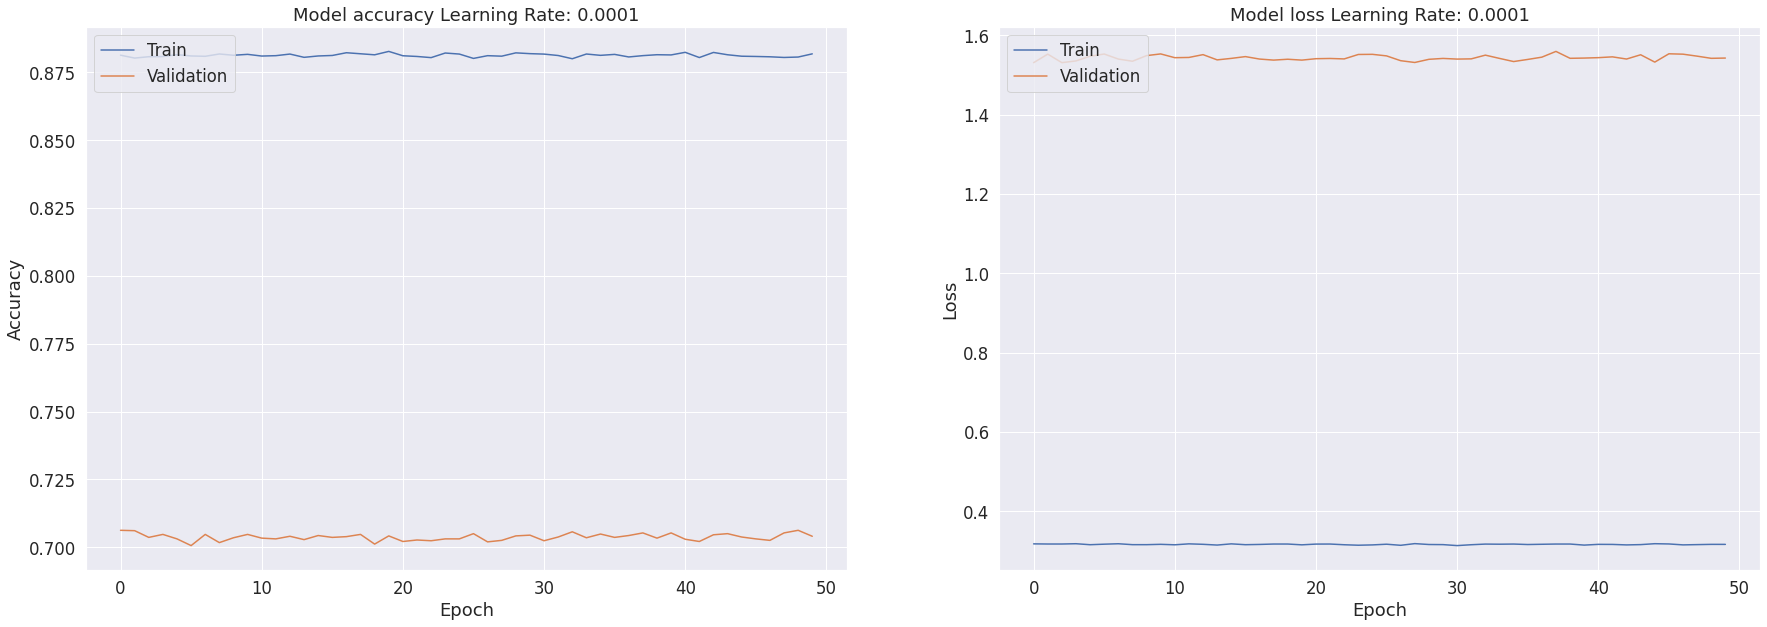

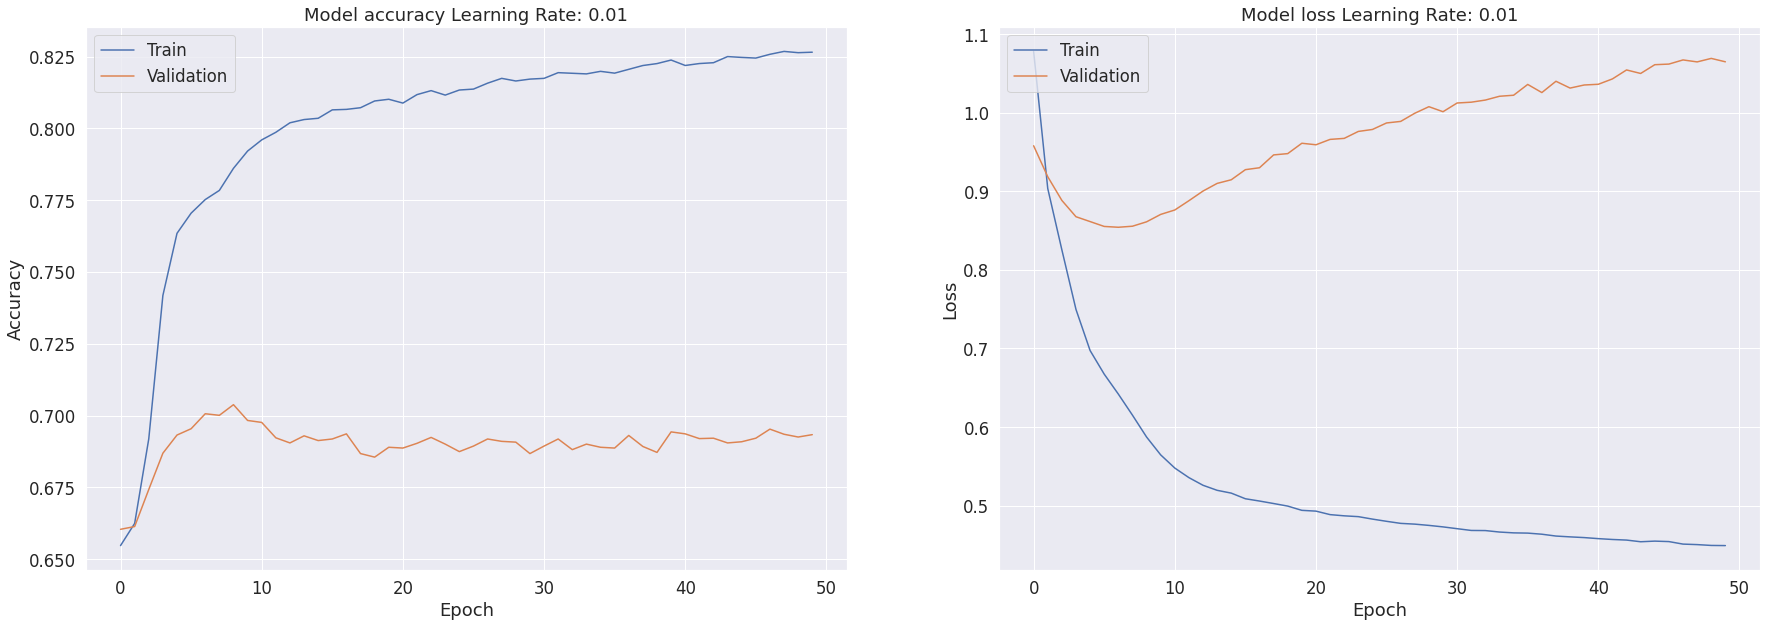

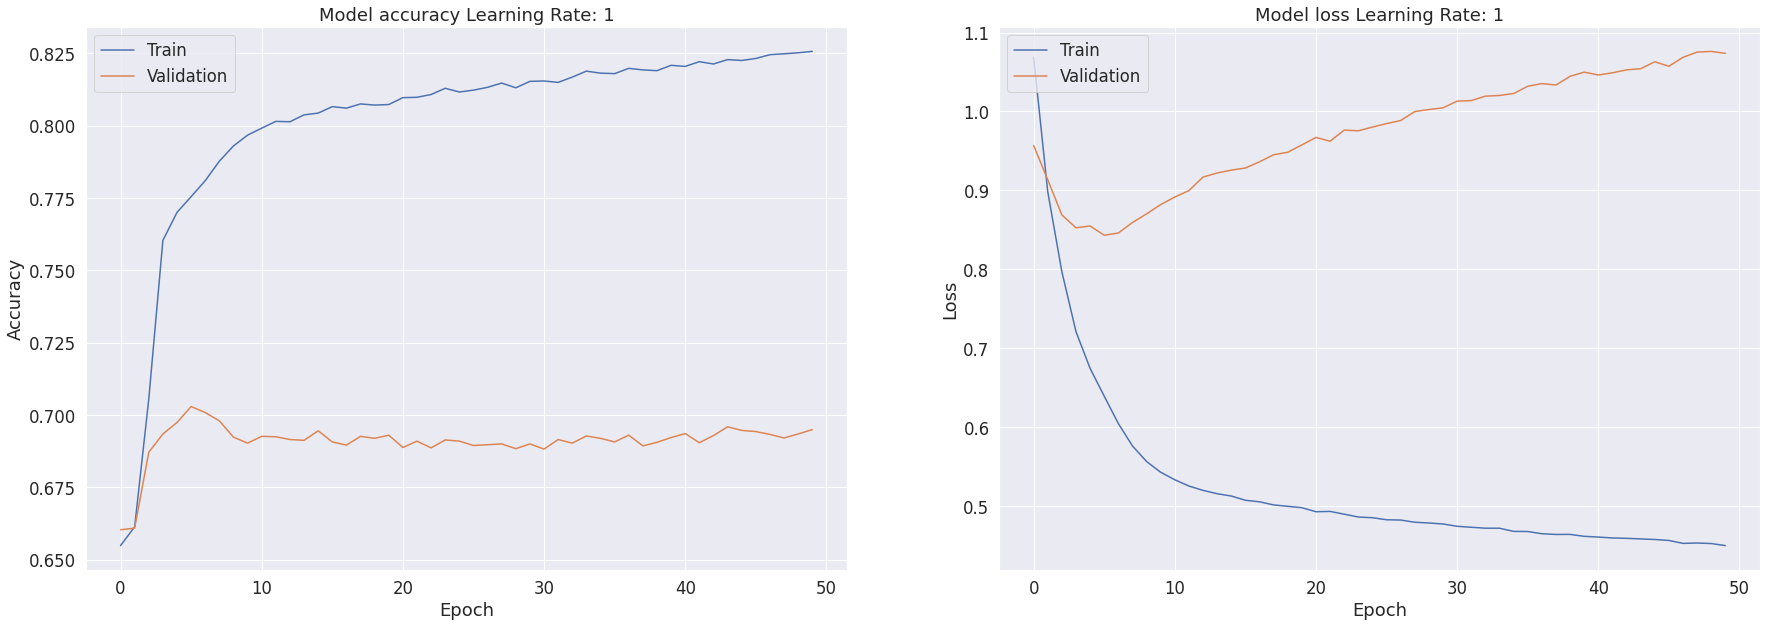

In [161]:
nnmodel_stat(history_lr1,"Learning Rate: 0.0001")
nnmodel_stat(history_lr2,"Learning Rate: 0.01")
nnmodel_stat(history_lr3,"Learning Rate: 1")

### 2. Training Performance: Batch Size

Batch size is understood as the number of point used to determine the gradient of the objective function. A larger batch size may yield to more accurate gradient calculation but overall reduce the gradient step depending on the data variance.

Batch Sized were varied in three values 160, 320, 640

*   Interesting pattern is observed were smaller batchsize of 160 yields faster modelling convergence as compared with batch size of larger number
*   Maximum accuracy numbers and minimum loss are comparable among the three batch size categories

Batch size of 160 is the optimal choice for training the model

In [16]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras import optimizers
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 6000

# This is fixed.
EMBEDDING_DIM = 16

# Number of Epoch to Test
epochs = 60

# Batch Size of NN
batch_size = [160,320,640]

######################### TEST 1 (for Batch 160) #########################
# Defining the NN Model Architecture (Learning Rate : 0.0001)
model_b1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_b1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_b1.summary()

######################### TEST 2(for Batch 320) ###########################
# Defining the NN Model Architecture (Learning Rate : 0.01)
model_b2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_b2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_b2.summary()

######################### TEST 3 (for Batch 640) ##############################
# Defining the NN Model Architecture (Learning Rate : 1)
model_b3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_b3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_b3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 16)             96000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 3, 16)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                1600      
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 97,668
Trainable params: 97,668
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 16)             96000     
______________________________

In [17]:
# Fitting the Model on the current data
history_b1 = model_b1.fit(X, Y, batch_size=batch_size[0], epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)
history_b2 = model_b2.fit(X, Y, batch_size=batch_size[1], epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)
history_b3 = model_b3.fit(X, Y, batch_size=batch_size[2], epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)

Epoch 1/60
410/410 [==============================] - 3s 7ms/step - loss: 1.0003 - accuracy: 0.6579 - val_loss: 0.9268 - val_accuracy: 0.6614
Epoch 2/60
410/410 [==============================] - 2s 5ms/step - loss: 0.8240 - accuracy: 0.6925 - val_loss: 0.8565 - val_accuracy: 0.6853
Epoch 3/60
410/410 [==============================] - 2s 5ms/step - loss: 0.7090 - accuracy: 0.7603 - val_loss: 0.8409 - val_accuracy: 0.6998
Epoch 4/60
410/410 [==============================] - 2s 5ms/step - loss: 0.6463 - accuracy: 0.7748 - val_loss: 0.8438 - val_accuracy: 0.6977
Epoch 5/60
410/410 [==============================] - 2s 5ms/step - loss: 0.6087 - accuracy: 0.7817 - val_loss: 0.8526 - val_accuracy: 0.7001
Epoch 6/60
410/410 [==============================] - 2s 5ms/step - loss: 0.5830 - accuracy: 0.7881 - val_loss: 0.8606 - val_accuracy: 0.6993
Epoch 7/60
410/410 [==============================] - 2s 5ms/step - loss: 0.5620 - accuracy: 0.7920 - val_loss: 0.8698 - val_accuracy: 0.6971
Epoch 

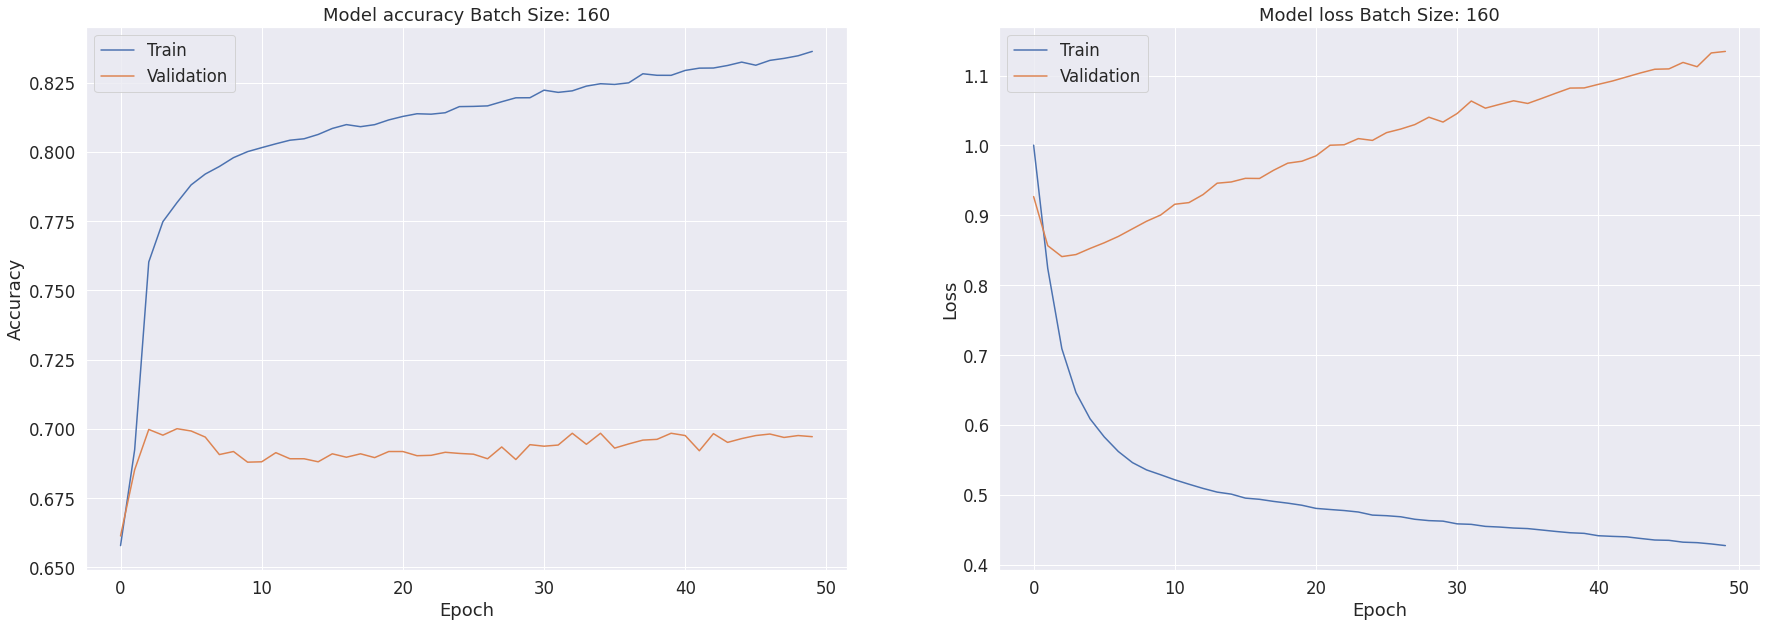

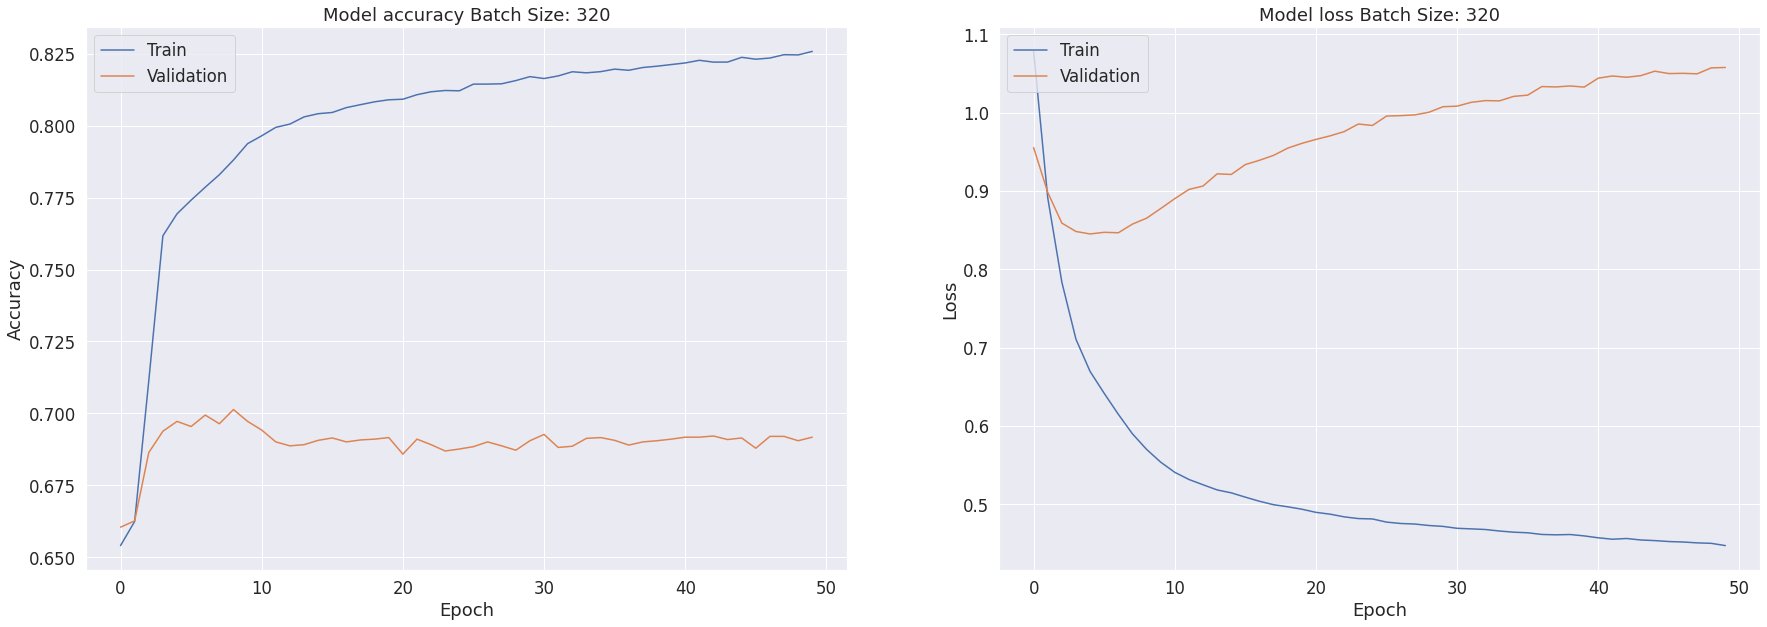

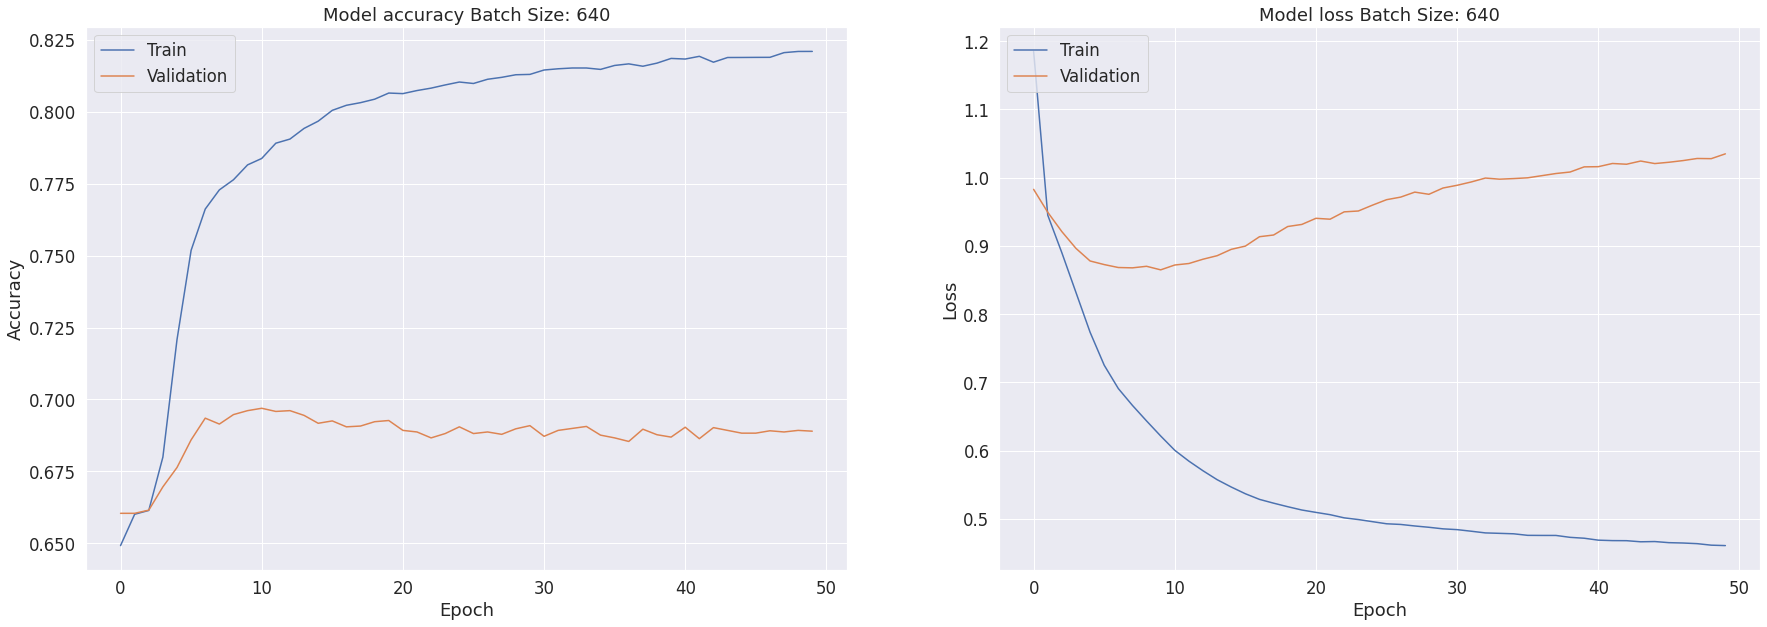

In [20]:
nnmodel_stat(history_b1,"Batch Size: 160")
nnmodel_stat(history_b2,"Batch Size: 320")
nnmodel_stat(history_b3,"Batch Size: 640")

## 3. Model Architecture : One way LSTM Architecture / Bidirectional LSTM / 2 Bidirectional LSTM 

Three difference types of hidden layer are tested for modelling.

1.   One-way LSTM
2.   Bidirectional LSTM
3.   Two Bidirectional LSTM 

Overall, the model performances are the sime with subtle difference.

For our purpose, I choose the 1 Bi-directional LSTM hidden layer.





In [21]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras import optimizers
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 6000

# This is fixed.
EMBEDDING_DIM = 16

# Number of Epoch to Test
epochs = 60

# Batch Size of NN
batch_size = 320

######################### TEST 1 (one way LSTM) #########################
# Defining the NN Model Architecture 
model_ar1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_ar1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ar1.summary()

######################### TEST 2(bi-directional LSTM) ###########################
# Defining the NN Model Architecture 
model_ar2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_ar2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ar2.summary()

######################### TEST 3 (two bi-directional LSTM) ##############################
# Defining the NN Model Architecture 
model_ar3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_ar3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ar3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 3, 16)             96000     
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 3, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
Total params: 96,836
Trainable params: 96,836
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 3, 16)             96000     
____________________________

In [22]:
# Fitting the Model on the current data
history_ar1 = model_ar1.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)
history_ar2 = model_ar2.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)
history_ar3 = model_ar3.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)

Epoch 1/60
205/205 [==============================] - 1s 7ms/step - loss: 1.0940 - accuracy: 0.6525 - val_loss: 0.9611 - val_accuracy: 0.6604
Epoch 2/60
205/205 [==============================] - 1s 5ms/step - loss: 0.9063 - accuracy: 0.6619 - val_loss: 0.9247 - val_accuracy: 0.6603
Epoch 3/60
205/205 [==============================] - 1s 5ms/step - loss: 0.8286 - accuracy: 0.6924 - val_loss: 0.8969 - val_accuracy: 0.6752
Epoch 4/60
205/205 [==============================] - 1s 5ms/step - loss: 0.7601 - accuracy: 0.7407 - val_loss: 0.8721 - val_accuracy: 0.6863
Epoch 5/60
205/205 [==============================] - 1s 5ms/step - loss: 0.7141 - accuracy: 0.7623 - val_loss: 0.8620 - val_accuracy: 0.6956
Epoch 6/60
205/205 [==============================] - 1s 5ms/step - loss: 0.6821 - accuracy: 0.7704 - val_loss: 0.8580 - val_accuracy: 0.6965
Epoch 7/60
205/205 [==============================] - 1s 5ms/step - loss: 0.6550 - accuracy: 0.7740 - val_loss: 0.8587 - val_accuracy: 0.7001
Epoch 

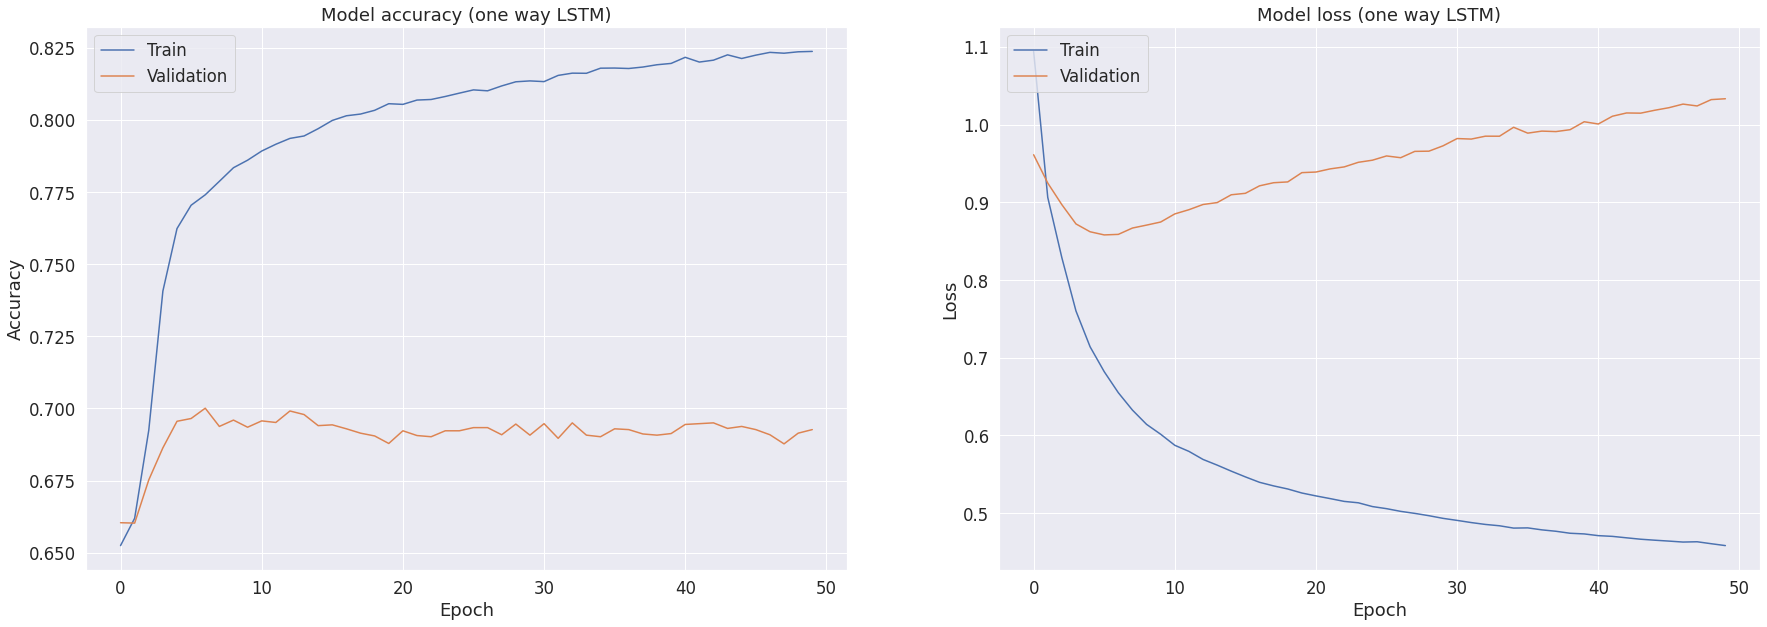

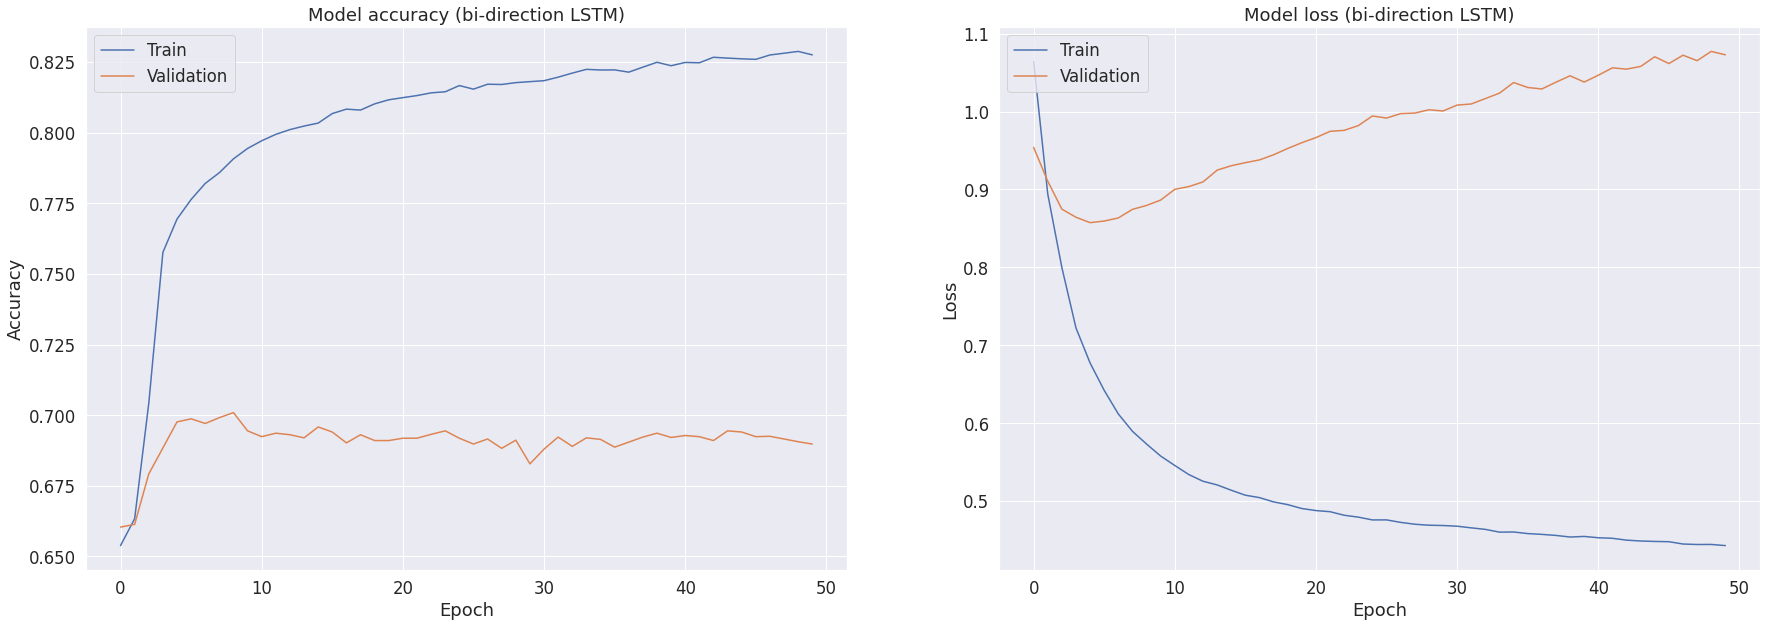

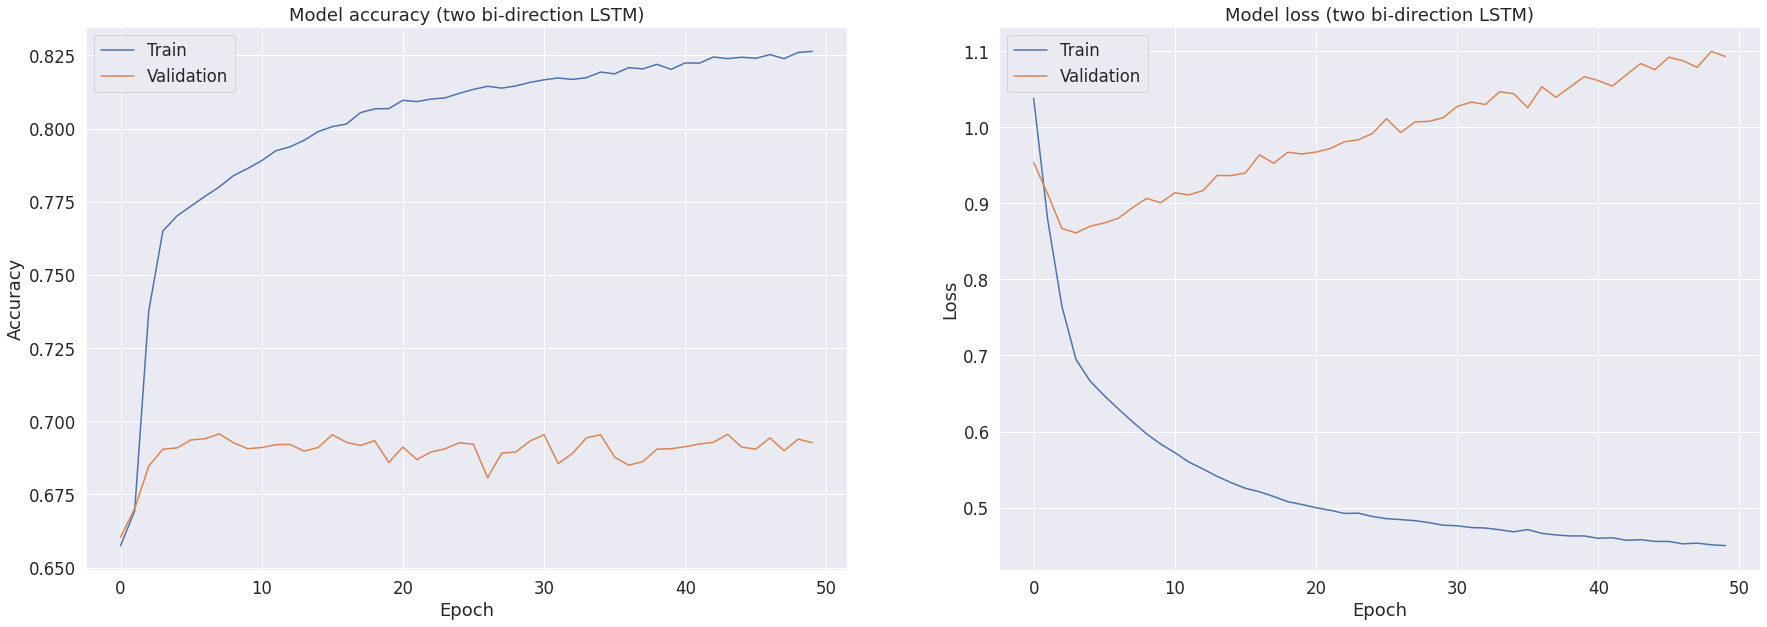

In [23]:
nnmodel_stat(history_ar1,"(one way LSTM)")
nnmodel_stat(history_ar2,"(bi-direction LSTM)")
nnmodel_stat(history_ar3,"(two bi-direction LSTM)")

## 4. Model Architecture: Number of nodes in hidden layer

On the bi-directional LSTM hidden layer, the nuumber of nodes were varied from 8 to 16 to 32 nodes. Besides some subtle changes in the convergence rate (higher number of nodes converges faster), the accuracy and loss function limits are fairly similar.

I choose to use 8 node hidden layer for modelling
** **

In [24]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras import optimizers
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 6000

# This is fixed.
EMBEDDING_DIM = 16

# Number of Nodes in LSTM layer
N_node = [8,16,32]

# Number of Epoch to Test
epochs = 60

# Batch Size of NN
batch_size = 320

######################### TEST 1 (Hidden Layer Node : 8) #########################
# Defining the NN Model Architecture (Learning Rate : 0.0001)
model_n1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(N_node[0])),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_n1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_n1.summary()

######################### TEST 2 (Hidden Layer Node : 16) ###########################
# Defining the NN Model Architecture (Learning Rate : 0.01)
model_n2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(N_node[1])),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_n2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_n2.summary()

######################### TEST 3 (Hidden Layer Node : 32) ##############################
# Defining the NN Model Architecture (Learning Rate : 1)
model_n3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(N_node[2])),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_n3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_n3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 3, 16)             96000     
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 3, 16)             0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 16)                1600      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 68        
Total params: 97,668
Trainable params: 97,668
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 3, 16)             96000     
____________________________

In [25]:
# Fitting the Model on the current data
history_n1 = model_n1.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)
history_n2 = model_n2.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)
history_n3 = model_n3.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)

Epoch 1/60
205/205 [==============================] - 2s 9ms/step - loss: 1.0730 - accuracy: 0.6535 - val_loss: 0.9515 - val_accuracy: 0.6604
Epoch 2/60
205/205 [==============================] - 1s 6ms/step - loss: 0.8912 - accuracy: 0.6635 - val_loss: 0.8992 - val_accuracy: 0.6622
Epoch 3/60
205/205 [==============================] - 1s 6ms/step - loss: 0.7968 - accuracy: 0.7033 - val_loss: 0.8712 - val_accuracy: 0.6807
Epoch 4/60
205/205 [==============================] - 1s 6ms/step - loss: 0.7229 - accuracy: 0.7547 - val_loss: 0.8586 - val_accuracy: 0.6866
Epoch 5/60
205/205 [==============================] - 1s 6ms/step - loss: 0.6772 - accuracy: 0.7691 - val_loss: 0.8523 - val_accuracy: 0.6945
Epoch 6/60
205/205 [==============================] - 1s 6ms/step - loss: 0.6464 - accuracy: 0.7745 - val_loss: 0.8492 - val_accuracy: 0.6987
Epoch 7/60
205/205 [==============================] - 1s 6ms/step - loss: 0.6202 - accuracy: 0.7791 - val_loss: 0.8502 - val_accuracy: 0.6935
Epoch 

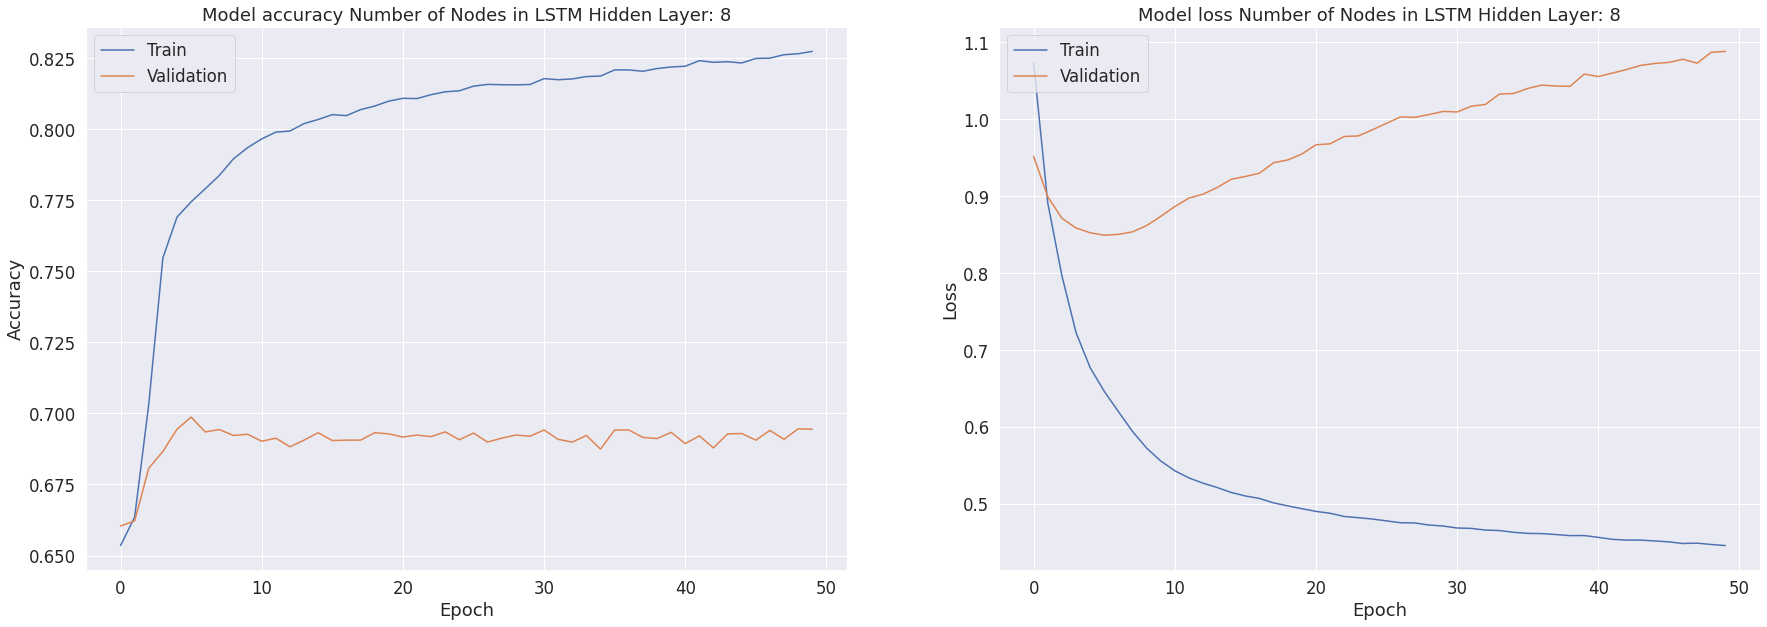

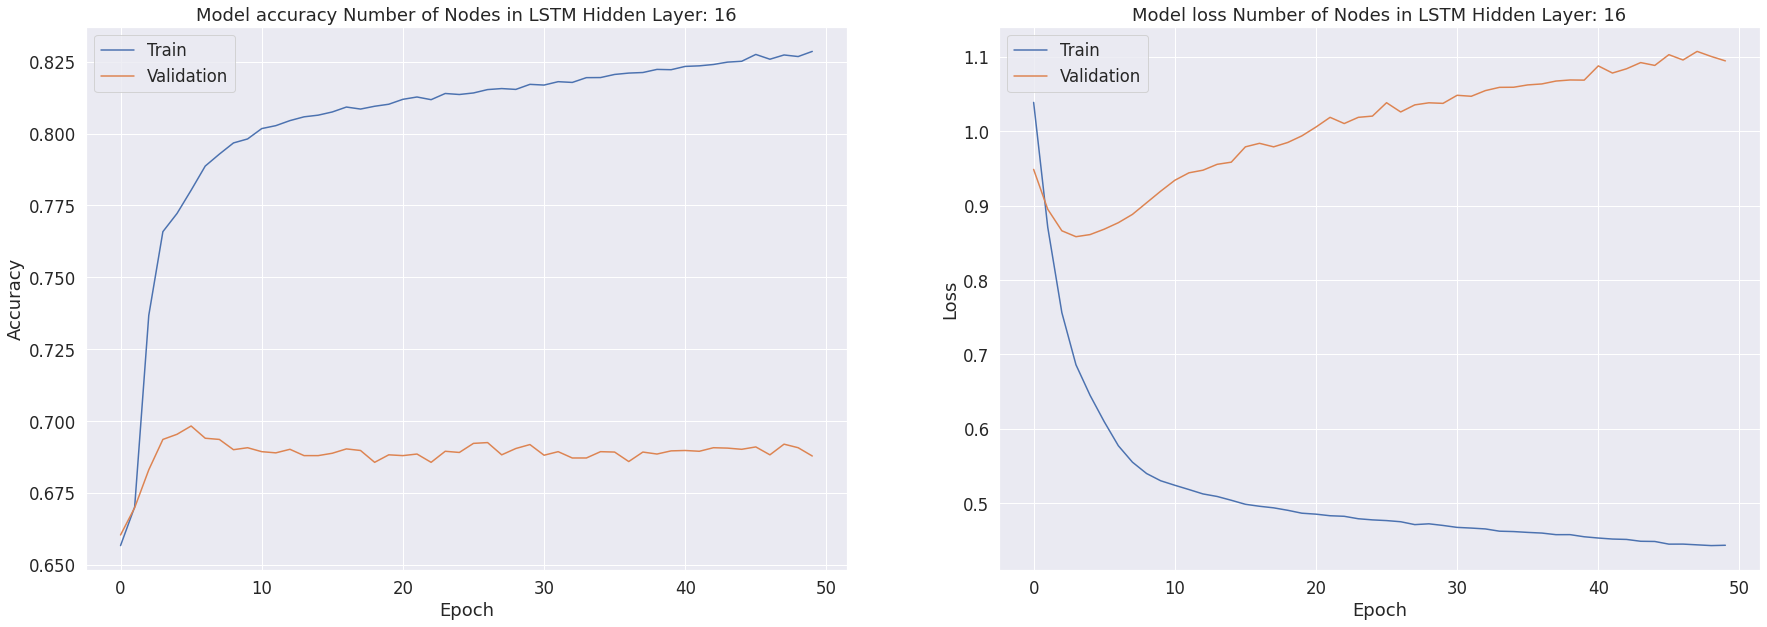

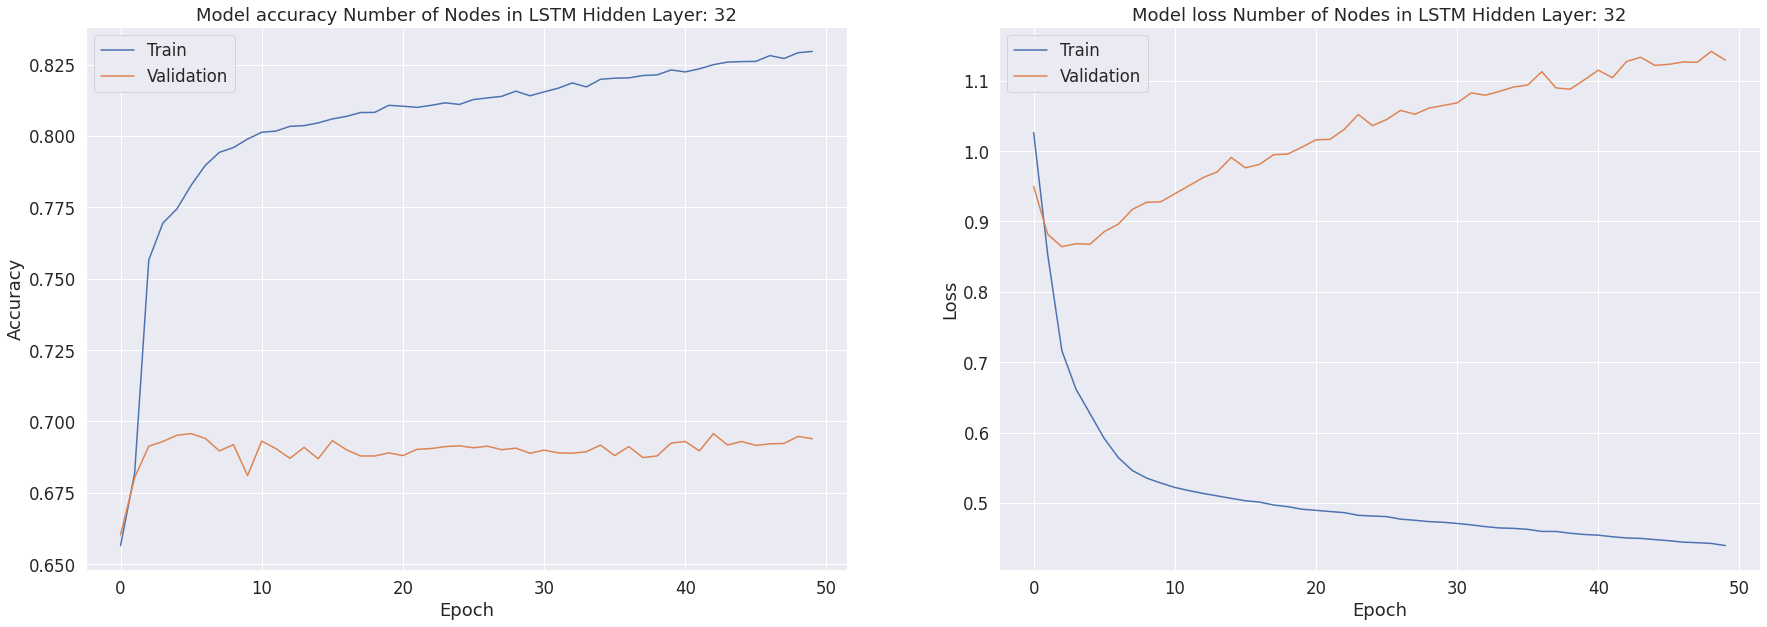

In [26]:
nnmodel_stat(history_n1,"Number of Nodes in LSTM Hidden Layer: 8")
nnmodel_stat(history_n2,"Number of Nodes in LSTM Hidden Layer: 16")
nnmodel_stat(history_n3,"Number of Nodes in LSTM Hidden Layer: 32")

##5. Model Architecture: Activation Function on Output Layer

Lastly, I test for the activation function choice on the output layer

1.   Softmax Function : Result fairly robust
2.   Tanh Function : Result are overall unstable 
3.   Sigmoid Function : Fairly similar results to softmax function with similar validation accuracy level and loss function values

Softmax function distributes probabilities across the outputs which aptly suits the nature of our training data.


In [29]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras import optimizers

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 6000

# This is fixed.
EMBEDDING_DIM = 16

# Number of Epoch to Test
epochs = 60

# Batch Size of NN
batch_size = 320

######################### TEST 1 (Learning Rate : 0.0001) #########################
# Defining the NN Model Architecture (Learning Rate : 0.0001)
model_ac1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_ac1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ac1.summary()

######################### TEST 2 (Learning Rate : 0.01) ###########################
# Defining the NN Model Architecture (Learning Rate : 0.01)
model_ac2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='tanh')
])
adam = optimizers.Adam(learning_rate=0.01)
model_ac2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ac2.summary()

######################### TEST 3 (Learning Rate : 1) ##############################
# Defining the NN Model Architecture (Learning Rate : 1)
model_ac3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='sigmoid')
])
adam = optimizers.Adam(learning_rate=0.01)
model_ac3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ac3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 3, 16)             96000     
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 3, 16)             0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 16)                1600      
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 68        
Total params: 97,668
Trainable params: 97,668
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 3, 16)             96000     
__________________________

In [30]:
# Fitting the Model on the current data
history_ac1 = model_ac1.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)
history_ac2 = model_ac2.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)
history_ac3 = model_ac3.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)

Epoch 1/60
205/205 [==============================] - 2s 11ms/step - loss: 1.0789 - accuracy: 0.6534 - val_loss: 0.9571 - val_accuracy: 0.6605
Epoch 2/60
205/205 [==============================] - 1s 7ms/step - loss: 0.8944 - accuracy: 0.6619 - val_loss: 0.9058 - val_accuracy: 0.6627
Epoch 3/60
205/205 [==============================] - 1s 7ms/step - loss: 0.7891 - accuracy: 0.7088 - val_loss: 0.8594 - val_accuracy: 0.6851
Epoch 4/60
205/205 [==============================] - 1s 7ms/step - loss: 0.7154 - accuracy: 0.7595 - val_loss: 0.8552 - val_accuracy: 0.6899
Epoch 5/60
205/205 [==============================] - 1s 7ms/step - loss: 0.6761 - accuracy: 0.7688 - val_loss: 0.8538 - val_accuracy: 0.6966
Epoch 6/60
205/205 [==============================] - 1s 7ms/step - loss: 0.6480 - accuracy: 0.7741 - val_loss: 0.8557 - val_accuracy: 0.6969
Epoch 7/60
205/205 [==============================] - 1s 7ms/step - loss: 0.6203 - accuracy: 0.7804 - val_loss: 0.8521 - val_accuracy: 0.7015
Epoch

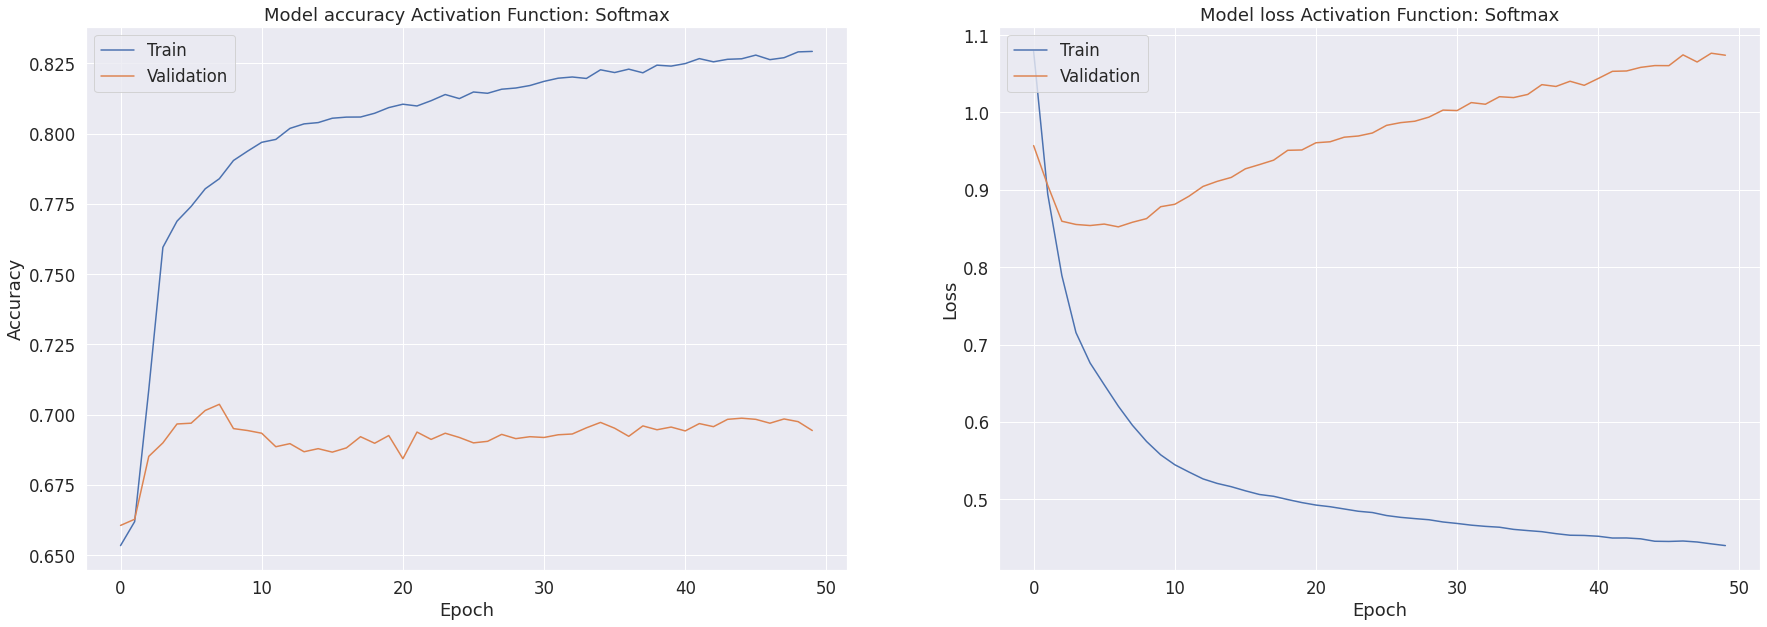

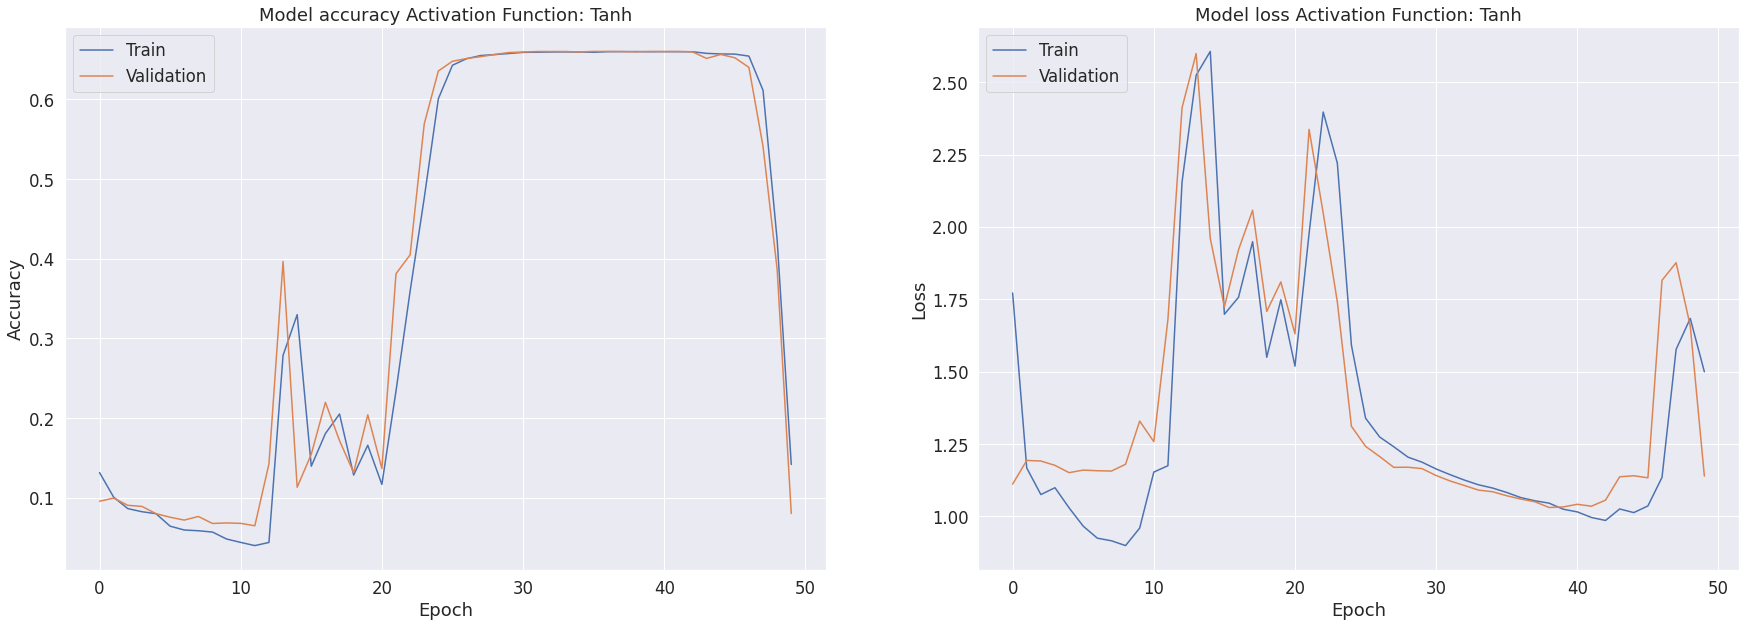

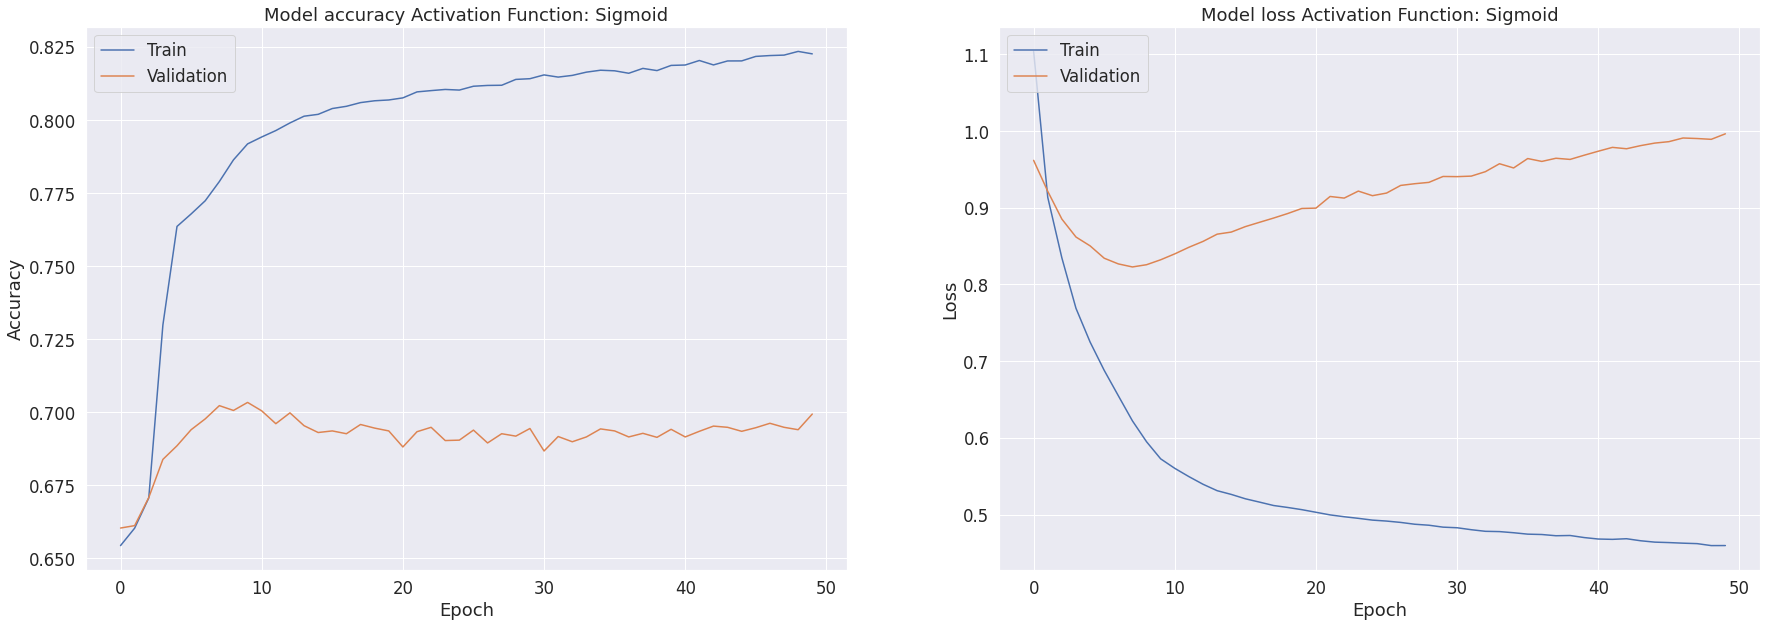

In [31]:
nnmodel_stat(history_ac1,"Activation Function: Softmax")
nnmodel_stat(history_ac2,"Activation Function: Tanh")
nnmodel_stat(history_ac3,"Activation Function: Sigmoid")

## Summary of Hypertuning Parameters

To summarize here are the hyper tunned parameter for our RNN network

1. Training Performance : Learning Rate of Model -->**0.01**
2. Training Performance : Batch Size -->**160**
3. Model Architecture : LSTM / Bidirectional LSTM / 2 Bidirectional LSTM -- > **Bi-direction LSTM**
4. Model Architecture : Number of Hidden Layer -->**8**
5. Model Architecture : Activation Output --> **softmax**
** **

## K-Fold CrossValidation Testing

Based on the hyper-tunned parameters, I now run a k-fold validation testing based on a 1/10th split of the training datasets with a reduced epoch of 10 iterations. The validation accuracy test scores are consistent and at 78 percent against the training accuracy of 81 percent. 

The accuarcy scores between training and validation sets are close suggesting that the modelling is reasonable fit without any overfitting problems

Looking at the Accuarcy and Loss graphs, I infer that the model has converged . The accuracy curve has reasonably flatten at 0.78 and similarily the loss function has been flattened at 0.625 

In [54]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
ttscores = []
histkfld = []

for i, (train_index, test_index) in enumerate(kfold.split(X,Y.argmax(1))):
  # The maximum number of words to be used. (most frequent)
  MAX_NB_WORDS = 6000
  # This is fixed.
  EMBEDDING_DIM = 16
  # Number of Epoch to Test
  epochs = 10
  # Batch Size of NN
  batch_size = 160
  ######################### TEST 1 (Learning Rate : 0.01) #########################
  # Defining the NN Model Architecture (Learning Rate : 0.01)
  model_kfld = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
  ])
  adam = optimizers.Adam(learning_rate=0.01)
  model_kfld.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model_kfld.fit(X[train_index], Y[train_index], validation_data=(X[test_index], Y[test_index]), batch_size=batch_size, epochs=epochs, shuffle = True)
  histkfld.append(history)
  # evaluate the model
  scores = model_kfld.evaluate(X[test_index], Y[test_index], verbose=0)
  scores_tt = model_kfld.evaluate(X[train_index], Y[train_index], verbose=0)
  print("Validation %s: %.2f%%" % (model_kfld.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
  ttscores.append(scores_tt[1] * 100)
print("Mean Train %.2f%% (+/- %.2f%%)" % (numpy.mean(ttscores), numpy.std(ttscores)))
print("Mean Validation %.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))


Epoch 1/10
410/410 [==============================] - 4s 9ms/step - loss: 1.0115 - accuracy: 0.6568 - val_loss: 0.9028 - val_accuracy: 0.6609
Epoch 2/10
410/410 [==============================] - 2s 6ms/step - loss: 0.8263 - accuracy: 0.6926 - val_loss: 0.7663 - val_accuracy: 0.7322
Epoch 3/10
410/410 [==============================] - 2s 6ms/step - loss: 0.7142 - accuracy: 0.7605 - val_loss: 0.7045 - val_accuracy: 0.7637
Epoch 4/10
410/410 [==============================] - 2s 6ms/step - loss: 0.6578 - accuracy: 0.7715 - val_loss: 0.6662 - val_accuracy: 0.7741
Epoch 5/10
410/410 [==============================] - 2s 6ms/step - loss: 0.6206 - accuracy: 0.7792 - val_loss: 0.6453 - val_accuracy: 0.7777
Epoch 6/10
410/410 [==============================] - 2s 6ms/step - loss: 0.5928 - accuracy: 0.7867 - val_loss: 0.6286 - val_accuracy: 0.7807
Epoch 7/10
410/410 [==============================] - 2s 6ms/step - loss: 0.5703 - accuracy: 0.7908 - val_loss: 0.6133 - val_accuracy: 0.7815
Epoch 

In [58]:
# Values for test and train accuracies for eahc fold iteration.
score_df = pd.DataFrame(data = [], columns = ['validation accuracy','train accuracy'])
score_df['validation accuracy'] = cvscores
score_df['train accuracy'] = ttscores
score_df

validation accuracy  train accuracy
0            78.426254       81.173706
1            78.371328       81.278992
2            77.986819       81.021118
3            77.890688       81.584167
4            77.890688       81.201172
5            78.577316       81.004333
6            77.712166       80.586243
7            77.231532       80.847168
8            76.981187       81.338787
9            77.750307       81.038195

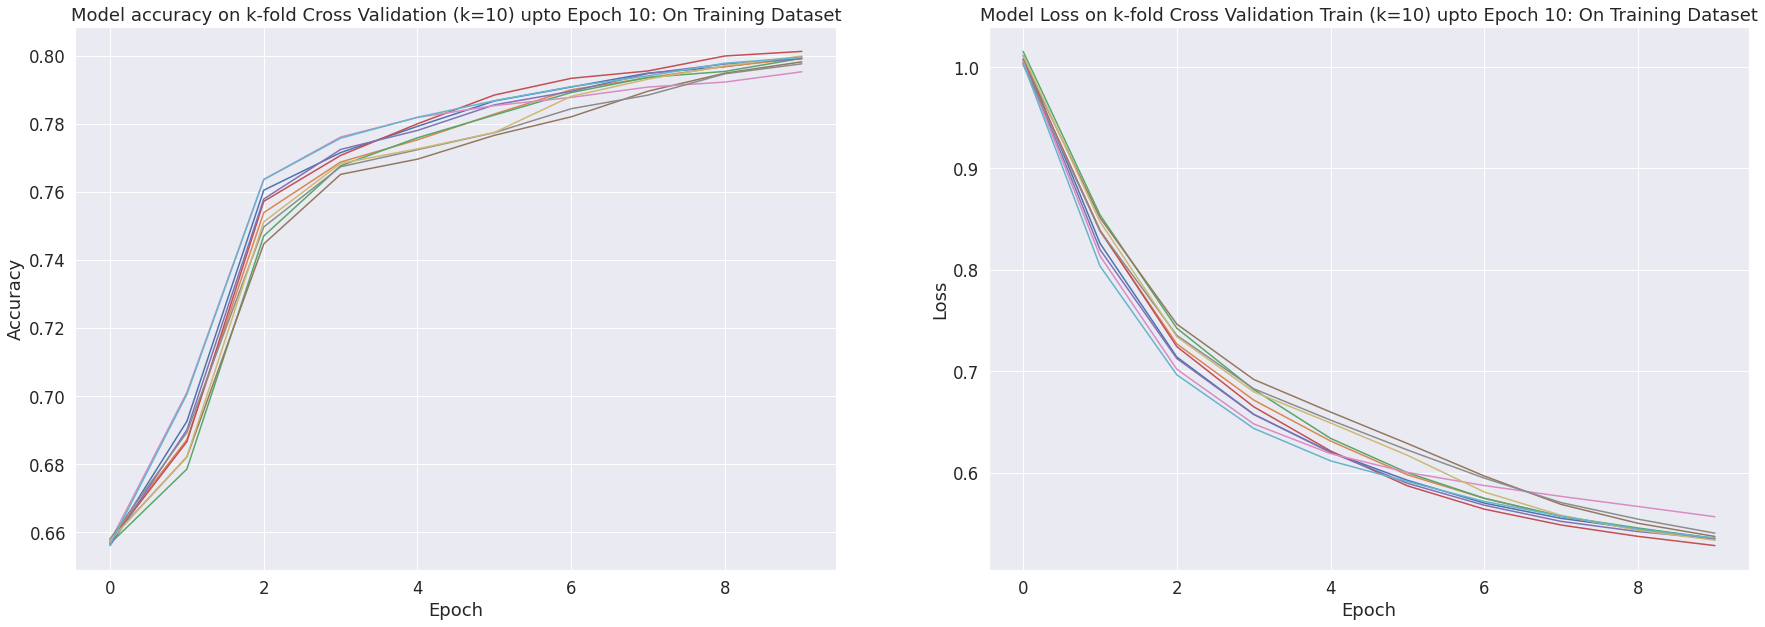

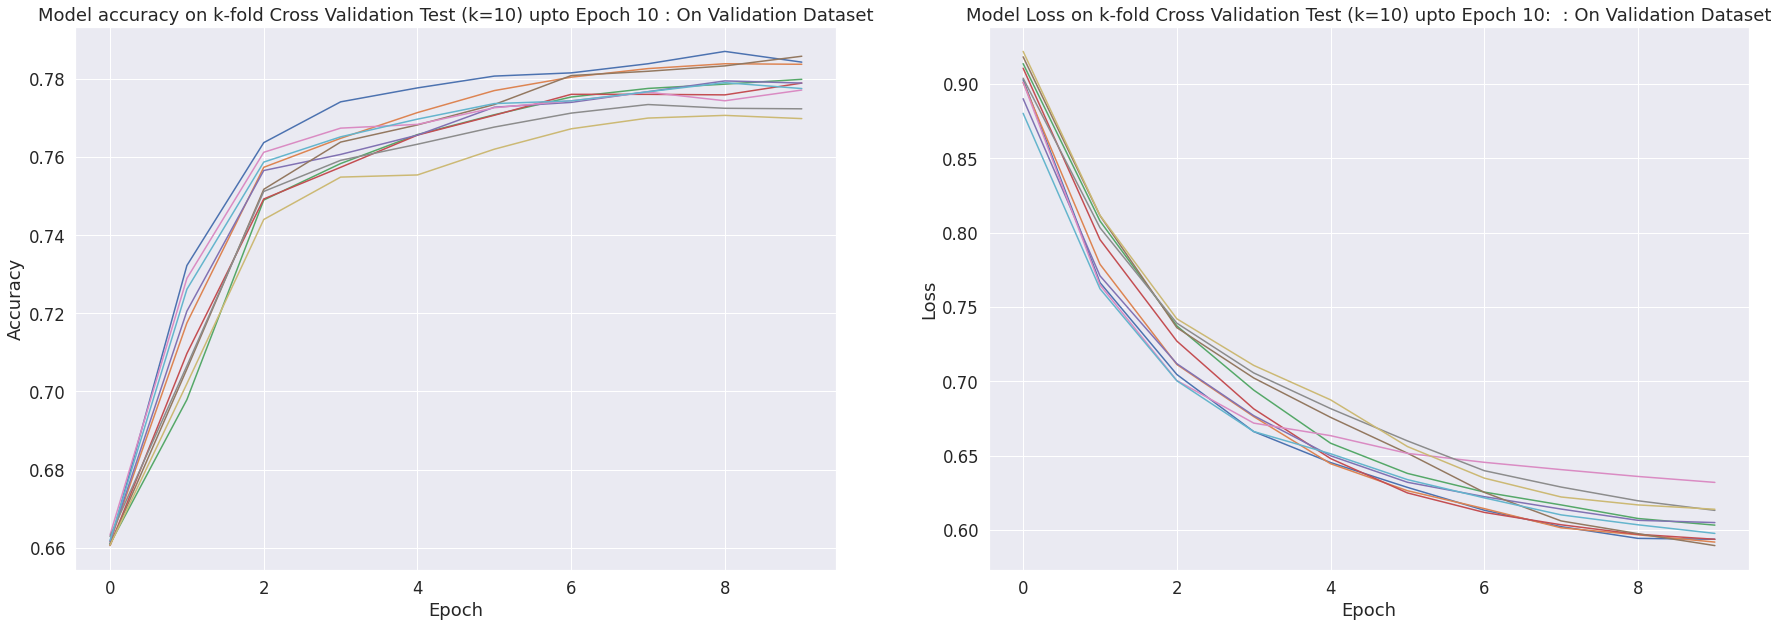

In [59]:
# Plots for Accuracy and Loss on each K-fold iteration (Training)
plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
for history_nn in histkfld:
  plt.plot(history_nn.history['accuracy'][0:50])
plt.title('Model accuracy on k-fold Cross Validation (k=10) upto Epoch 10: On Training Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
for history_nn in histkfld:
  plt.plot(history_nn.history['loss'][0:50])
plt.title('Model Loss on k-fold Cross Validation Train (k=10) upto Epoch 10: On Training Dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plots for Accuracy and Loss on each K-fold iteration (Validation)
plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
for history_nn in histkfld:
  plt.plot(history_nn.history['val_accuracy'][0:50])
plt.title('Model accuracy on k-fold Cross Validation Test (k=10) upto Epoch 10 : On Validation Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
for history_nn in histkfld:
  plt.plot(history_nn.history['val_loss'][0:50])
plt.title('Model Loss on k-fold Cross Validation Test (k=10) upto Epoch 10:  : On Validation Dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Demonstration of Model Prediction Output

Now that I have a working model which has converged within a reasonable range of accuracy 78% - 82%. Any more epoch training would cause the model to overfit and compromise on the validation accuracy in general. 

Now to apply the prediciton model, I design a function that uses the trained nn model as follows

*   Input to the function is a list of text (sequence of words) to be tested for speech error  
*   The function internally breaks the individual texts into three word strings **[previous word, word, next word]**, hot encodes and passes the hot encode vector into the nn model
*   The output vector is predicted. The word with the highest probability is collected for each three word vector.
*   After running through an individual text, the number of words identified with high probabiliy is compiled and assigned a confidence number based on word frequency. 1 (3 out of 3) indicates the word was detected three input vectors. Subsequenctly 0.67 (2 out of 3) and 0.33 (1 out of 3) are assigned for word detect 2 or 1 time respectively.

The output to this function is the detected word and its confidence level to be a speech error. If no word was detected the function returns the message 'NO ERROR DETECTED'.




In [0]:
def pred_conv(input,nnmodel):
  result = []
  for i,text in enumerate(input):
      nlp_text = [token.lower_ for token in nlp(text)]
      nlp_text = ["#"]+nlp_text+["#"]
      inpmat = []
      txtmat = []
      for ind in range(1,len(nlp_text)-1):
        inpmat.append(" ".join([nlp_text[ind-1],nlp_text[ind],nlp_text[ind+1]]))
        txtmat.append(nlp_text[ind])
      #print(inpmat)
      
      # Sequence tokenizing
      MAX_SEQUENCE_LENGTH = 3
      token_inpmat = tokenizer_inp.texts_to_sequences(inpmat)
      token_inpmat = sequence.pad_sequences(token_inpmat, maxlen=MAX_SEQUENCE_LENGTH)
      #print(token_inpmat)
      prb_outmat = nnmodel.predict(token_inpmat)
      #print(prb_outmat)
      outmat = [np.argmax(submat) for submat in prb_outmat]
      #print(txtmat)
      #print(outmat)
      cnt_word = []
      fnl_mat = []
      for i,rt in enumerate(outmat) :
        #print(i)
        if (rt == 3):
          cnt_word.append(nlp_text[i+2])
        elif (rt == 2):
          cnt_word.append(nlp_text[i+1])
        elif (rt == 1):
          cnt_word.append(nlp_text[i])
      uniq_cnt_word = np.unique(cnt_word)      
      for wrd in uniq_cnt_word:
        #print(text,"\t---------->\t",wrd," with probability ",round(cnt_word.count(wrd)/3,2))
        fnl_mat.append({wrd : round(cnt_word.count(wrd)/3,2)})
      if len(uniq_cnt_word) == 0 :
        fnl_mat = ["NO ERROR DETECTED"]
      result.append(fnl_mat)
  return result

In [150]:
# Demonstration of Output
example_text = trainset_noise_df['noisy_speech_edit'][3450:3500].values
output_pred = pred_conv(example_text,model_nn)
for i,txt in enumerate(example_text):
  print(txt,"\t---------->\t\t\t",output_pred[i][0])

i m pretty gif with money 	---------->			 {'gif': 1.0}
i m pretty careful with money 	---------->			 {'careful': 0.67}
this is a central issue 	---------->			 {'a': 0.67}
this is the central issues 	---------->			 {'issues': 0.67}
we will not tolerate it 	---------->			 NO ERROR DETECTED
we would not tolerate that 	---------->			 NO ERROR DETECTED
making is also very important 	---------->			 NO ERROR DETECTED
mr dowling yesterday dismissed criticism 	---------->			 {'dowling': 1.0}
mr darling yesterday dismissed criticism 	---------->			 {'darling': 1.0}
it was just appalling look 	---------->			 {'look': 0.67}
you must always attempt to raise the butt 	---------->			 {'butt': 0.67}
he must always attempt to raise the bar 	---------->			 NO ERROR DETECTED
this represents a tough game for us 	---------->			 NO ERROR DETECTED
do i have a favourite 	---------->			 {'favourite': 0.67}
it comes from reflection of thinking 	---------->			 {'of': 0.67}
strikers lights go to the ground 	-----

## Testing on Untrained Text and Sentences

I now evaluate the RNN modelling on untrained sentences instead of three word vectors. I set upto 10% (989 sentences) as test sentences and run model training on the remaining sentences. The accuracy score drops to 71% with a loss of 0.84, against k-fold validation accuarcy of 78%. This can be attributed due to the limited data sample (approximately 9000 speech sentences) in total used for training.

When cross validating with untrained text

1. Out of 989 error words, 620 are predicted with error  
2. Approximately 41% sentences are predicted with no speech error. This number is overall larger indicating a drop in accurate prediction    
3.  Word distribution is overall different between the input and predicted text. Word frequency of top 10 words is different. However, some similarity can be seen in the word cloud distibution such as with 'well', 'find', 'edinboro'.




Possible a much large data sample could provide training on a large variety of unique word and accomodate for various word context that are found.

In [0]:
# Reading Inputs and Outputs
noisy_mat = trainset_noise_df['noisy_speech_edit'].values
noisy_detect_mat = trainset_noise_df['noisy_speech_edit_detect'].values

# Shuffle Index
sfindex = np.arange(0,len(noisy_mat))
np.random.shuffle(sfindex)

# Test and Train
train_sfindex = sfindex[:9000]
test_sfindex = sfindex[9001:]

In [128]:
# Array for separating train and test texts
train_noisy_mat = []
train_noisy_detect_mat = []
test_noisy_mat = []
test_noisy_detect_mat = []

# Creating test and train input and output matrix
for inx in train_sfindex :
  train_noisy_mat.append(noisy_mat[inx])
  train_noisy_detect_mat.append(noisy_detect_mat[inx])

for inx in test_sfindex :
  test_noisy_mat.append(noisy_mat[inx])
  test_noisy_detect_mat.append(noisy_detect_mat[inx])

print("Size of train Matrix: ",len(train_noisy_mat))
print("Size of test Matrix: ",len(test_noisy_mat))

Size of train Matrix:  9000
Size of test Matrix:  938


In [129]:
# Preparing three string inputs for Neural Network using Subsampling
train_nn_input_mat = []
for i,_ in enumerate(train_noisy_mat):
  orig_text   = train_noisy_mat[i]
  train_nn_input_mat  = np.append(train_nn_input_mat,input_split(orig_text,100), axis = 0)

# Preparing dummy array output for Neural Network using Subsampling
train_nn_output_loc_mat = []
for i,_ in enumerate(train_noisy_mat):
  orig_text   = train_noisy_mat[i]
  detect_text = train_noisy_detect_mat[i]
  if (i == 0) :
    train_nn_output_loc_mat = output_mat_split(detect_text,orig_text,100)
  else :
    jk = output_mat_split(detect_text,orig_text,100)
    if not jk:
      print('this is empty ',i) 
    train_nn_output_loc_mat = np.append(train_nn_output_loc_mat,output_mat_split(detect_text,orig_text,100), axis = 0)

print("Size of input Matrix: ",train_nn_input_mat.shape)
print("Size of output Matrix 4 vector: ",train_nn_output_loc_mat.shape)

Size of input Matrix:  (65979,)
Size of output Matrix 4 vector:  (65979, 4)


In [139]:
# Preparing three string inputs for Neural Network using Subsampling
test_nn_input_mat = []
for i,_ in enumerate(test_noisy_mat):
  orig_text   = test_noisy_mat[i]
  test_nn_input_mat  = np.append(test_nn_input_mat,input_split(orig_text,100), axis = 0)

# Preparing dummy array output for Neural Network using Subsampling
test_nn_output_loc_mat = []
for i,_ in enumerate(test_noisy_mat):
  orig_text   = test_noisy_mat[i]
  detect_text = test_noisy_detect_mat[i]
  if (i == 0) :
    test_nn_output_loc_mat = output_mat_split(detect_text,orig_text,100)
  else :
    test_nn_output_loc_mat = np.append(test_nn_output_loc_mat,output_mat_split(detect_text,orig_text,100), axis = 0)

print("TEST: Size of input Matrix: ",test_nn_input_mat.shape)
print("TEST: Size of output Matrix 4 vector: ",test_nn_output_loc_mat.shape)

TEST: Size of input Matrix:  (6834,)
TEST: Size of output Matrix 4 vector:  (6834, 4)


In [130]:
# Hot encoding input
MAX_SEQUENCE_LENGTH = 3
train_X = tokenizer_inp.texts_to_sequences(train_nn_input_mat)
train_X = sequence.pad_sequences(train_X, maxlen=MAX_SEQUENCE_LENGTH)

#X = X/len(word_index_inp)
train_X=train_X.astype('float')
train_Y= train_nn_output_loc_mat#.astype('float')

print('Shape of data X tensor:', train_X.shape)
print('Shape of data Y tensor:', train_Y.shape)

Shape of data X tensor: (65979, 3)
Shape of data Y tensor: (65979, 4)


In [141]:
# Hot encoding input
MAX_SEQUENCE_LENGTH = 3
test_X = tokenizer_inp.texts_to_sequences(test_nn_input_mat)
test_X = sequence.pad_sequences(test_X, maxlen=MAX_SEQUENCE_LENGTH)

#X = X/len(word_index_inp)
test_X=test_X.astype('float')
test_Y= test_nn_output_loc_mat#.astype('float')

print('Shape of data X tensor:', test_X.shape)
print('Shape of data Y tensor:', test_Y.shape)

Shape of data X tensor: (6834, 3)
Shape of data Y tensor: (6834, 4)


In [131]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras import optimizers

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 6000

# This is fixed.
EMBEDDING_DIM = 16

# Number of Epoch to Test
epochs = 10

# Batch Size of NN
batch_size = 160

######################### TEST 1 (Learning Rate : 0.0001) #########################
# Defining the NN Model Architecture (Learning Rate : 0.0001)
model_nn = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn.summary()

# Fitting the Model on the current data
model_nn.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, shuffle = True, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 16)             96000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 3, 16)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 97,668
Trainable params: 97,668
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
413/413 [==============================] - 2s 5ms/step - loss: 1.0055 - accuracy: 0.6567
Epoch 2/10
413/413 [==============================] - 2s 5ms/step - loss: 0.8377 - accuracy: 0.6859
Epoch 3/10
413/413 [============================

In [147]:
score = model_nn.evaluate(test_X, test_Y, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy score:', score[1])

Test loss score: 0.8364709615707397
Test accuracy score: 0.7121744155883789


In [202]:
# Demonstration of Output
example_text = test_noisy_mat
output_pred = pred_conv(example_text,model_nn)
for i,txt in enumerate(example_text):
  print(txt,"\t\t\t---------->\t\t\t",output_pred[i])

we went straight into the bedroom 			---------->			 ['NO ERROR DETECTED']
eleven strong and every shape and form 			---------->			 [{'eleven': 0.67}]
the partnership process house during the summer 			---------->			 ['NO ERROR DETECTED']
football is a passion for men 			---------->			 ['NO ERROR DETECTED']
here to the post office is missed the fight 			---------->			 [{'fight': 0.33}, {'is': 0.67}]
it would be a referee 			---------->			 ['NO ERROR DETECTED']
the hoop is that the outcome will be equally successful 			---------->			 ['NO ERROR DETECTED']
yesterday mr hague dismissed the pole 			---------->			 [{'pole': 0.67}]
does the name matta 			---------->			 [{'matta': 0.67}]
that was a struggle 			---------->			 ['NO ERROR DETECTED']
is there a waiting list 			---------->			 ['NO ERROR DETECTED']
you asked the question 			---------->			 [{'asked': 0.33}, {'you': 0.67}]
fast the program was unbalanced 			---------->			 [{'fast': 0.67}]
disruption will be kept to a minimum 			------

In [207]:
# Number of unique detect words in Input 
input_word = []
for txt in test_noisy_detect_mat:
  mat = txt.split()
  for elm in mat:
    if elm != 'xxxxxx':
      input_word.append(elm)

# Number of word recognized as error from prediction
output_word = []
error_count = 0
for dct in output_pred:
  for x in dct:
  #print(list(dct))
    if (x == 'NO ERROR DETECTED'):
      error_count = error_count + 1
    if (x != 'NO ERROR DETECTED'):
      output_word.append(list(x.keys())[0])
print("Number of text recognized as having no errors: {} out of {}".format(error_count,len(test_noisy_mat)))
print("Number of input detect words identified : {} ". format(len(input_word)))
print("Number of output detect words identified : {} ". format(len(output_word)))

Number of text recognized as having no errors: 408 out of 938
Number of input detect words identified : 938 
Number of output detect words identified : 620 


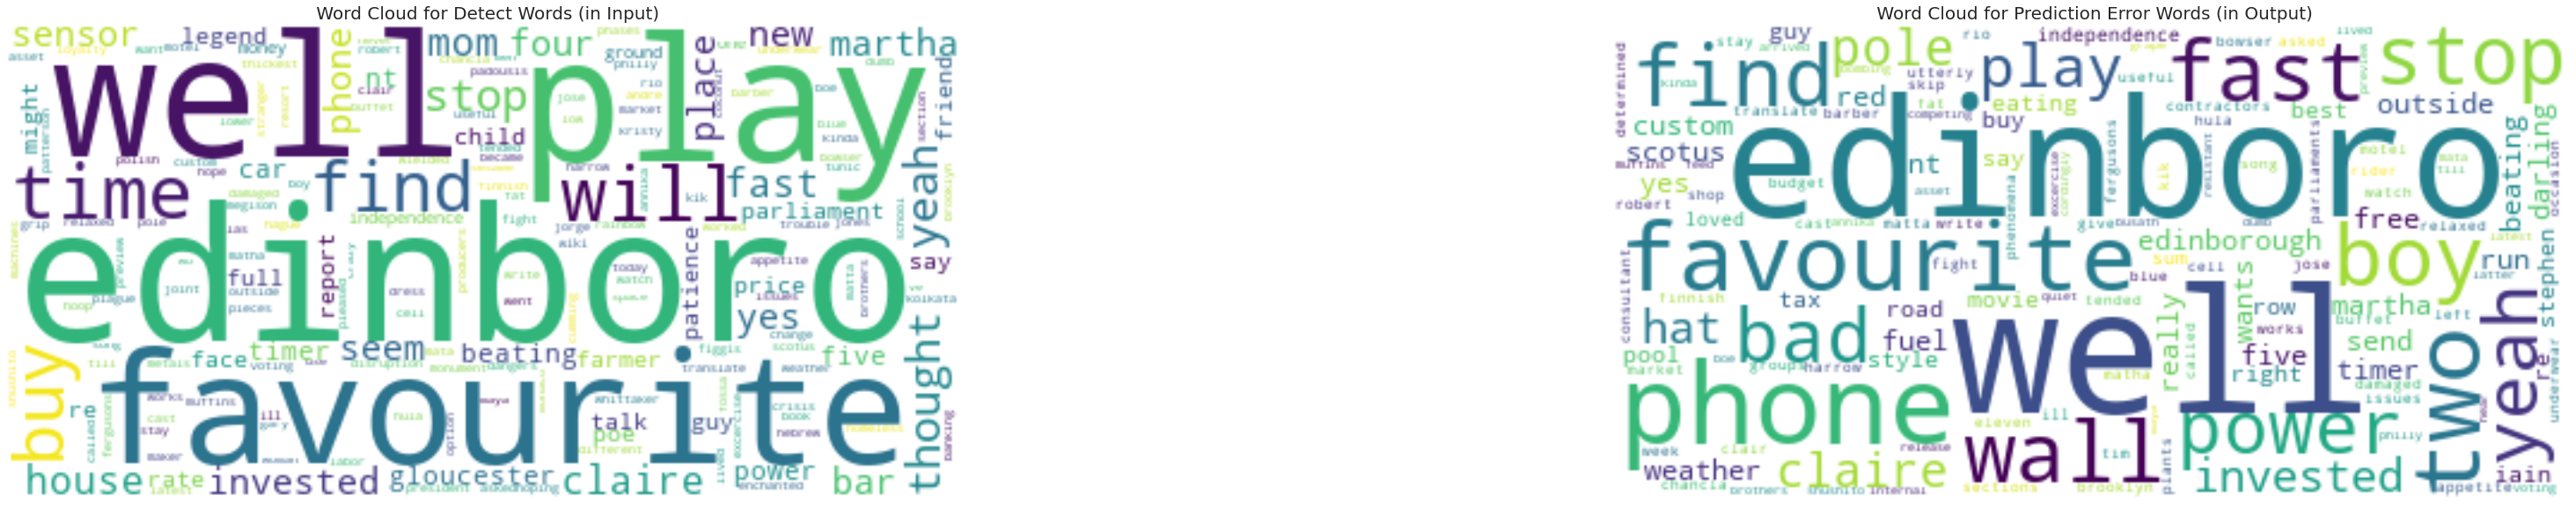

In [213]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud_inp = WordCloud(background_color="white").generate(" ".join(input_word))
wordcloud_out = WordCloud(background_color="white").generate(" ".join(output_word))
plt.figure(figsize=(60,10))

plt.subplot(1, 2, 1)
# Display the generated image:
plt.imshow(wordcloud_inp, interpolation='bilinear')
plt.axis("off")
plt.title(" Word Cloud for Detect Words (in Input)", fontsize = 20)

plt.subplot(1, 2, 2)
# Display the generated image:
plt.imshow(wordcloud_out, interpolation='bilinear')
plt.axis("off")
plt.title(" Word Cloud for Prediction Error Words (in Output)", fontsize = 20)

plt.show()

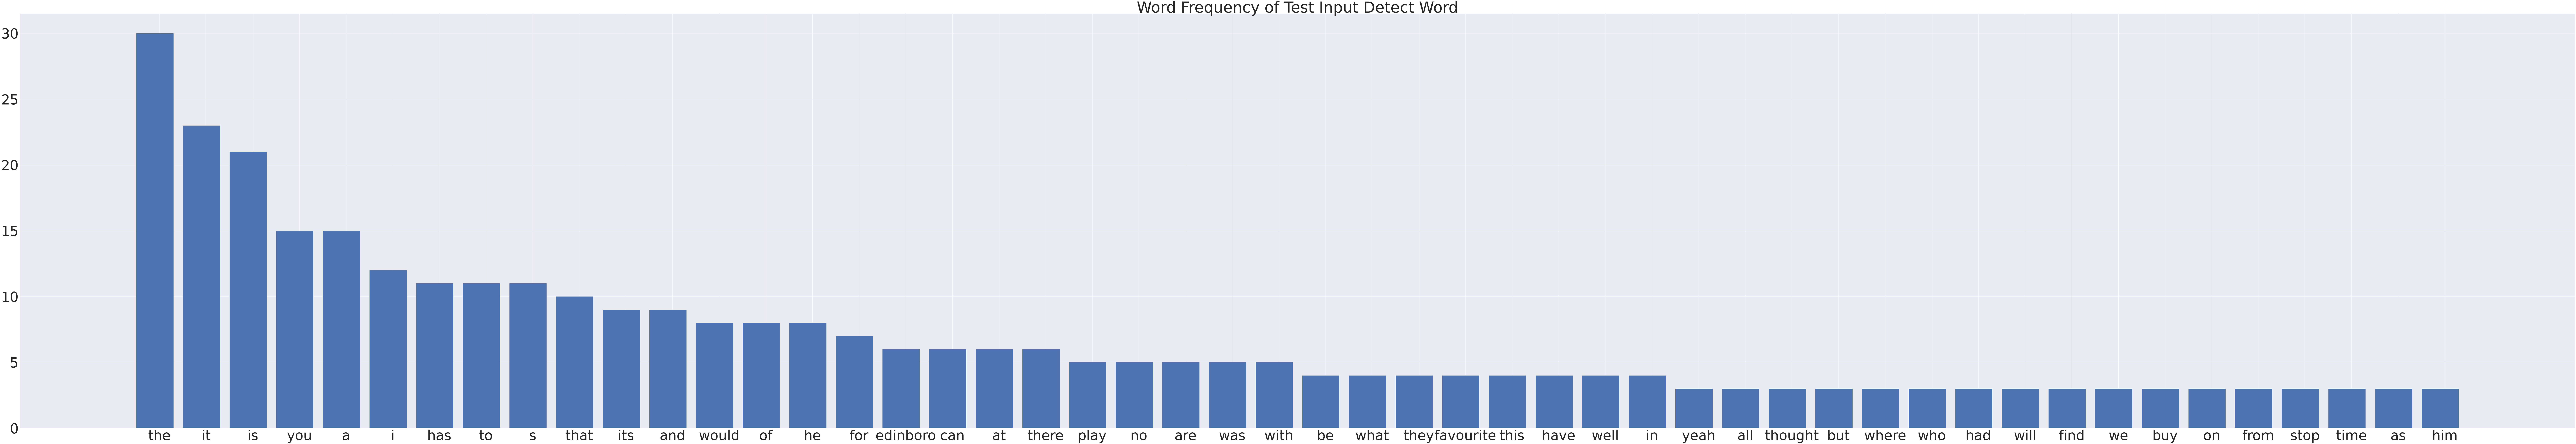

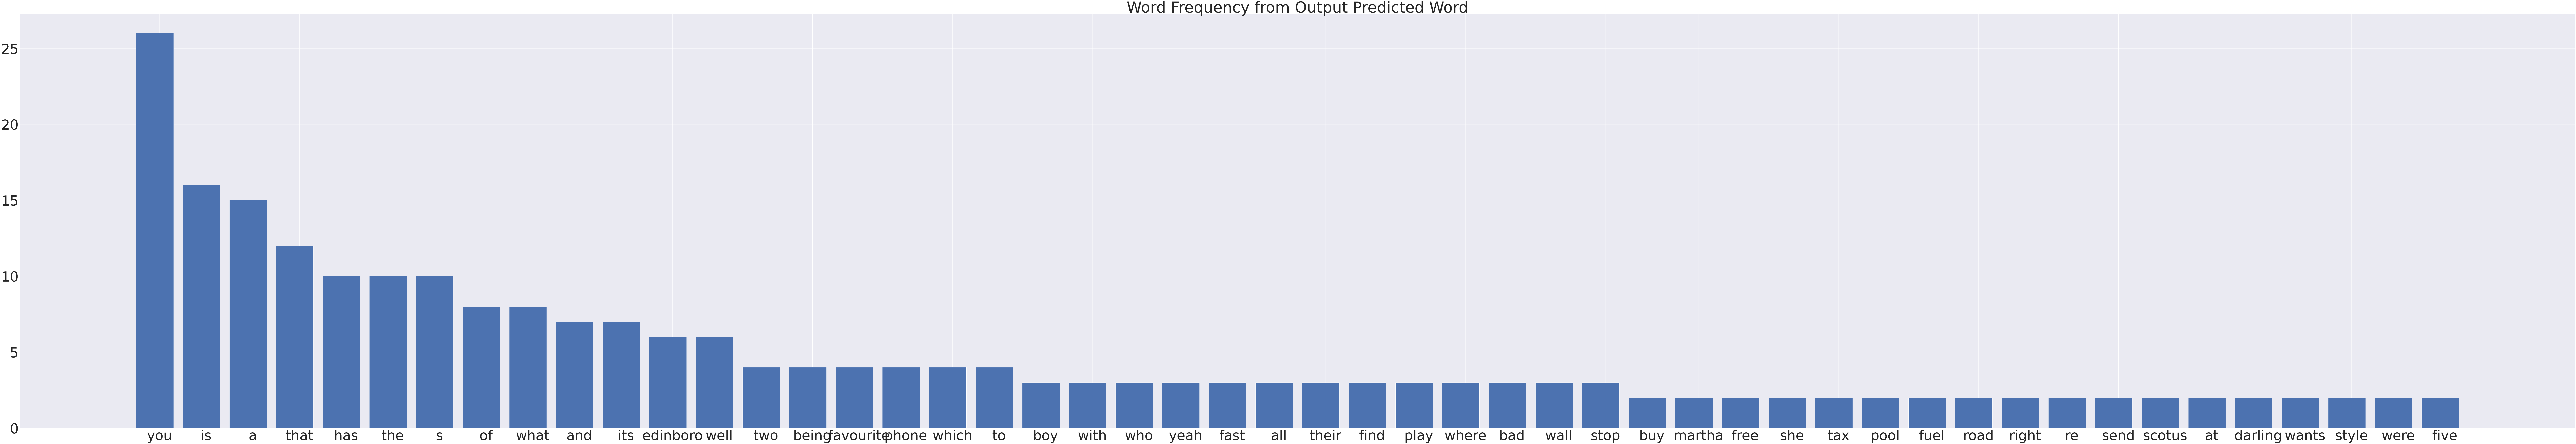

In [212]:
# Word Frequency for Clean Speeches
plt.figure(figsize=(300,50))

#plt.hist(cln_speech_mat)
word_list = input_word
counts = Counter(word_list)
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort][0:50]
values = np.array(values)[indSort][0:50]

indexes = np.arange(len(labels))
bar_width = 0.1
plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)
plt.xticks(fontsize=90) 
plt.yticks(fontsize=90) 
plt.title("Word Frequency of Test Input Detect Word",fontsize=100)
plt.show()

# Word Frequency for Noisy Speeches
plt.figure(figsize=(300,50))

#plt.hist(cln_speech_mat)
word_list = output_word
counts = Counter(word_list)
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort][0:50]
values = np.array(values)[indSort][0:50]

indexes = np.arange(len(labels))
bar_width = 0.1
plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)
plt.xticks(fontsize=90) 
plt.yticks(fontsize=90) 
plt.title("Word Frequency from Output Predicted Word",fontsize=100)
plt.show()

#Summary

I summarize the model based on the questionaires below.

**Describe your model in detail?**

In this notebook, I propose a model to predict errors in speech recognition text played with low, moderate to strong background noise. Most of the audio speech occuring in real world is mostly coupled with some background noise which can lead to incorrect translations. It could be a mis-translation of a voice command, a speech, movie subtitle etc. Using NLP and deep learning flows, I build a speech error prediction model. This model takes a speech translated text and outputs possible error words associated to the texts.

For modelling purpose, I choose the Recurrent Neural Network(RNN) framework with one bi-direction LSTM hidden layer.

Speech converted texts are subsampled into three word vectors containing the current scanned word, previous and next word. Each given sentences is subsampled and feed to the model as input. In this fashion we increase the training sample for wording errors and bring the word position information in modelling. 

The model output is a 4 element vector containing error probabilities based on the word positioning in the three word vector. Based on this information a list of word with error probabilities within a sentence is constructed.

**Why you chose it ?**

One major benefit of RNN type models in NLP based modelling is its ability to deal with sequential information. Since in our case, we are dealing with sequence of words where the combination and positioning of words matters, the RNN or LSTM based neural network helps in capture those dependencies.

**Why it works**

The modelling of the RNN is based of speech conversion samples from noisy audio clips. In our case, statistically we find more number of case where one word was mistranslated into another word. This approach helps in simplifying the modelling to simple wording errors rather than large textual error (less than 5% cases). 

Also by using the three word subsampling approach our modelling is exposed to more cases of wording errors along with word positioning and context. 

**What problem it solves**

Our model predicts possible wording errors in speech translation as a result of background noises. It also provided a error confidence level with the associated word 

**How it will run in a production like environment**

In a production enviroment, this model will be attached to the speech recognition tool. As an audio speech is translated, the textual content is sent to this model as inputs of 3 word vectors. The error prediction is carried out and word with errors are highlighted based on their confidence level. 

A trained speech correction model (text recommendation) or a grammer correction model can be added to operated on the predicted word providing corrections to the overall speech translation.

**What would you need to do to maintain it going forward?**

The challenge for the modelling scheme is to propagate the prediction errors to the model on untrained data (real world scenario). One possible way would be to apply background noise filtering externally from the audio clips and apply speech recognition tool to build a clean speech version. The filtering can be varied from low, mild to harsher cleanup forming an ensemble based modelling. 

If a translation is identified as having no speech error, it shall be passed as the most accurate speech translation. The remaining speech translation can be stored and be effectively used for training the model in production run.


## Limitation

I list the limitations on the NLP based model proposed here

1. The underlying assumption is that only the presence of noise creates speech recognition error. However, speech text errors can also be made by various sources such as mis-pronounciations, language accent, speaker voice quality etc. This implies that the clean speech text may not always yield a good text to compare our modelled noisy texts.
2. The input to RNN network only contains the previous and next words (3 word string in total). If a larger dataset is available, the bi-gram or tri-gram wording can also be included to provide more contextual information of the word and hence improve the prediction accuracy.
3. To increase the accuracy of our model prediction, a much larger set of speech texts should be used. In total only 5660 unique token (words) are taken into account. For a better generalization of the model, a large volume of speech to text can be included in our modelling.
4. Our model is based on one-word error presumption. As we have shown, multiple cases of errors were found, where one word could be mis-translated into multiple words and vice-versa.
5. Most of the mistranslations are for prepositions and articles word that are higher in word frequency. 

## Modelling Improvements

There are many possible ways that our NLP modelling can be improved:

1. The process of data augmentation can be followed. We have clean audio which can be superimposed with many different noise types at various db levels. This procedure can increase the dataset size and provide more texts to train the models.
2. Also, more speeches can be included in our training. The data website  https://datashare.is.ed.ac.uk/handle/10283/2791 has one more set of speeches that included 58 speakers and hence a large augmented audio list can be used. Also audio clip such as story telling, podcast imposed with simulated noise can also serve to increase the word vocabulary and generalize the modelling to a wide variety of speech audios.
3. Data augmentation in terms of addition rhyming words can be implemented as well. For each errored words a set of rhyming words can be inserted to increasing training data size.
4. Input Subsampling with word vector (3) can be increased (5 or 7) to provide contextual and word combination information to the modelling 
5. With large vocabulary dataset, we can propagate our model to text recommendation model, which can help provide word correction to the speeches



## Appendix: Data Augmentation using Rhyming Words

I have designed a work flow to inserted rhyming words in place of errored words and increase the input sample as needed.

In [222]:
# Data Augmentation using Rhyming Words
!pip install nltk
import nltk
nltk.download('cmudict')

# Function to create Rhyming words
def rhyme(inp, level):
     entries = nltk.corpus.cmudict.entries()
     syllables = [(word, syl) for word, syl in entries if word == inp]
     rhymes = []
     for (word, syllable) in syllables:
             rhymes += [word for word, pron in entries if pron[-level:] == syllable[-level:]]
     return set(rhymes)


def pn_encoder(text, origtext, veclen):
  pn_encode = []
  nlp_text     = [token.lower_ for token in nlp(text)]
  nlp_origtext = [token.lower_ for token in nlp(origtext)]
  nlp_text = ["#"]+nlp_text+["#"]
  nlp_origtext = ["#"]+nlp_origtext+["#"]
  for ind in range(0,veclen):
    if ind < (len(nlp_text)-1):
      if (nlp_text[ind] != 'xxxxxx') & (nlp_text[ind] != '#'):
        pn_encode.append([nlp_origtext[ind-1],nlp_origtext[ind],nlp_origtext[ind+1]])
  return " ".join(pn_encode[0])


a = trainset_noise_df[100:110]
# Input Matrix
wordlen = 5
rhym_comb =[]
targ_comb = []
#word2vec_arr = np.zeros((a.shape[0],wordlen), dtype = 'int')
rhymnum = 10

for i, sentence in enumerate(a['clean_speech_edit_detect']):
    detect_text = a.iloc[i]['clean_speech_edit_detect']
    orig_text = a.iloc[i]['clean_speech_edit']
    #a_sent = encoder.encode(pn_encoder(detect_text,orig_text,100))
    samp_text = pn_encoder(detect_text,orig_text,100)
    samp_textm= [token.lower_ for token in nlp(samp_text)]
    # generating rhyme words
    rhym_text = list(rhyme(samp_textm[1],3))
    rhym_selc = []
    # Case 1 rhyming words are less
    if(len(rhym_text) <= rhymnum) :
      rhym_selc = rhym_text
    # Case 2 rhyming words are more
    if(len(rhym_text) > rhymnum) :
      for cnt in range(0,rhymnum) :
        rhym_selc.append(rhym_text[random.randint(0,len(rhym_text)-1)].replace("'",""))
    # Insert rhyming word--> make text --> encode
    for rword in rhym_selc:
      rhym_textm= [samp_textm[0],rword,samp_textm[2]]
      a_sent = " ".join(rhym_textm)
      rhym_comb.append(a_sent)
      targ_comb.append(samp_textm)
      #print(rhym_textm,"for",samp_textm[1],"----->",a_sent)
#    print(samp_textm)
    #for j,lnum in enumerate(a_sent[:wordlen]):
    #  word2vec_arr[i,j] = lnum

rhymcomb_df = pd.DataFrame(list(zip(targ_comb,rhym_comb)), columns =['target','rhymcomb']) 
rhymcomb_df.head(30)

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


target                 rhymcomb
0               [made, on, the]            made aune the
1               [made, on, the]              made on the
2   [the, scottish, parliament]   the british parliament
3   [the, scottish, parliament]  the skittish parliament
4   [the, scottish, parliament]  the scottish parliament
5   [the, scottish, parliament]    the fetish parliament
6   [the, scottish, parliament]   the brutish parliament
7   [the, scottish, parliament]  the smartish parliament
8   [the, scottish, parliament]   the lettish parliament
9   [the, scottish, parliament]  the smartish parliament
10  [the, scottish, parliament]    the fetish parliament
11  [the, scottish, parliament]  the skittish parliament
12          [of, the, scottish]          of the scottish
13                  [#, she, s]                  # shi s
14                  [#, she, s]                # shieh s
15                  [#, she, s]                  # sze s
16                  [#, she, s]                  # she s
17                  [#, she, s]                 # shih s
18                  [#, she, s]                   # xi s
19                  [#, it, is]                  # it is
20         [delight, on, every]       delight aune every
21         [delight, on, every]         delight on every
22                  [#, it, is]                  # it is
23         [delight, on, every]       delight aune every
24         [delight, on, every]         delight on every
25        [important, role, of]       important abrol of
26        [important, role, of]   important decontrol of
27        [important, role, of]      important proehl of
28        [important, role, of]      important roelle of
29        [important, role, of]        important rohl of

## Pipeline for Modeling

To summarize the modeling pipeline, here the major steps 

1. Data Mining: Speech Recognition of Clean and Noisy Audio
2. Data Cleaning: Textual Processing using NLP
3. Data Wrangling: Speech Error Detect
4. Data Selection: Filtering Error Detect Samples
5. Data Preparation: Subsampling and Hot Encoding
6. Prediction Modelling: RNN and Evaluation
7. Output Prediction 

In [0]:
######################################################################################################
################     Data Mining: Speech Recognition of Clean and Noisy Audio     ####################
######################################################################################################

# Function for transcripting clear speeches
def audio_transcript(loc):
  harvard = sr.AudioFile(loc)
  with harvard as source:
    audio = r.record(source)
    return r.recognize_google(audio)


# Function for transcripting noisy speeches
def audio_transcript_all(loc):
  harvard = sr.AudioFile(loc)
  with harvard as source:
    audio = r.record(source)
    a = r.recognize_google(audio, show_all=True)
    if not a:
      return []
    else:
      c = [inx['transcript'] for inx in a['alternative']]
      return c

# Clean and Noise audio clip speech to text conversion
cnt= 0 
for wavfil in trainset_df['file_name']:
  cnt  = cnt + 1
  cond = trainset_df['file_name'] == wavfil
  cln_soundfile = '/content/gdrive/My Drive/clean_trainset/clean_trainset_28spk_wav/'+str(wavfil)+'.wav'
  noi_soundfile = '/content/gdrive/My Drive/noisy_trainset/noisy_trainset_28spk_wav/'+str(wavfil)+'.wav'
  if not audio_transcript(cln_soundfile):
    print ("Empty Clean Speech Found")
  else:
    clean_mat = audio_transcript(cln_soundfile)
    trainset_df.loc[cond,'clean_speech'] = clean_mat

  noise_mat = audio_transcript_all(noi_soundfile)
  cnt1 = 0
  for elem in noise_mat:
    if (cnt1 < 5):
      col = 'noisy_speech_Out'+str(cnt1+1)
      trainset_df.loc[cond,col] = elem
      cnt1 = cnt1 + 1
  print("Number of Speech trancripted to text {}".format(cnt))

# Example of empty clean and noise speech translations
trainset_df[trainset_df['clean_speech'].isnull()]

# Drop empty field in clean speech category
cond_clean = ~trainset_df['clean_speech'].isnull()
trainset_edit_df = trainset_df[cond_clean]
trainset_edit_df = trainset_edit_df.reset_index()
trainset_edit_df = trainset_edit_df.drop(['index'],axis=1)
trainset_edit_df

######################################################################################################
################     Data Cleaning: Textual Processing using NLP     #################################
######################################################################################################

# to convert numbers in words
!pip install inflect
import inflect
p = inflect.engine()

# Spacy Creating Document
nlp = spacy.load('en')

# all the processing work is done below, so it may take a while
for rev in noise_output_df['clean_speech']:
  text =  rev.replace("\'","").replace("/"," by ")
  review_doc = nlp(text)
  c = []
  for token in review_doc:
    if not token.is_punct:
      if not token.is_space:
        if token.is_alpha:
          c.append(token.lower_)
        elif token.is_digit:
          c.append(p.number_to_words(token))
  noise_output_df.loc[noise_output_df['clean_speech'] == rev,'clean_speech_edit']= " ".join(c)

# all the processing work is done below, so it may take a while
for rev in noise_output_df['noisy_speech']:
  text =  rev.replace("\'","").replace("/"," by ")
  review_doc = nlp(text)
  c = []
  for token in review_doc:
    if not token.is_punct:
      if not token.is_space:
        if token.is_alpha:
          c.append(token.lower_)
        elif token.is_digit:
          c.append(p.number_to_words(token))
  noise_output_df.loc[noise_output_df['noisy_speech'] == rev,'noisy_speech_edit']= " ".join(c)

######################################################################################################
################     Data Wrangling: Speech Error Detect                             #################
######################################################################################################

def word_mismatch2(mat1,mat2, nb):
  totn_mat1 = []
  disn_mat1 = [] 
  # Find similar words
  cnt = 0
  for ap in mat1:
    lim1 = max(0,cnt-nb)
    lim2 = min(cnt+nb,len(mat2))
    totn_mat1.append([ind for ind in mat2[lim1:lim2] if (ind == ap)])
    cnt = cnt + 1
  #print(totn_mat1)

  # Filter mismatched Words
  cnt = 0
  misnum = 0
  for at in totn_mat1:
    if (at == []):
      disn_mat1.append(mat1[cnt])
      misnum = misnum + 1
    else:
      disn_mat1.append('xxxxxx')
    cnt = cnt + 1

  outp = " ".join(disn_mat1)
  if len(outp) == 0 :
    outp = 'xxxxxx'
  return {'sent': outp, 'num_word' : misnum}

# clean / noisy edit
for ind in range(0,noise_output_df.shape[0]):
  a_mat = [token.lower_ for token in nlp(noise_output_df.iloc[ind]['clean_speech_edit'])]
  b_mat = [token.lower_ for token in nlp(noise_output_df.iloc[ind]['noisy_speech_edit'])]
  noise_output_df.loc[ind,'clean_speech_edit_detect'] = word_mismatch2(a_mat,b_mat,2)['sent']
  noise_output_df.loc[ind,'noisy_speech_edit_detect'] = word_mismatch2(b_mat,a_mat,2)['sent']
  noise_output_df.loc[ind,'clean_speech_edit_detect_num'] = word_mismatch2(a_mat,b_mat,2)['num_word']
  noise_output_df.loc[ind,'noisy_speech_edit_detect_num'] = word_mismatch2(b_mat,a_mat,2)['num_word']

######################################################################################################
################     Data Selection: Filtering Error Detect Samples                  #################
######################################################################################################

# Choose instances where only one word was errored
trainset_noise_df = trainset_noise_df[(noise_output_df['noisy_speech_edit_detect_num'] == 1) & (noise_output_df['clean_speech_edit_detect_num'] == 1) ]
trainset_noise_df = trainset_noise_df.reset_index()
trainset_noise_df = trainset_noise_df.drop(['index'],axis=1)

######################################################################################################
################     Data Prep: Subsampling and Hot Encoding         #################################
######################################################################################################

def input_split(text, veclen):
  inpmat = []
  nlp_text = [token.lower_ for token in nlp(text)]
  nlp_text = ["#"]+nlp_text+["#"]
  for ind in range(0,veclen):
    if ind < (len(nlp_text)-1):
      if (nlp_text[ind] != '#'):
        inpmat.append(" ".join([nlp_text[ind-1],nlp_text[ind],nlp_text[ind+1]]))
  return inpmat

def output_mat_split(text, origtext, veclen):
  outmat = []
  nlp_text     = [token.lower_ for token in nlp(text)]
  nlp_origtext = [token.lower_ for token in nlp(origtext)]
  nlp_text = ["#"]+nlp_text+["#"]
  nlp_origtext = ["#"]+nlp_origtext+["#"]
  for ind in range(0,veclen):
    if ind < (len(nlp_text)-1):
      if (nlp_text[ind] != '#'):
        if ((((nlp_text[ind-1] == 'xxxxxx') | (nlp_text[ind-1] == '#')) & (nlp_text[ind] != 'xxxxxx') & ((nlp_text[ind+1] == 'xxxxxx') | (nlp_text[ind+1] == '#')))):
          outmat.append([0,0,1,0])
        elif ((((nlp_text[ind-1] != 'xxxxxx') & (nlp_text[ind-1] != '#')) & (nlp_text[ind] == 'xxxxxx') & ((nlp_text[ind+1] == 'xxxxxx') | (nlp_text[ind+1] == '#')))):
          outmat.append([0,1,0,0])
        elif ((((nlp_text[ind-1] == 'xxxxxx') | (nlp_text[ind-1] == '#')) & (nlp_text[ind] == 'xxxxxx') & ((nlp_text[ind+1] != 'xxxxxx') & (nlp_text[ind+1] != '#')))):
          outmat.append([0,0,0,1])
        elif ((((nlp_text[ind-1] == 'xxxxxx') | (nlp_text[ind-1] == '#')) & (nlp_text[ind] != 'xxxxxx') & ((nlp_text[ind+1] != 'xxxxxx') & (nlp_text[ind+1] != '#')))):
          outmat.append([num/2.0 for num in [0,0,1,1]])
        elif ((((nlp_text[ind-1] != 'xxxxxx') & (nlp_text[ind-1] != '#')) & (nlp_text[ind] == 'xxxxxx') & ((nlp_text[ind+1] != 'xxxxxx') & (nlp_text[ind+1] != '#')))):
          outmat.append([num/2.0 for num in [0,1,0,1]])
        elif ((((nlp_text[ind-1] != 'xxxxxx') & (nlp_text[ind-1] != '#')) & (nlp_text[ind] != 'xxxxxx') & ((nlp_text[ind+1] == 'xxxxxx') | (nlp_text[ind+1] == '#')))):
          outmat.append([num/2.0 for num in [0,1,1,0]])
        elif ((((nlp_text[ind-1] != 'xxxxxx') & (nlp_text[ind-1] != '#')) & (nlp_text[ind] != 'xxxxxx') & ((nlp_text[ind+1] != 'xxxxxx') & (nlp_text[ind+1] != '#')))):
          outmat.append([num/3.0 for num in [0,1,1,1]])
        else:
          outmat.append([1,0,0,0])
  return outmat

# Preparing three string inputs for Neural Network using Subsampling
nn_input_mat = []
for i,_ in enumerate(trainset_noise_df['noisy_speech_edit']):
  orig_text   = trainset_noise_df.iloc[i]['noisy_speech_edit']
  detect_text = trainset_noise_df.iloc[i]['noisy_speech_edit_detect']
  nn_input_mat  = np.append(nn_input_mat,input_split(orig_text,100), axis = 0)

# Preparing dummy array output for Neural Network using Subsampling
nn_output_loc_mat = []
for i,_ in enumerate(trainset_noise_df['noisy_speech_edit']):
  orig_text   = trainset_noise_df.iloc[i]['noisy_speech_edit']
  detect_text = trainset_noise_df.iloc[i]['noisy_speech_edit_detect']
  if (i == 0) :
    nn_output_loc_mat = output_mat_split(detect_text,orig_text,100)
  else :
    nn_output_loc_mat = np.append(nn_output_loc_mat,output_mat_split(detect_text,orig_text,100), axis = 0)

from keras.preprocessing import text
from keras.preprocessing import sequence
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.

tokenizer_inp = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"$%&()*+,-/:;<=>?@[\]^_`{|}~', lower=True)
#tokenizer.fit_on_texts(np.append(rhym_comb, targ_comb, axis=0))
tokenizer_inp.fit_on_texts(nn_input_mat)
word_index_inp = tokenizer_inp.word_index
print('Found %s unique tokens.' % len(word_index_inp))

MAX_SEQUENCE_LENGTH = 3
X = tokenizer_inp.texts_to_sequences(nn_input_mat)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

#X = X/len(word_index_inp)
X=X.astype('float')
Y= nn_output_loc_mat#.astype('float')

print('Shape of data X tensor:', X.shape)
print('Shape of data Y tensor:', Y.shape)

######################################################################################################
################       Prediction Modelling : RNN Modelling and Evaluation            ################
###################################################################################################### 

import tensorflow as tf
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras import optimizers

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 6000
# This is fixed.
EMBEDDING_DIM = 16
# Number of Epoch to Test
epochs = 10
# Batch Size of NN
batch_size = 320

# Defining the NN Model Architecture (Learning Rate : 0.01)
model_pl = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(4, activation='softmax')
])
adam = optimizers.Adam(learning_rate=0.01)
model_pl.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_pl.summary()

# Fitting the Model on the current data
history_p1 = model_p1.fit(X, Y, batch_size=batch_size, epochs=epochs, shuffle = True, validation_split=0.1, verbose=1)

######################################################################################################
################     Output Prediction                               #################################
######################################################################################################

def pred_conv(input,nnmodel):
  for i,text in enumerate(input):
      nlp_text = [token.lower_ for token in nlp(text)]
      nlp_text = ["#"]+nlp_text+["#"]
      inpmat = []
      txtmat = []
      for ind in range(1,len(nlp_text)-1):
        inpmat.append(" ".join([nlp_text[ind-1],nlp_text[ind],nlp_text[ind+1]]))
        txtmat.append(nlp_text[ind])
      #print(inpmat)
      
      # Sequence tokenizing
      MAX_SEQUENCE_LENGTH = 3
      token_inpmat = tokenizer_inp.texts_to_sequences(inpmat)
      token_inpmat = sequence.pad_sequences(token_inpmat, maxlen=MAX_SEQUENCE_LENGTH)
      #print(token_inpmat)
      prb_outmat = nnmodel.predict(token_inpmat)
      #print(prb_outmat)
      outmat = [np.argmax(submat) for submat in prb_outmat]
      #print(txtmat)
      #print(outmat)
      cnt_word = []
      fnl_mat = []
      for i,rt in enumerate(outmat) :
        #print(i)
        if (rt == 3):
          cnt_word.append(nlp_text[i+2])
        elif (rt == 2):
          cnt_word.append(nlp_text[i+1])
        elif (rt == 1):
          cnt_word.append(nlp_text[i])
      uniq_cnt_word = np.unique(cnt_word)      
      for wrd in uniq_cnt_word:
        #print(text,"\t---------->\t",wrd," with probability ",round(cnt_word.count(wrd)/3,2))
        fnl_mat.append({wrd : round(cnt_word.count(wrd)/3,2)})
      if len(uniq_cnt_word) == 0 :
        fnl_mat = ["NO ERROR DETECTED"]
      print(text,"\t---------->\t",fnl_mat)
  return 
